# Analysis of recent seismically active area
Comparison of data from various services: 
- EPOS GNSS Daily Position Time Series from UGA-CNRS
- European Fault Source Model 2020 - Crustal Faults (OGC WFS)
- GNSS Stations with Products
- Geological Feature View Service (EGDI Geological Map 1:1,000,000)
- Moment tensor data for modern earthquakes (2013-present)



In [1]:
# Install libraries if not done yet
#!pip install folium
#!pip install owslib
#!pip install xmltodict
#!pip install geopandas fiona shapely mapclassify


In [1]:
# Import libraries
import os, sys
import warnings
import re
import math
import pprint
import requests
import warnings
import json
import matplotlib.pyplot as plt
from datetime import datetime
import xml.etree.ElementTree as ET
import geopandas as gpd
import folium
import numpy

# define some abbreviations
pp = pprint.PrettyPrinter(indent=4)

# Turn off warnings (suppresses output from certification verification when verify=false)
warnings.simplefilter("ignore")

In [2]:
# Define geolocation
lat_min = 36.06571
lat_max = 37.06319
lon_min = 24.88953
lon_max = 26.38367
bbox = (lon_min, lat_min, lon_max, lat_max) # tuple type

# Define time range - NOT USED NOW
#end_time = datetime.datetime.now()
#start_time = end_time - datetime.timedelta(days=90)

## Show data from GNSS stations

In [10]:
baseURL = 'https://gnssproducts.epos.ubi.pt/GlassFramework/webresources/stations/v2/station/'
bbox_str = 'bbox/' + '/'.join(str(val) for val in bbox)
add_param = '?with=2'
content = requests.get(baseURL + bbox_str + add_param)
print(content.url)
GNSS = json.loads(content.text)
#print('GNSS dictionary:')
#pp.pprint(GNSS)

ConnectionError: HTTPSConnectionPool(host='gnssproducts.epos.ubi.pt', port=443): Max retries exceeded with url: /GlassFramework/webresources/stations/v2/station/bbox/24.88953/36.06571/26.38367/37.06319?with=2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ffae3506710>: Failed to resolve 'gnssproducts.epos.ubi.pt' ([Errno -3] Temporary failure in name resolution)"))

In [7]:
stations = []
for feature in GNSS['features']:
    station_id = feature['properties'].get('GNSS Station ID')
    title = feature['properties'].get('Title')
    city = feature['properties'].get('City')
    latitude = feature['properties'].get('Latitude')
    longitude = feature['properties'].get('Longitude')
    data_links = feature['properties'].get('Links TimeSeries')
    networks = feature['properties'].get('Networks')
    data_providers = feature['properties'].get('TimeSeries Data Providers')
    
    station_info = {
        'id': station_id,
        'title': title,
        'city': city,
        'latitude': latitude,
        'longitude': longitude,
        'data_links': data_links,
        'networks' : networks,
        'data_providers' : data_providers
    }
    stations.append(station_info)

#print(stations)
stations

NameError: name 'GNSS' is not defined

In [ ]:
# Plot GNSS stations in map

# Determine the center of the map based on the average latitude and longitude
avg_lat = sum(station['latitude'] for station in stations) / len(stations)
avg_lon = sum(station['longitude'] for station in stations) / len(stations)

# Create a Folium map centered around the average coordinates
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=9)

# Add markers for each station
for station in stations:
    folium.Marker(
        [station['latitude'], station['longitude']],
        popup=f"<b>{station['title']}</b><br>City: {station['city']}<br>Networks: {station['networks']}<br>Data Providers: {station['data_providers']}",
        tooltip=station['id']
    ).add_to(m)
    
#display(m)
# Or save the map to an HTML file
# m.save('map.html')

In [41]:
# Determine the center of the map based on the average latitude and longitude
avg_lat = (lat_min+lat_max)/2
avg_lon = (lon_min+lon_max)/2

# Create a Folium map centered around the average coordinates
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=9)

In [64]:
# Add a WMS tile layer - GEOLOGY
wms_layer = folium.raster_layers.WmsTileLayer(
    url='https://data.geoscience.earth/api/wmsGeologicUnit?',  # Replace with the actual WMS service URL
    layers='GeologicUnitView_Lithology',  # Replace with the name of the layer you want to display
    #styles='YOUR_STYLE',  # Optional: specify a style for the layer
    fmt='image/png',  # Or 'image/jpeg', etc., depending on the WMS service
    transparent=True,  # Set to True if you want the background to be transparent
    version='1.3.0',  # Or the version supported by the WMS service
    name='Geological lithology',  # Name to display in the layer control
    overlay=True,  # Add as an overlay (True) or base layer (False)
    control=True,  # Add to the layer control
    show=True,  # Initially show the layer
    attr='EGDI'  # Optional: Add attribution for the data source
).add_to(m)


In [65]:
# Add WFS layer for Crustal Faults
wfs_url = 'https://services.seismofaults.eu/EFSM20/ows'
layer_name = 'efsm20_cf_top'  # Adjust as needed
bbox_2 = (lat_min, lon_min, lat_max, lon_max)
bbox_str = ','.join(str(val) for val in bbox_2)

# Define a style function that returns a fixed color
def style_all(feature):
    return {'color': 'red', 'weight': 2, 'fillOpacity': 0.7}
    
try:
    # Try reading directly from the WFS URL (may not work for all services)
    gdf = gpd.read_file(f"{wfs_url}?service=WFS&version=2.0.0&request=GetFeature&typeName={layer_name}&outputFormat=GML2&srsName=EPSG:4326&bbox={bbox_str}")

    if not gdf.empty:  
        geojson_data = gdf.to_json()  # Convert the GeoDataFrame to GeoJSON     
        folium.GeoJson(geojson_data, name='Crustal Faults WFS', style_function=style_all).add_to(m)  # Add the GeoJSON data to the existing Folium map   
        folium.LayerControl().add_to(m) # Add layer control to toggle the GeoJSON layer           
    
    else:
        print("No features read from WFS.")

except Exception as e:
    print(f"Error reading WFS data with GeoPandas: {e}")
#display(m)

# Plot focal mechanisms of earthquakes

In [42]:
# Load data
# https://www.seismicportal.eu/mtws/api/search?minlat=36.06571&maxlat=37.06319&minlon=24.88953&maxlon=26.38367&preferredOnly=true&format=json&limit=1
#import pygmt


num_eq = 500
baseURL = 'https://www.seismicportal.eu/mtws/api/search?'
param_str = 'minlat=' + str(lat_min) + '&maxlat=' + str(lat_max) + '&minlon=' + str(lon_min) + '&maxlon=' + str(lon_max)
param_str = param_str + '&preferredOnly=true&format=json&limit=' + str(num_eq)
content = requests.get(baseURL + param_str)
print(content.url)
EQ = json.loads(content.text)

https://www.seismicportal.eu/mtws/api/search?minlat=36.06571&maxlat=37.06319&minlon=24.88953&maxlon=26.38367&preferredOnly=true&format=json&limit=500



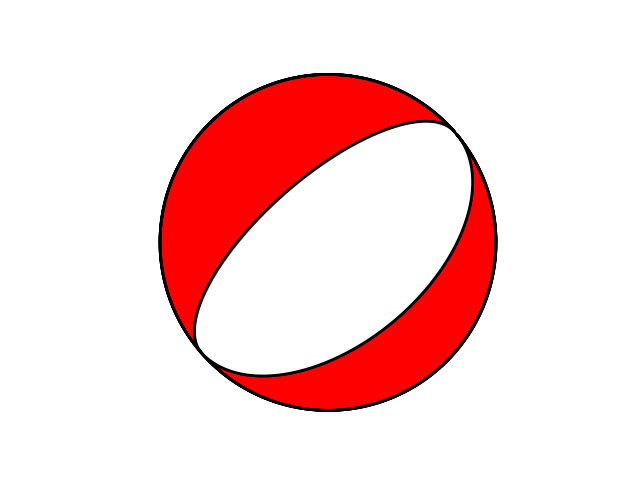
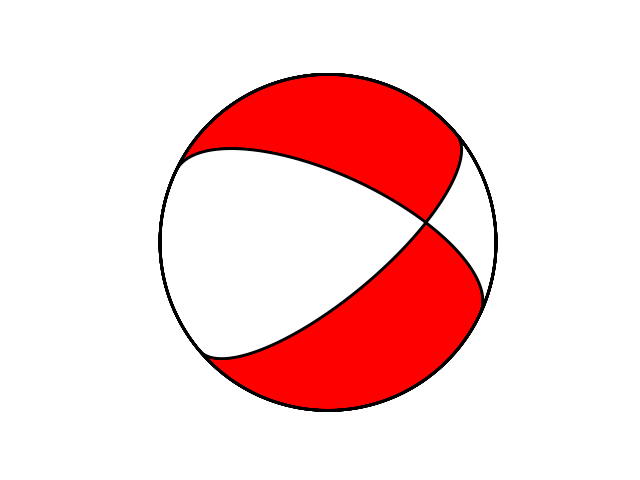
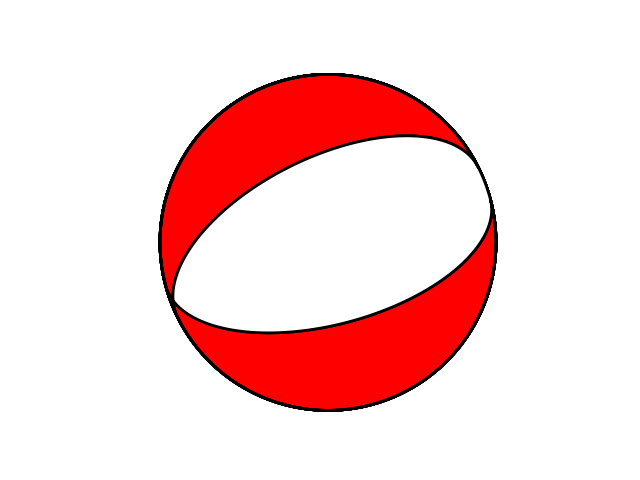
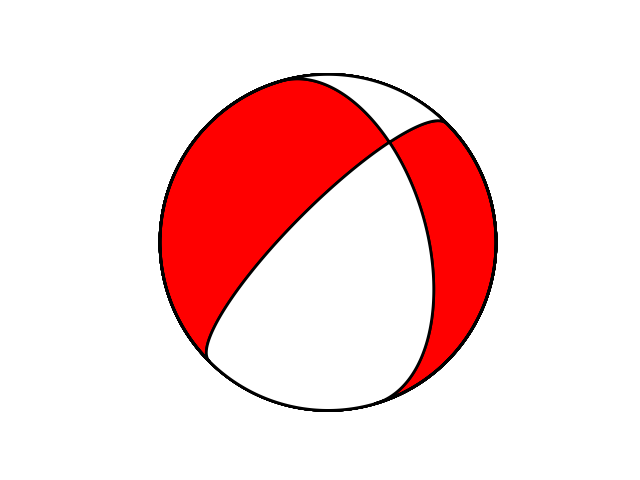
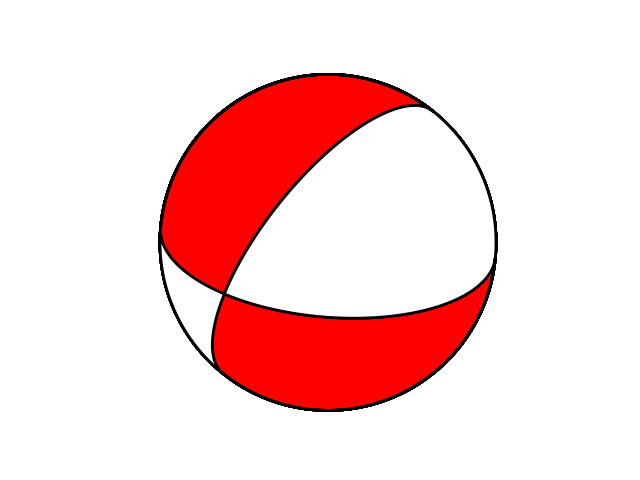
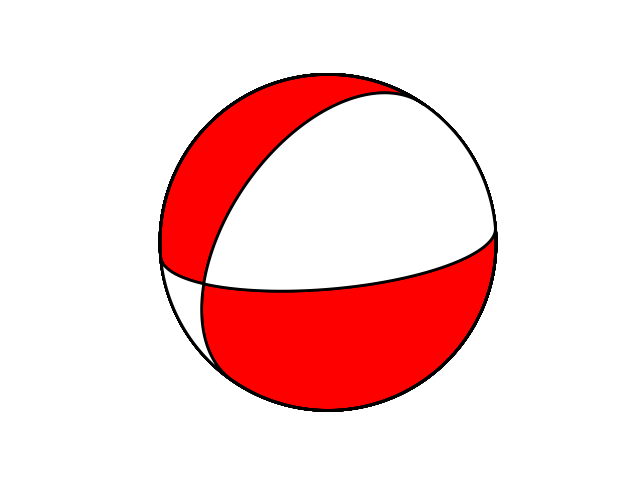
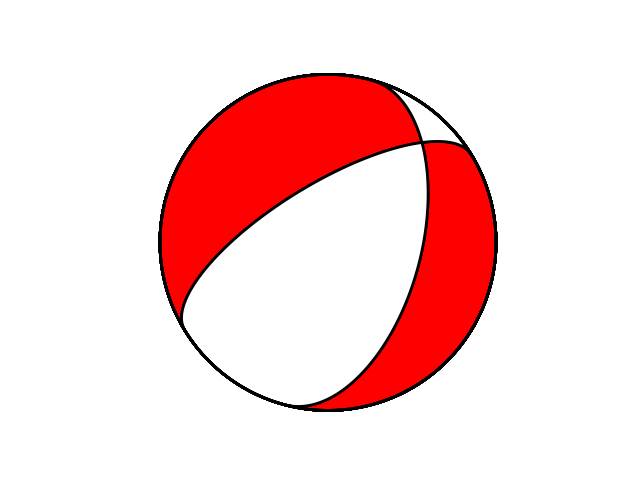
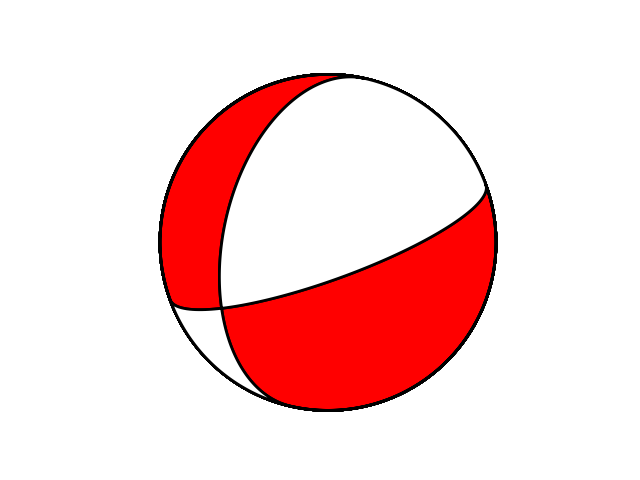
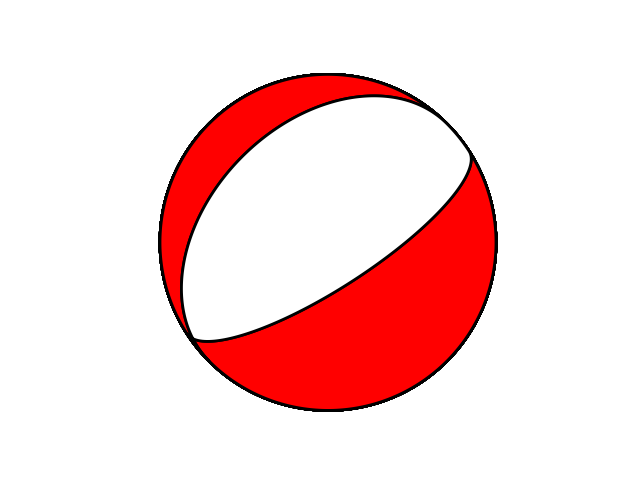
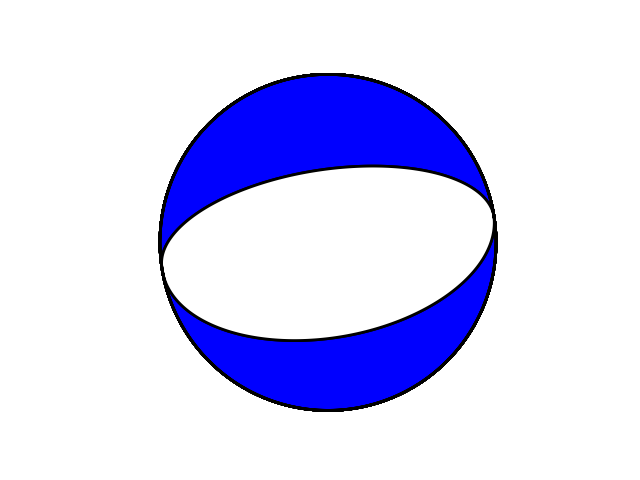
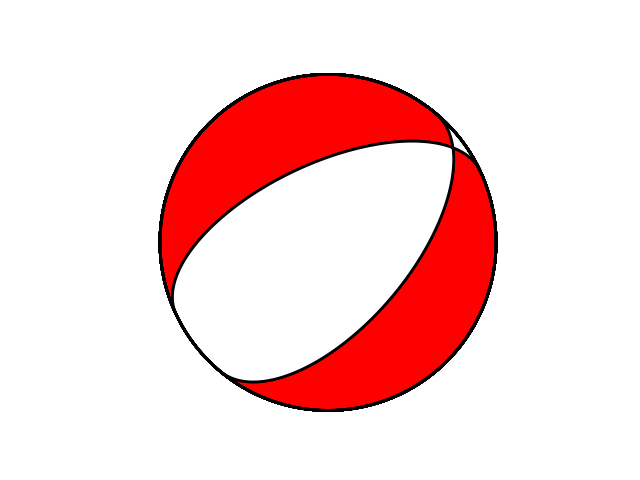
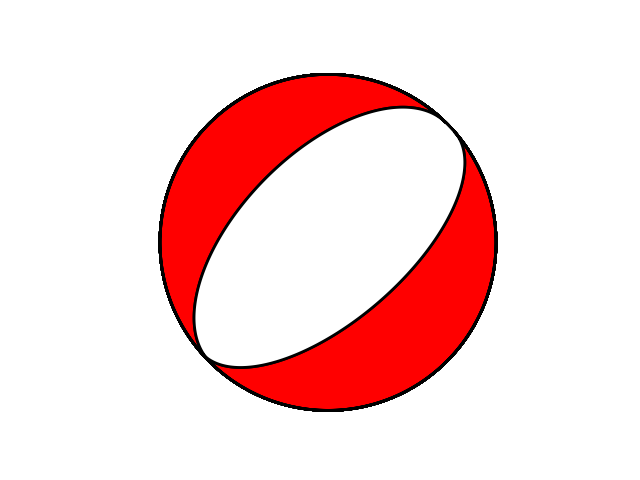
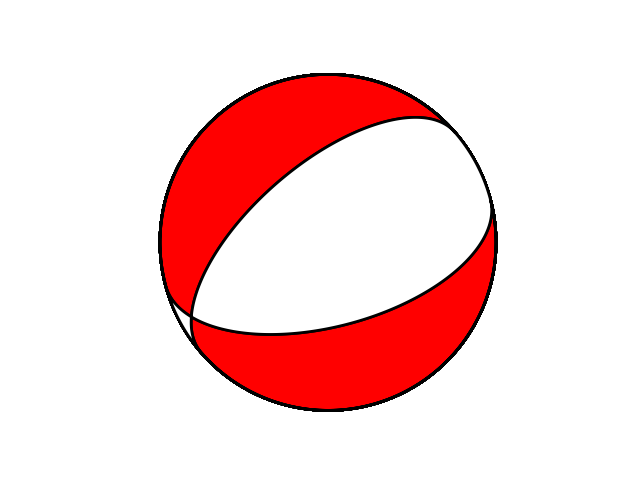
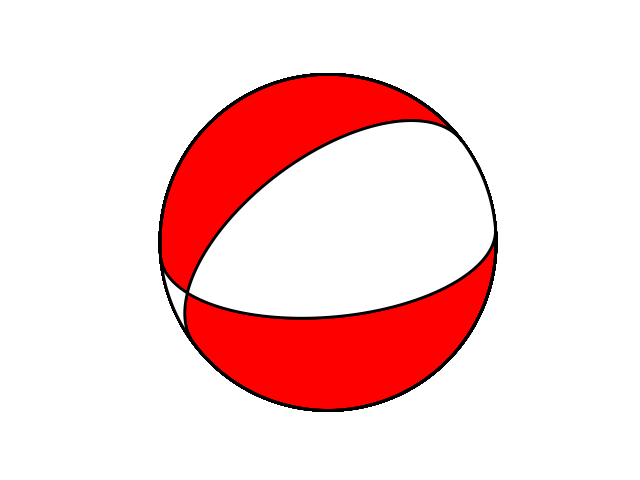
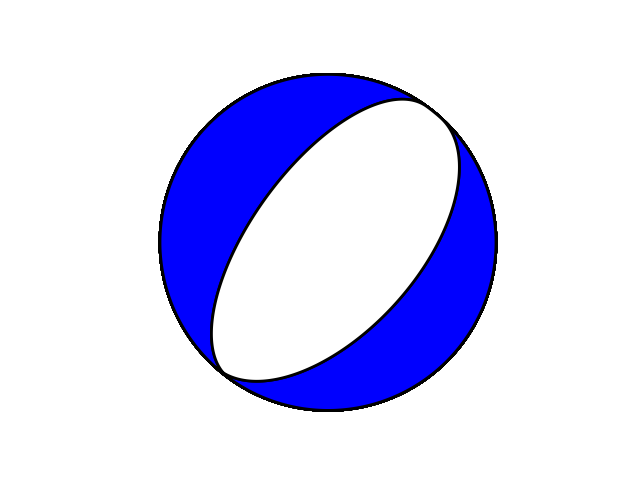
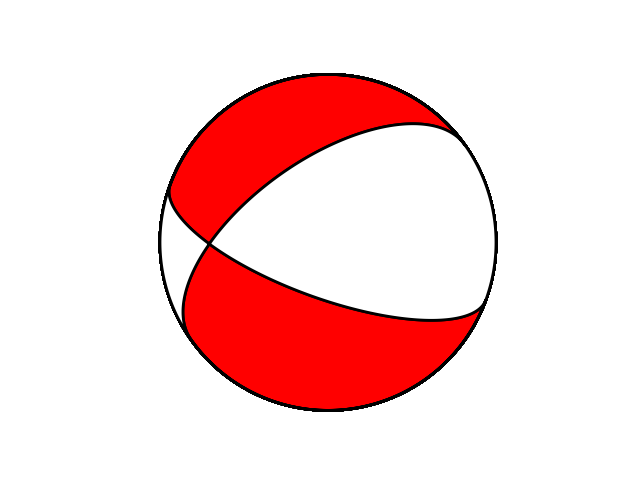
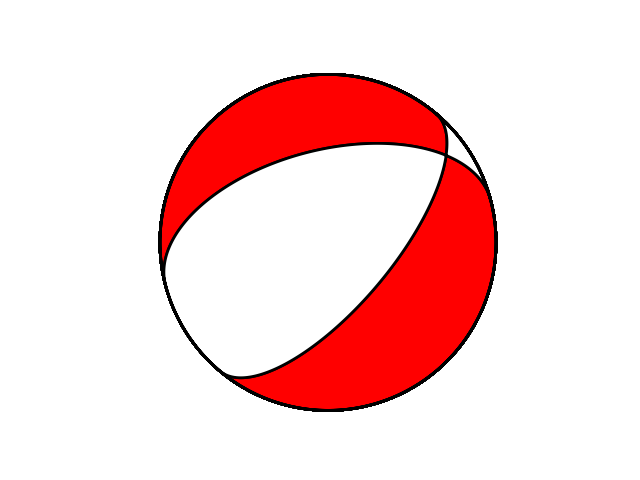
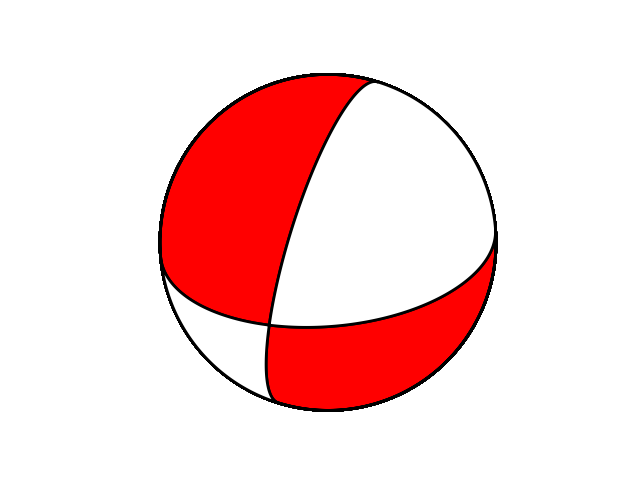
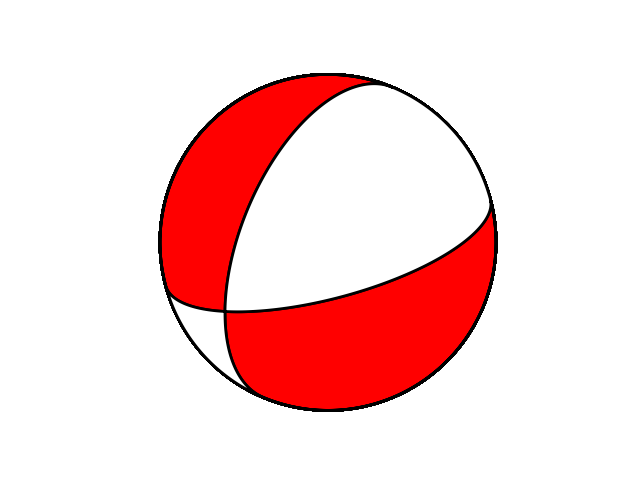
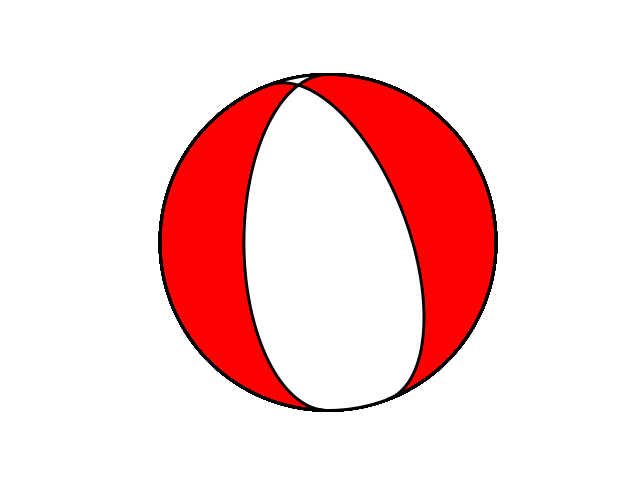
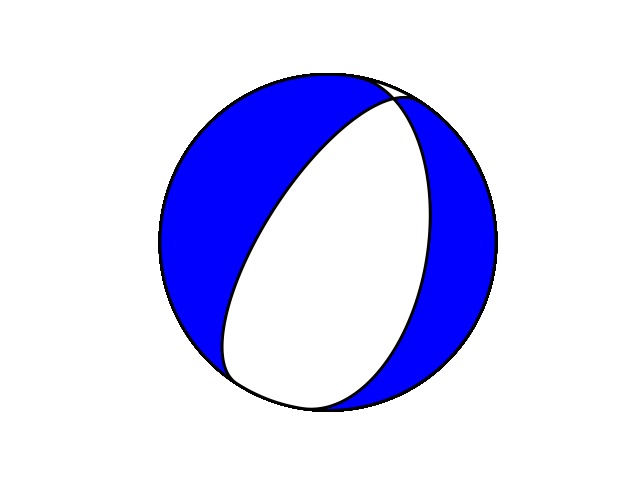
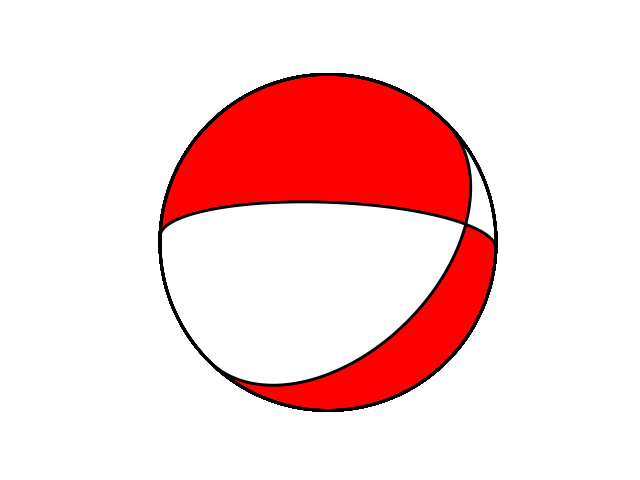
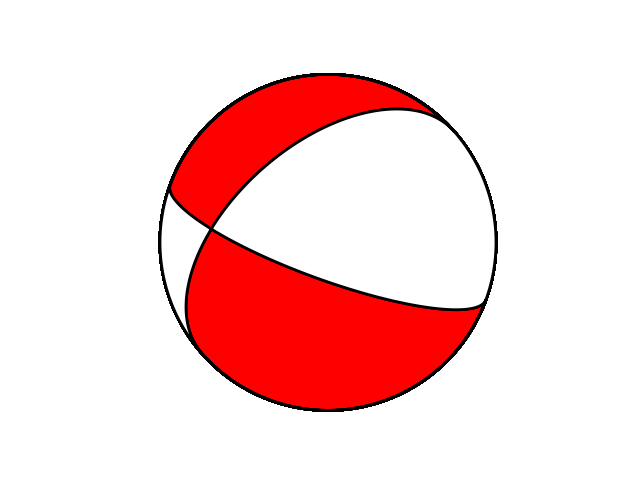
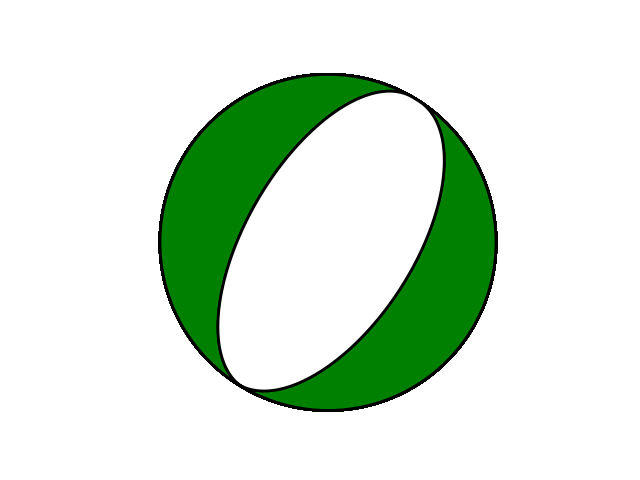
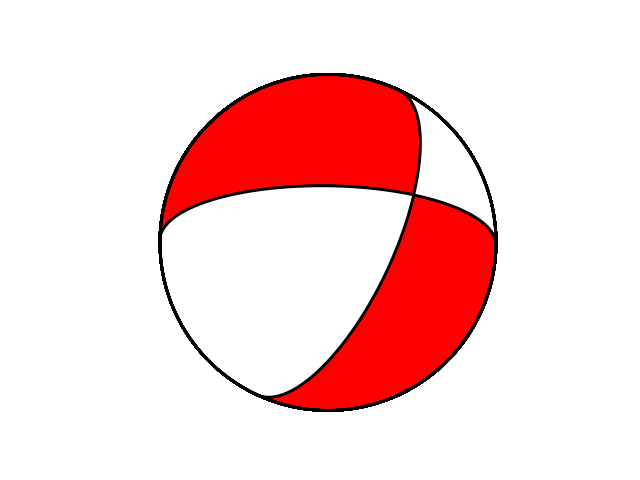
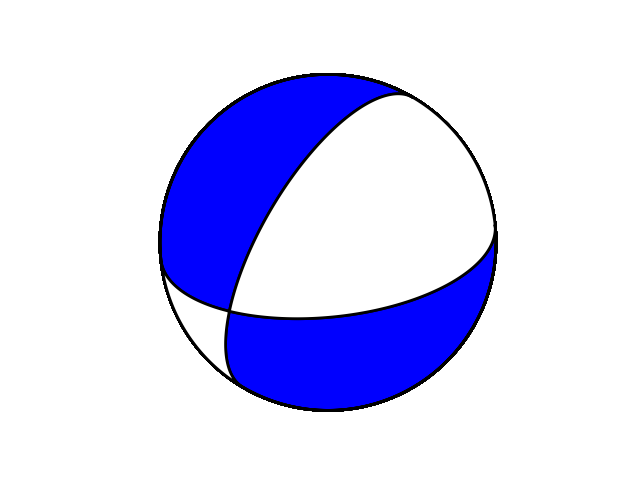
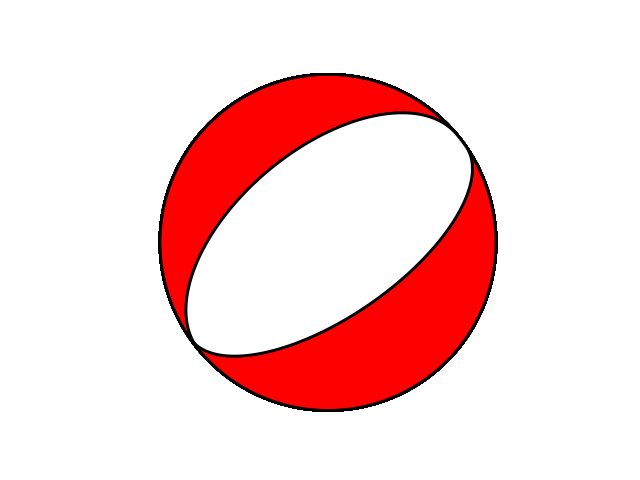
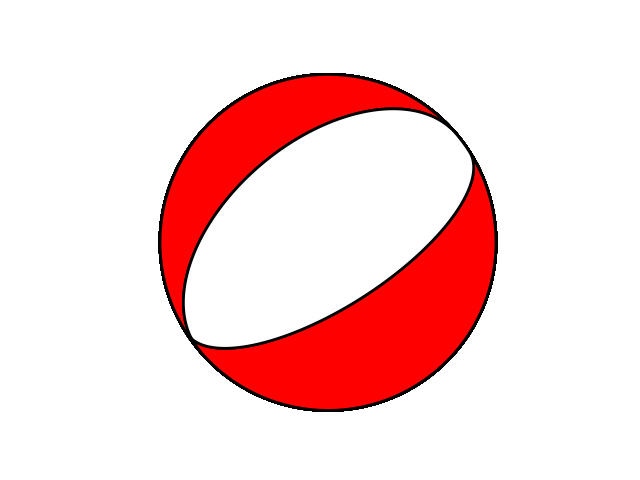
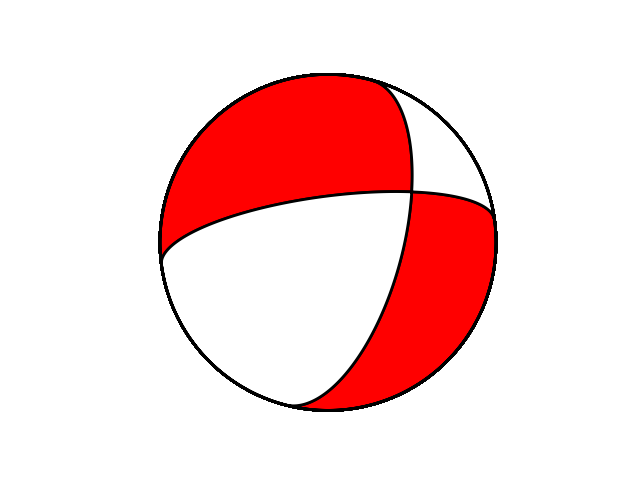
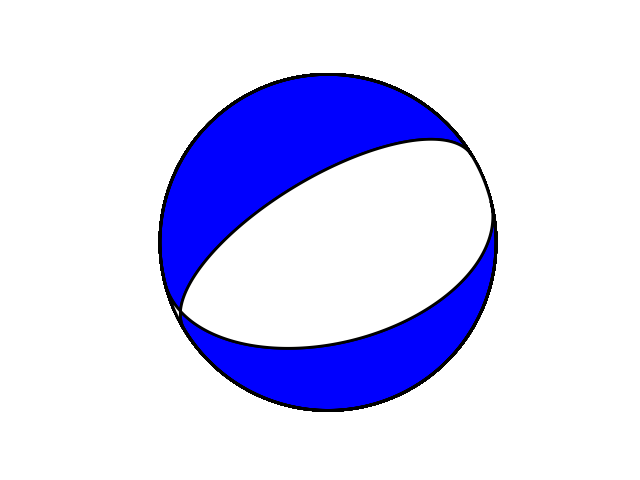
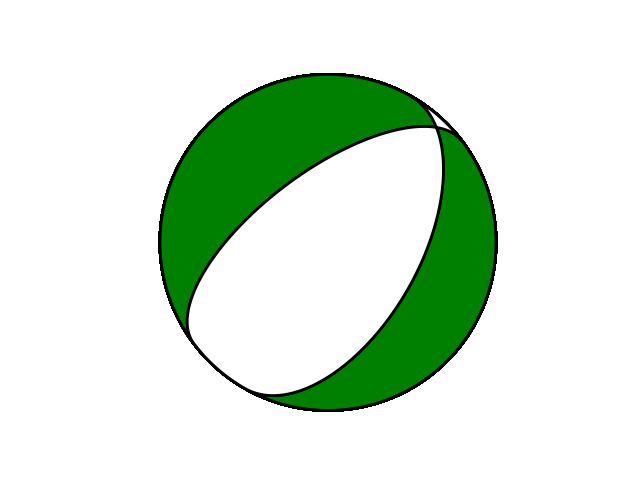
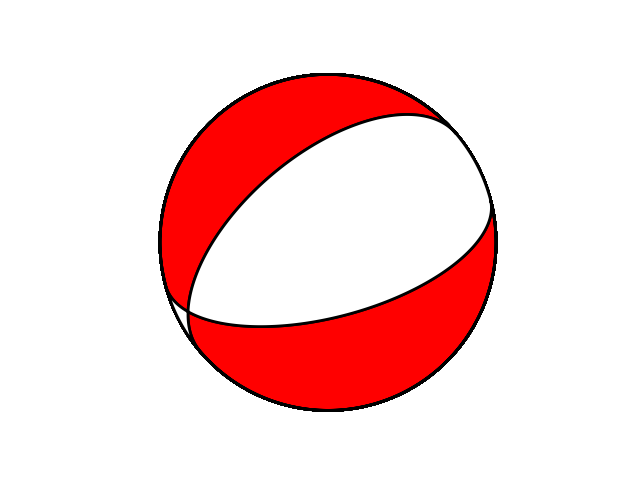
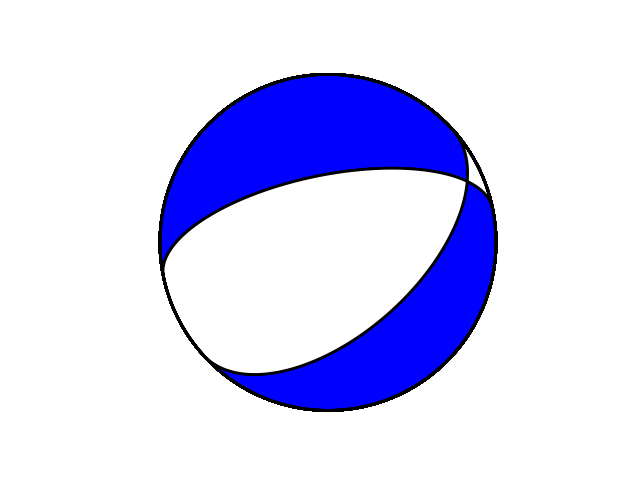
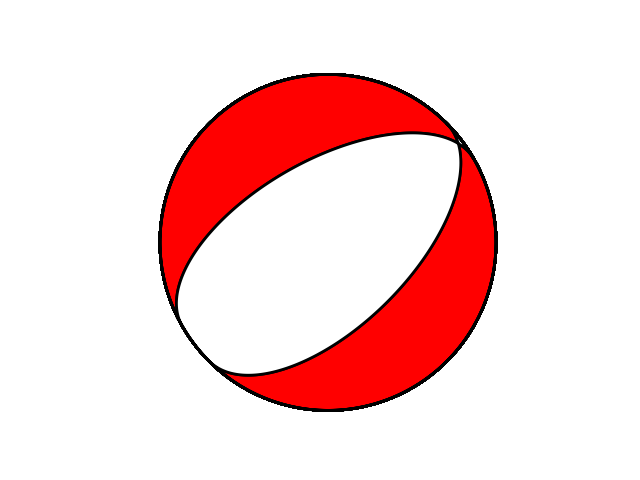
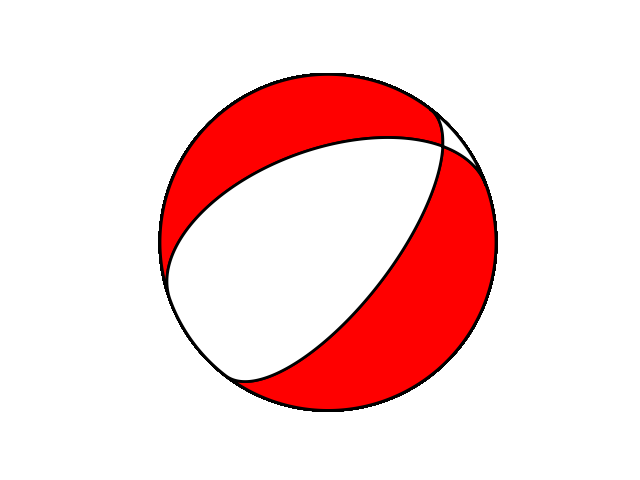
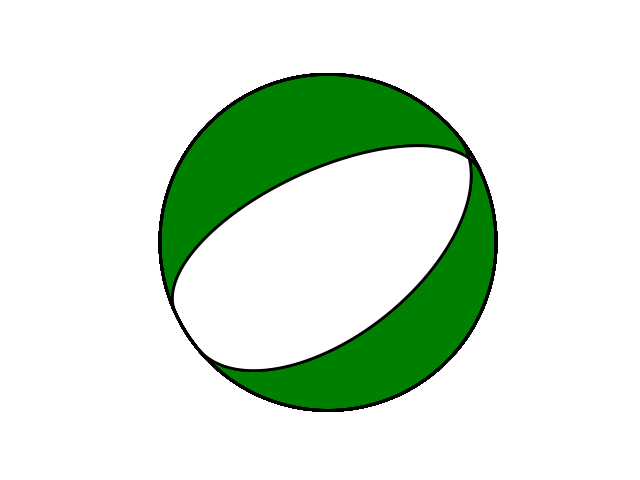
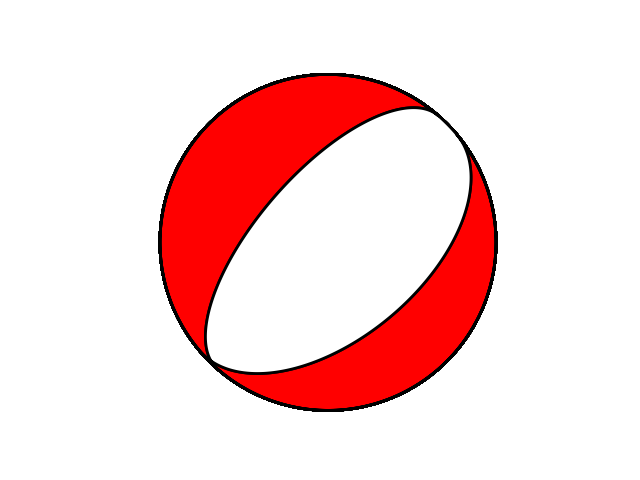
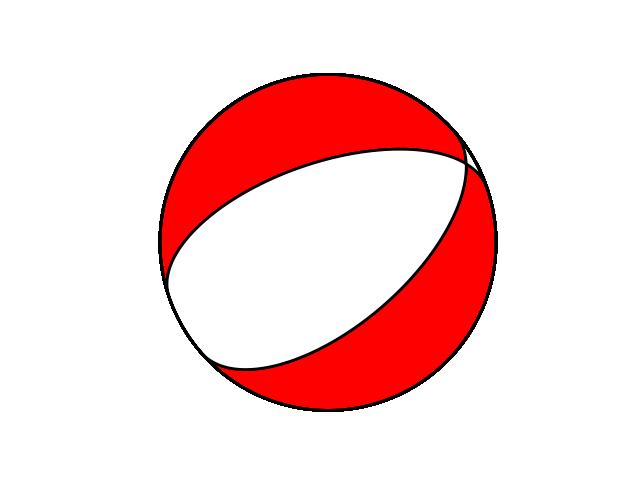
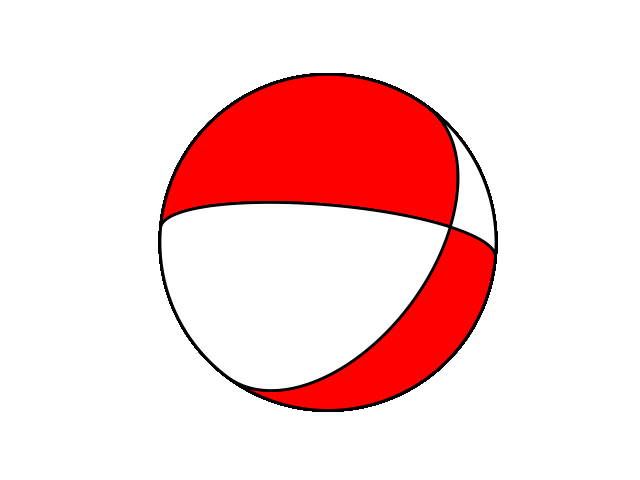
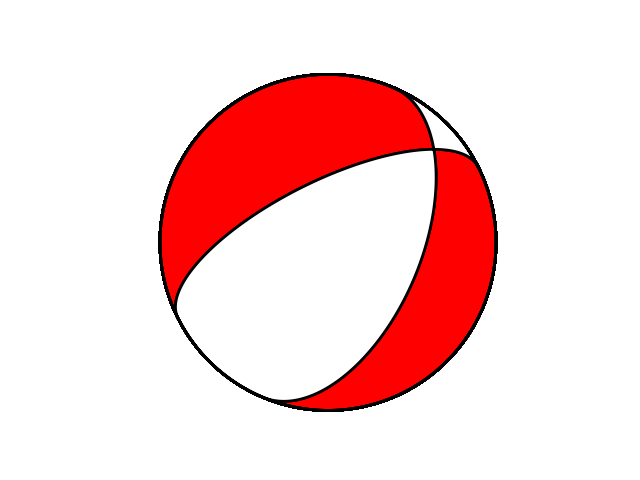
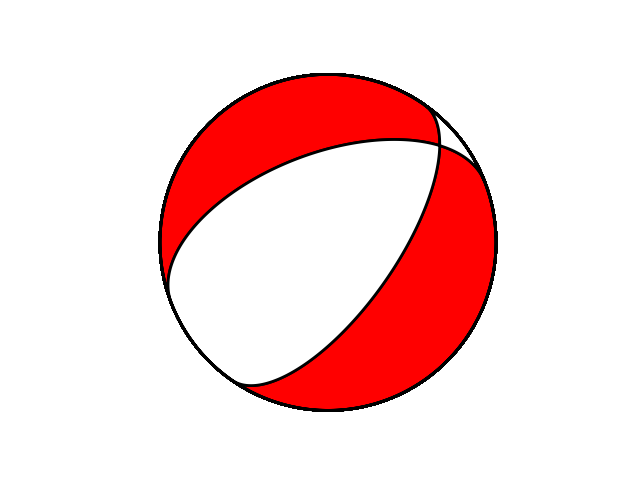
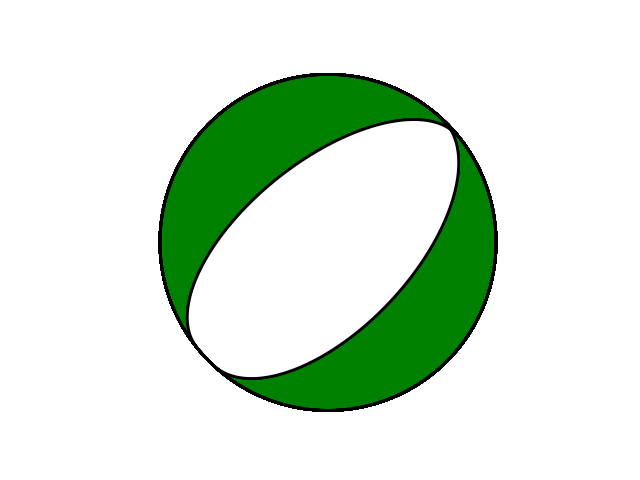
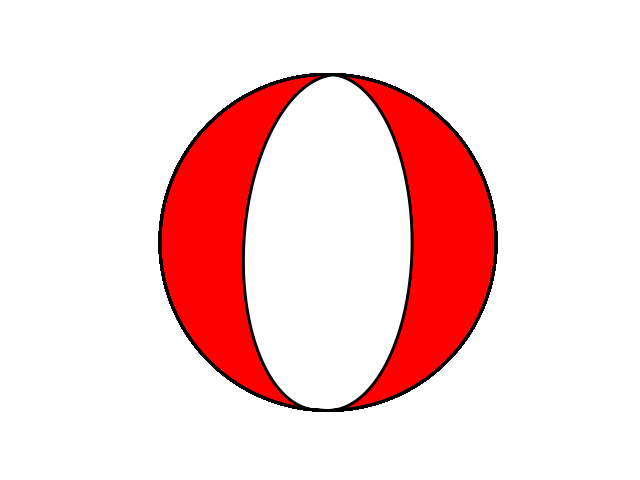
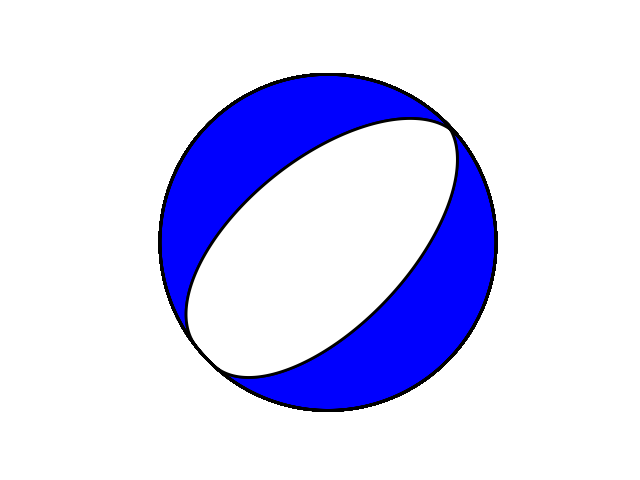
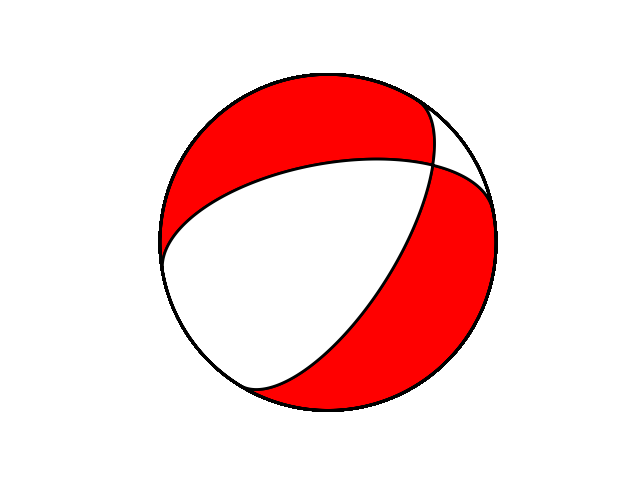
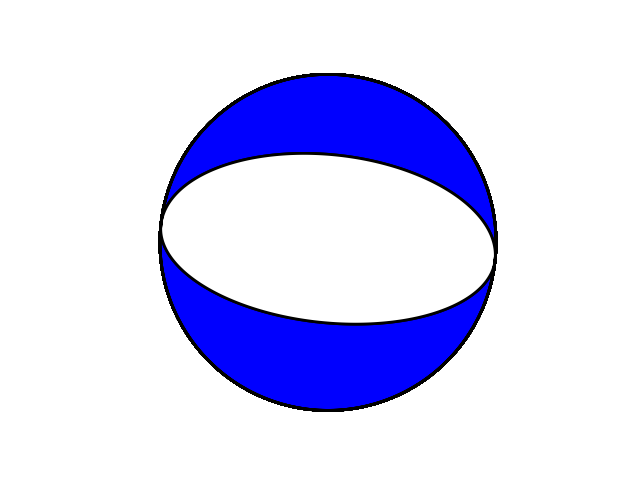
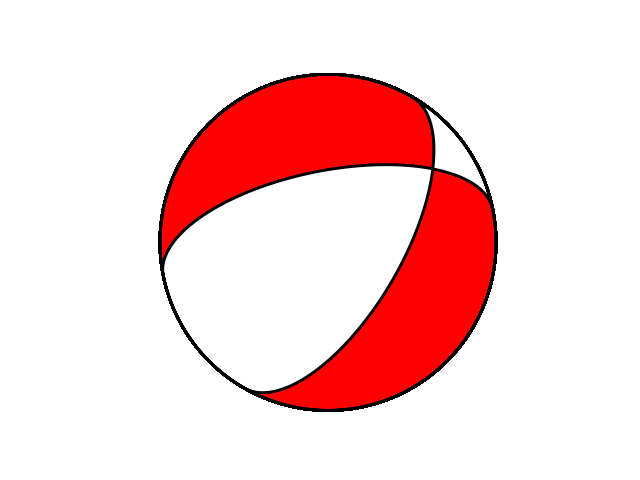
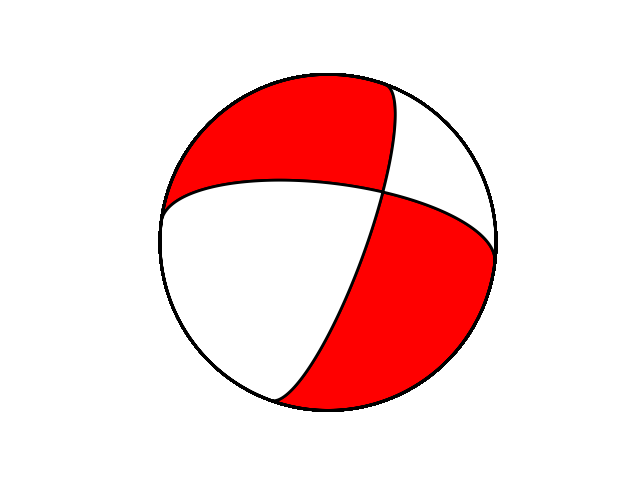
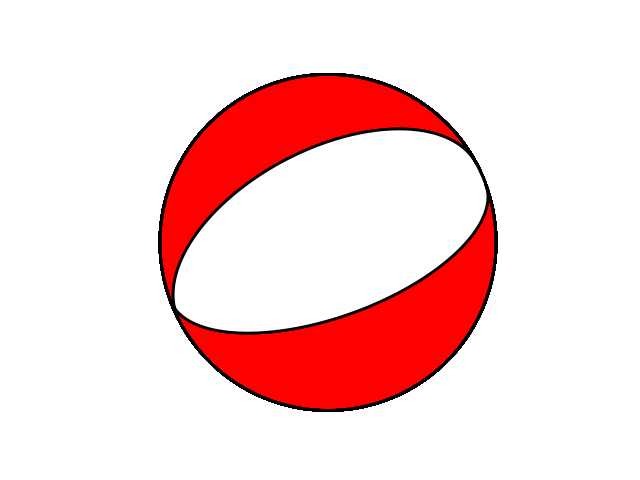
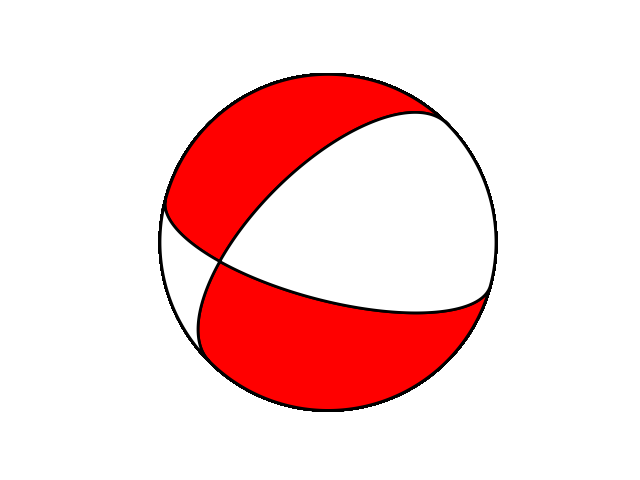
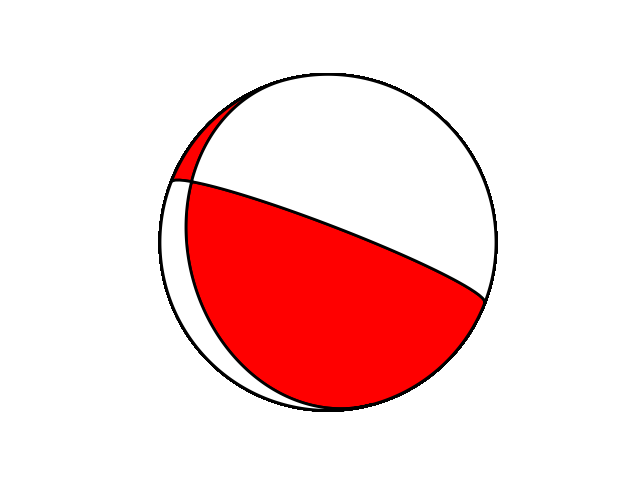
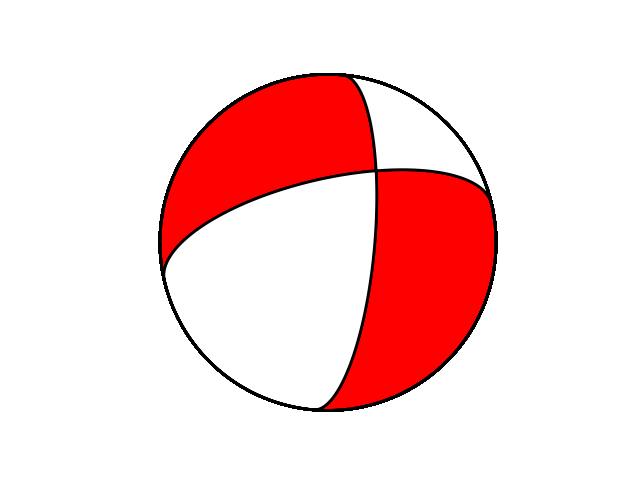
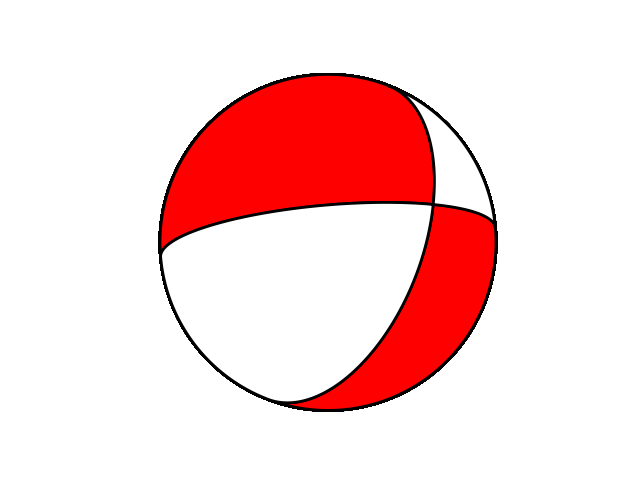
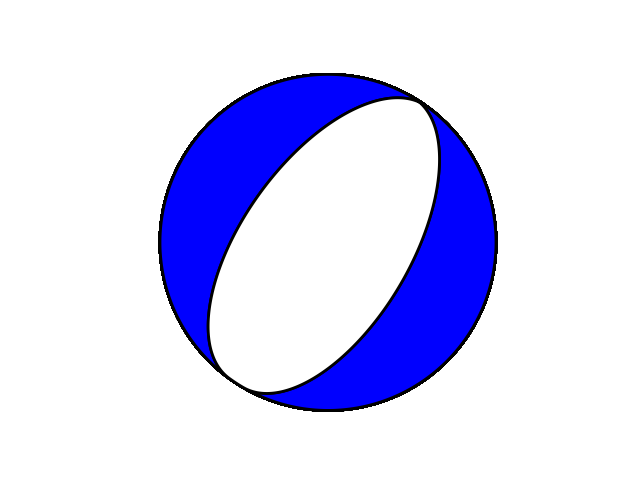
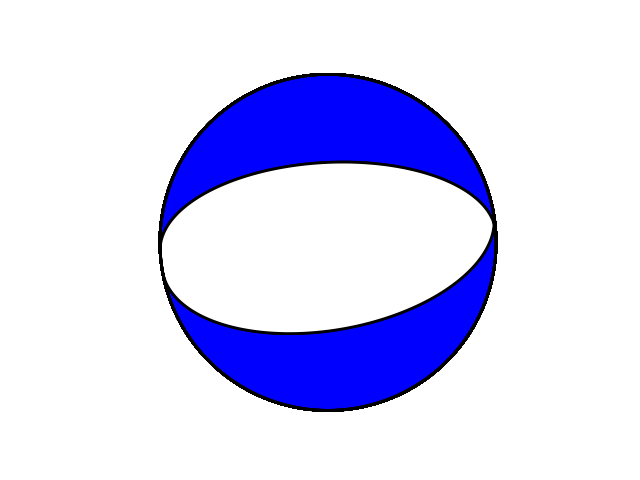
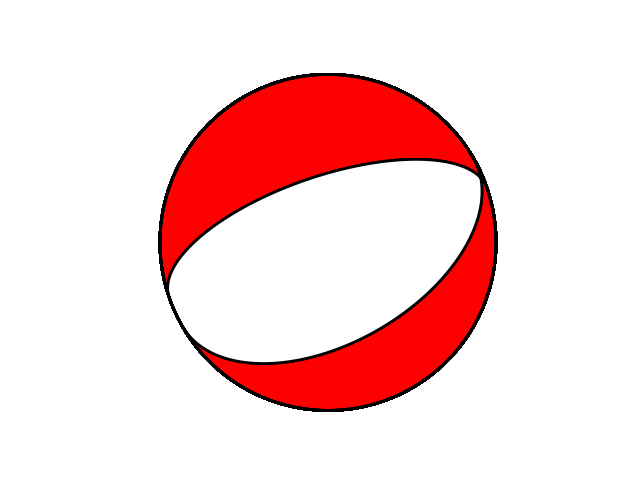
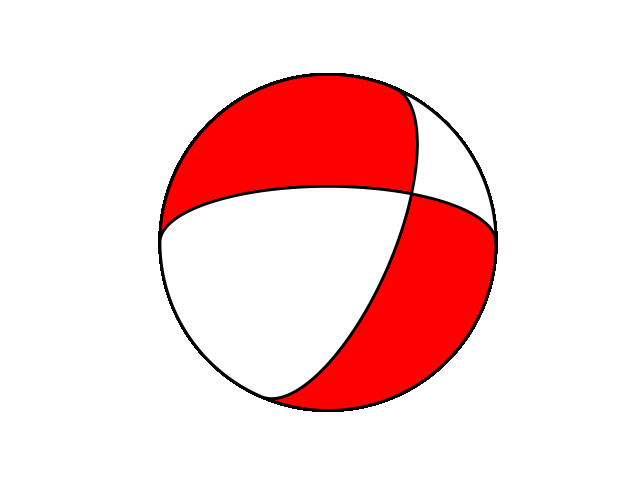
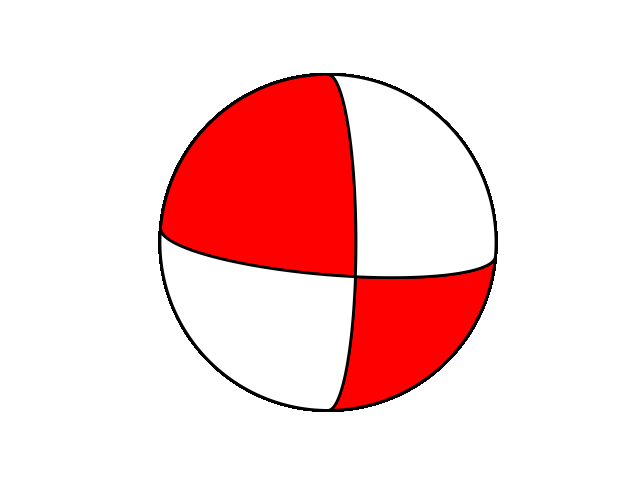
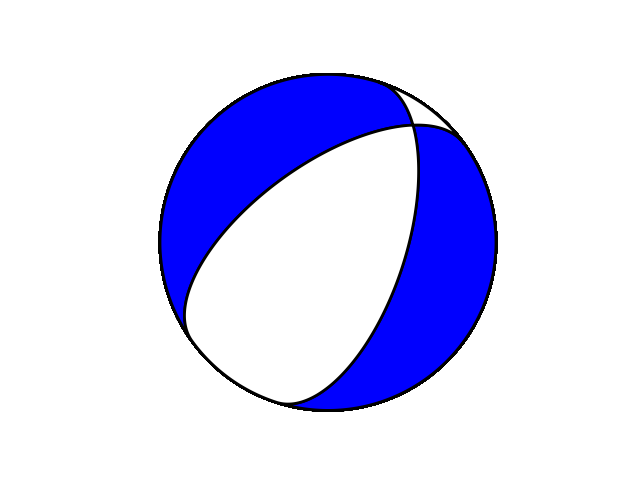
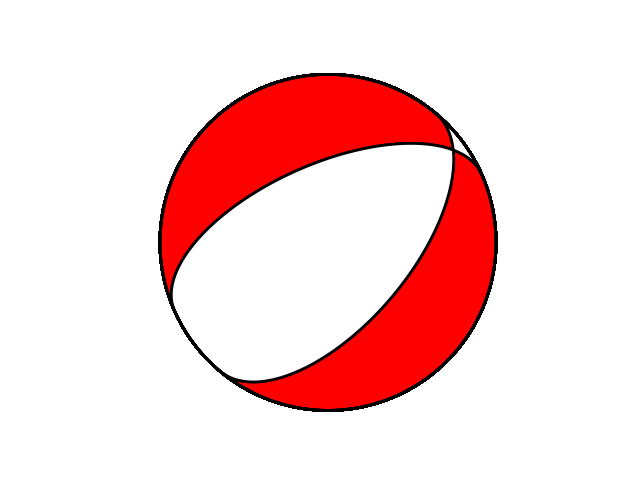
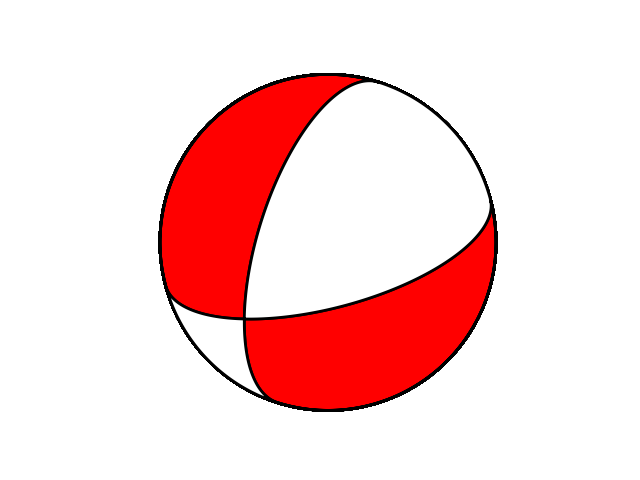
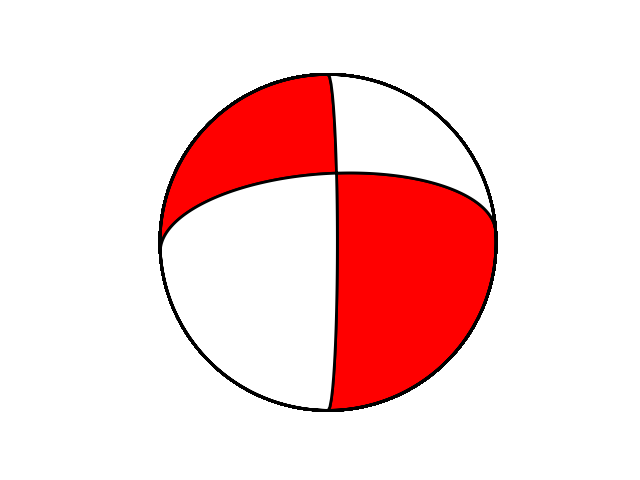
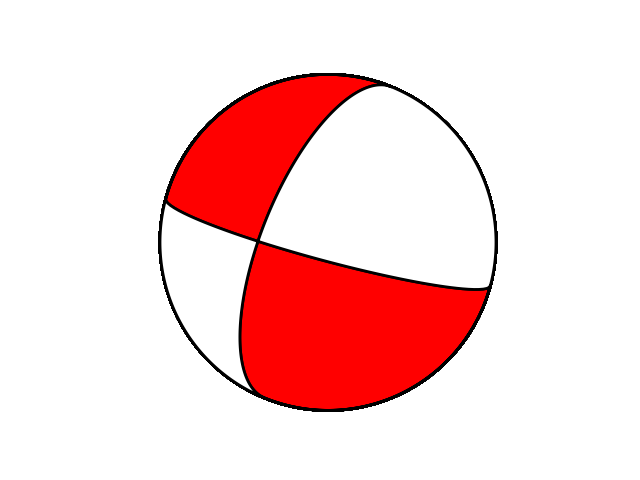
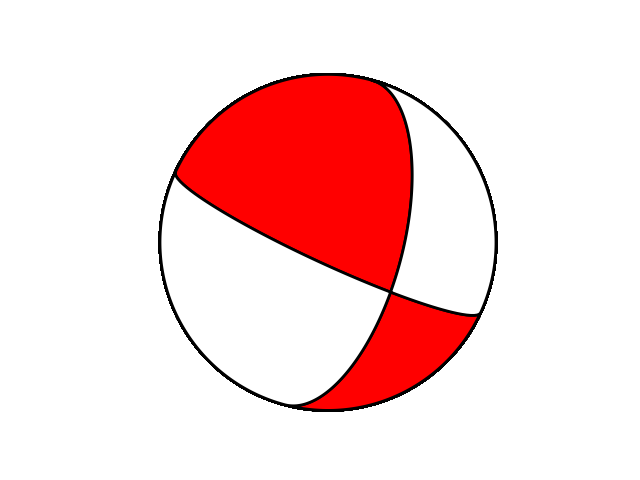
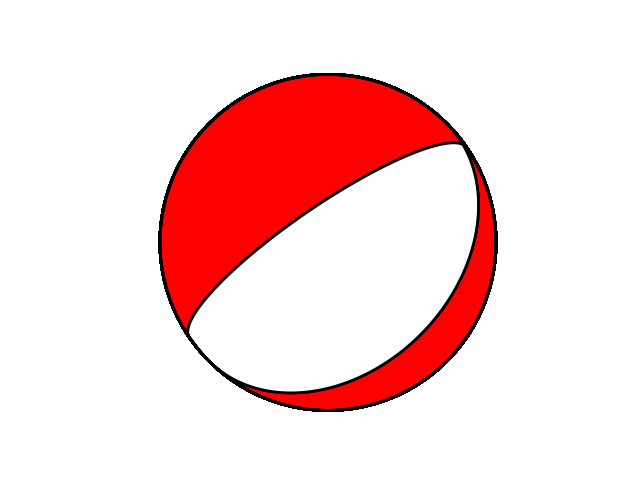
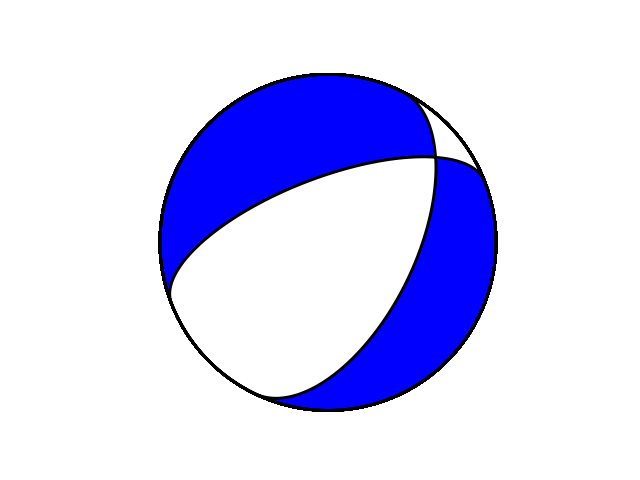
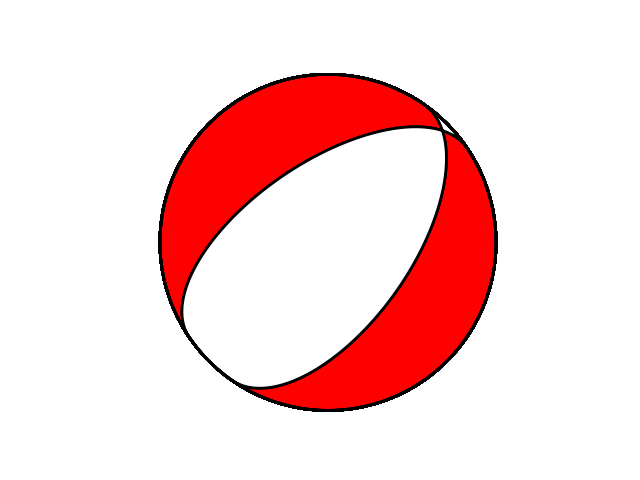
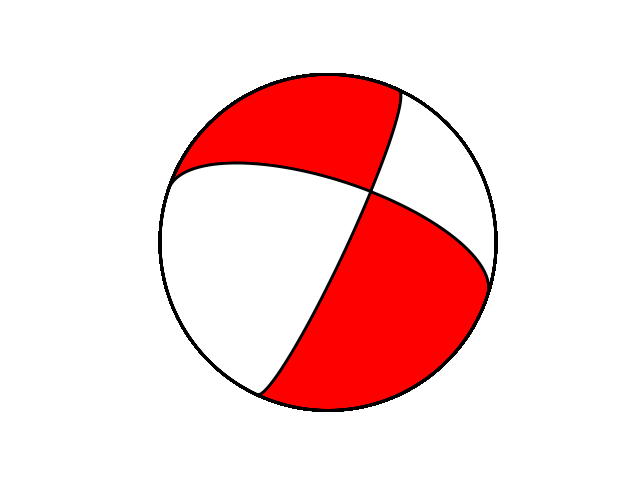
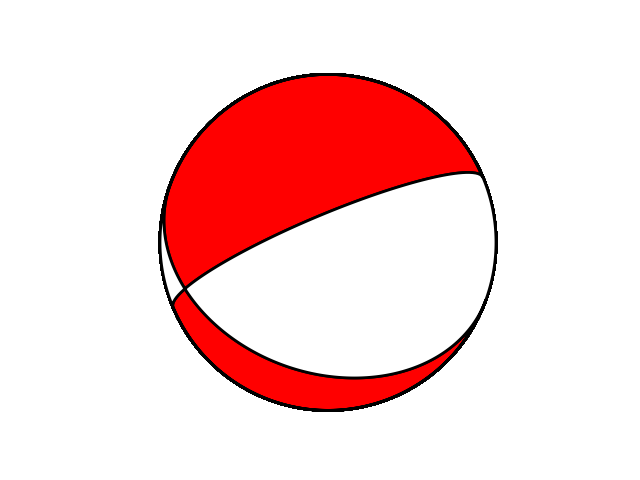
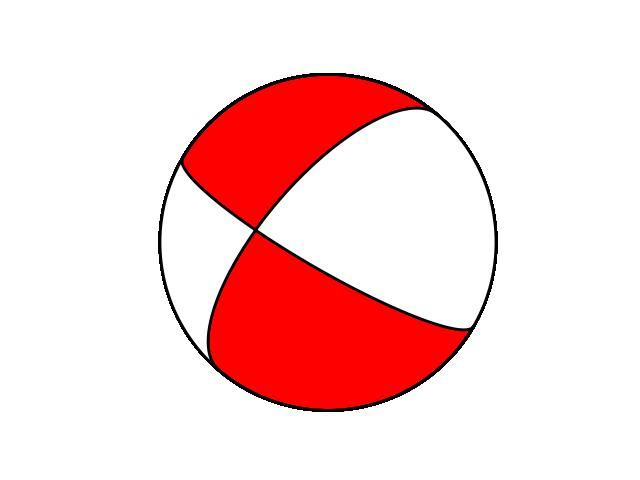
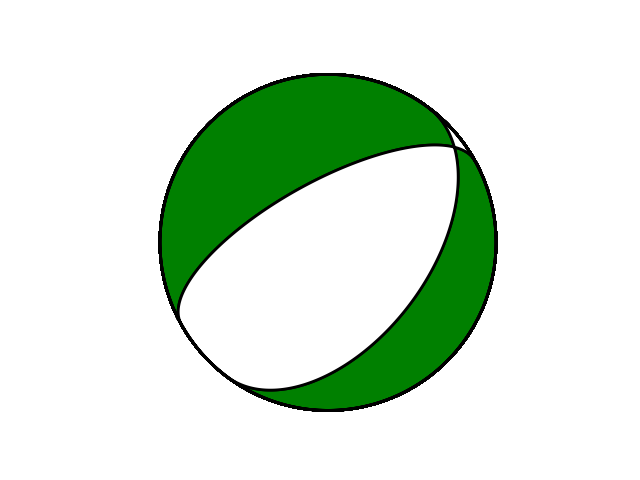
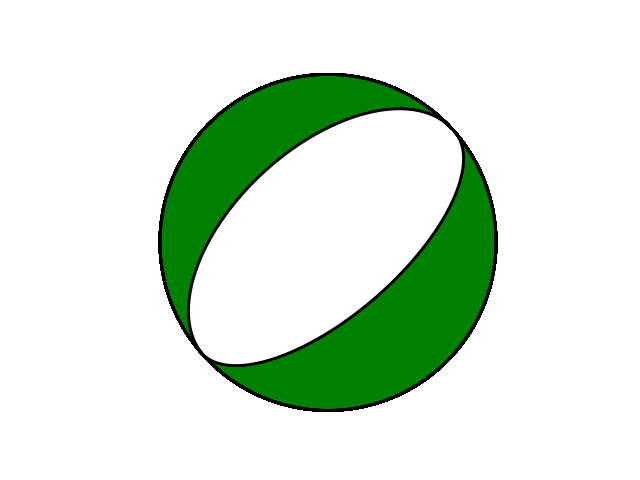
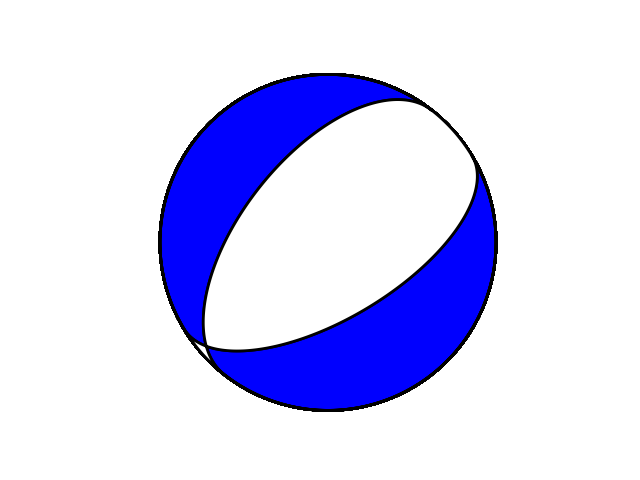
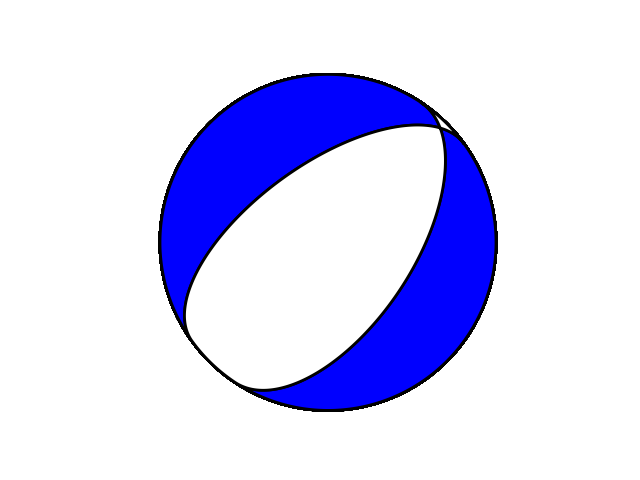
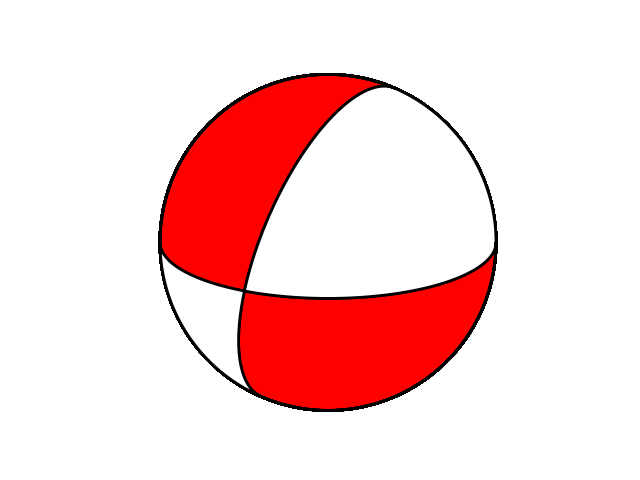
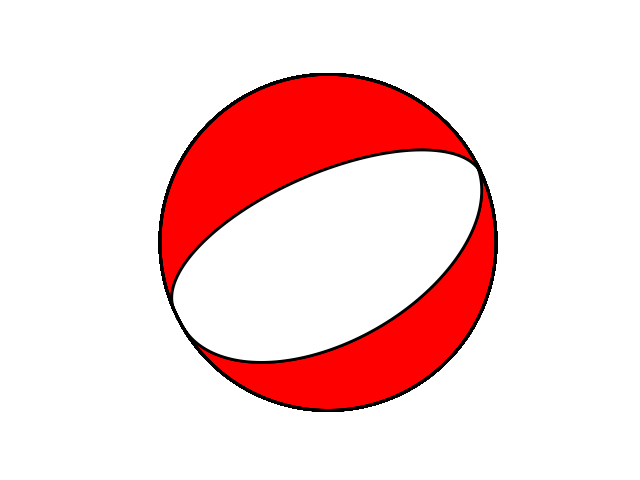
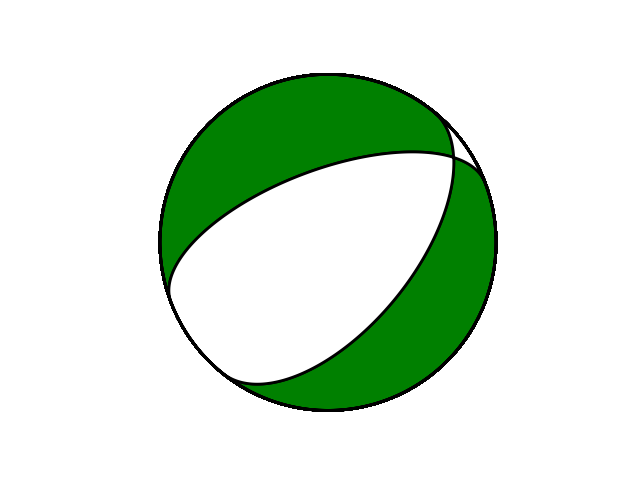
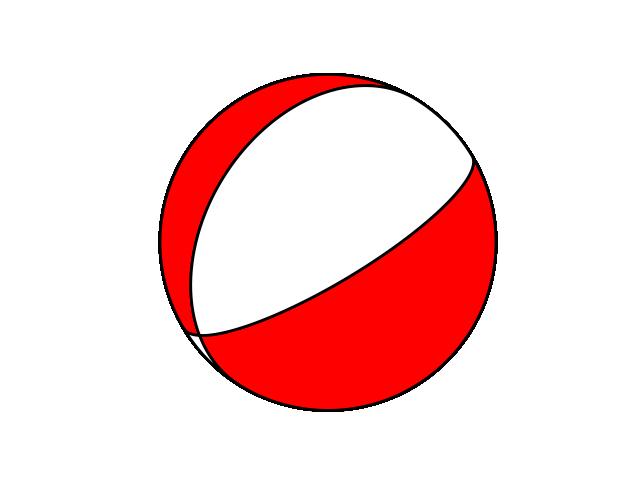
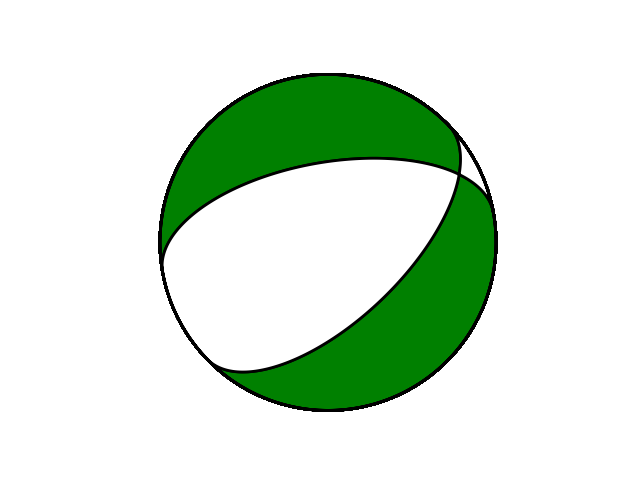
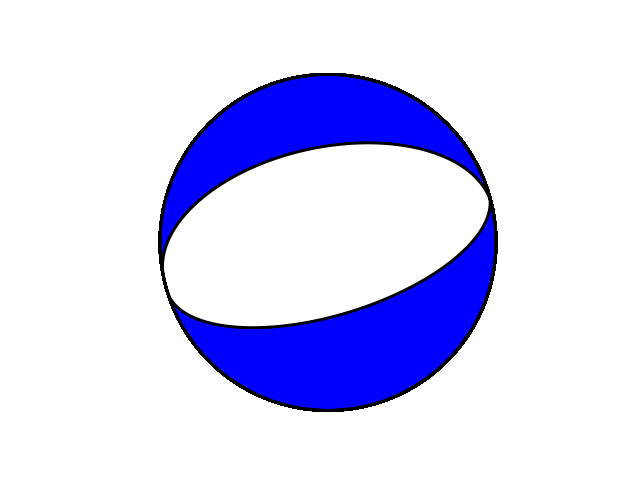
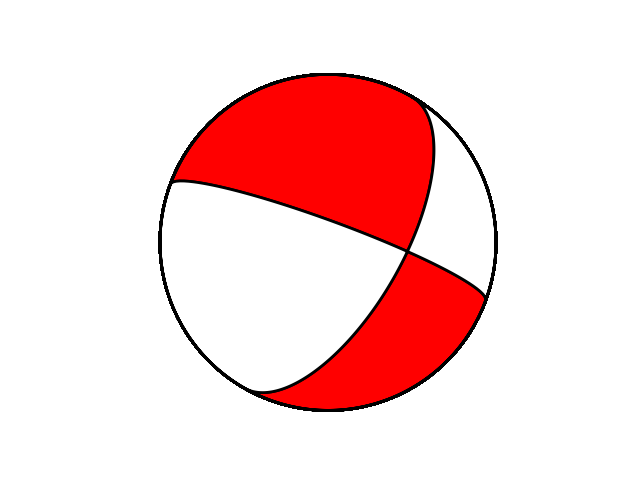
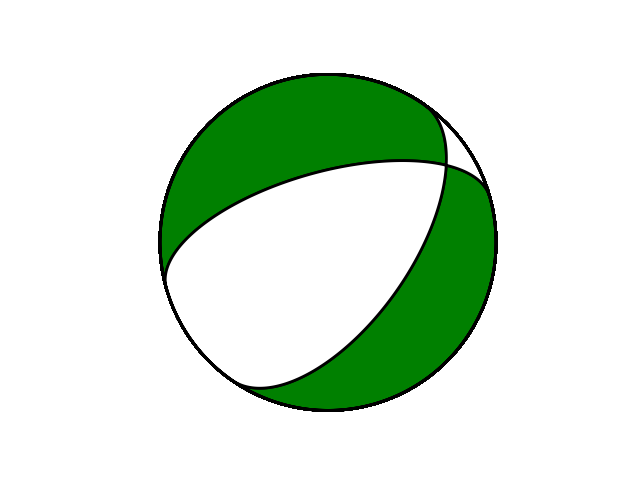
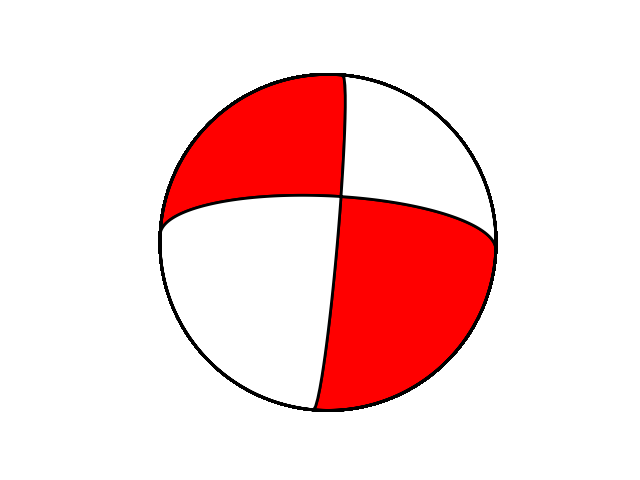
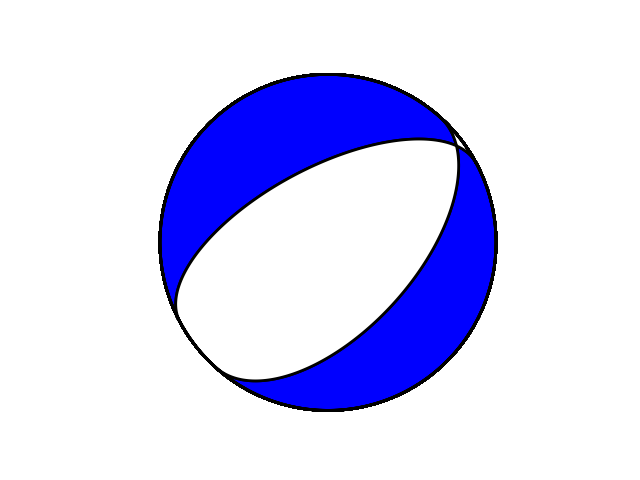
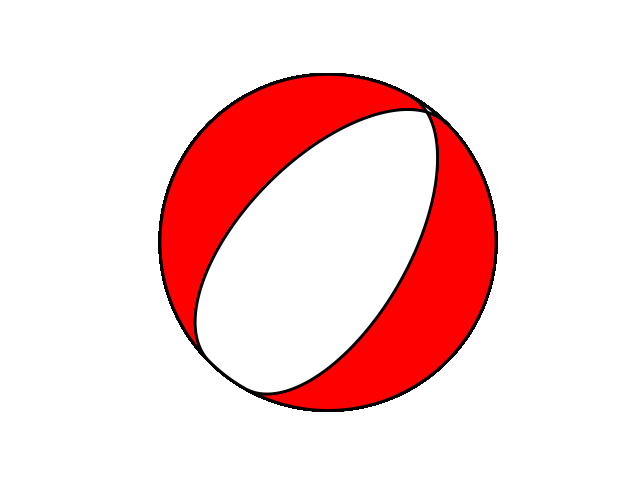
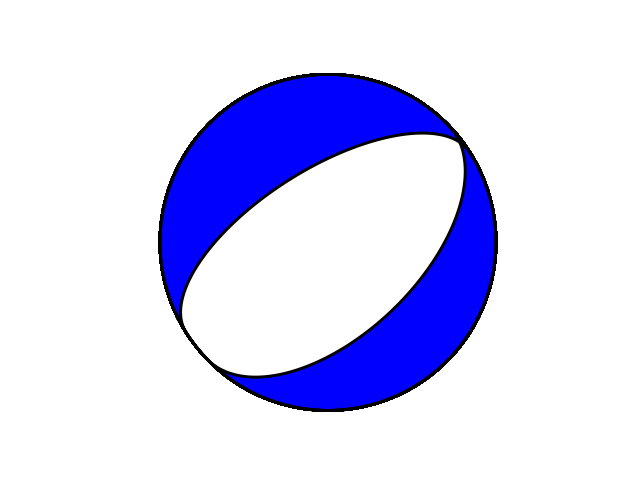
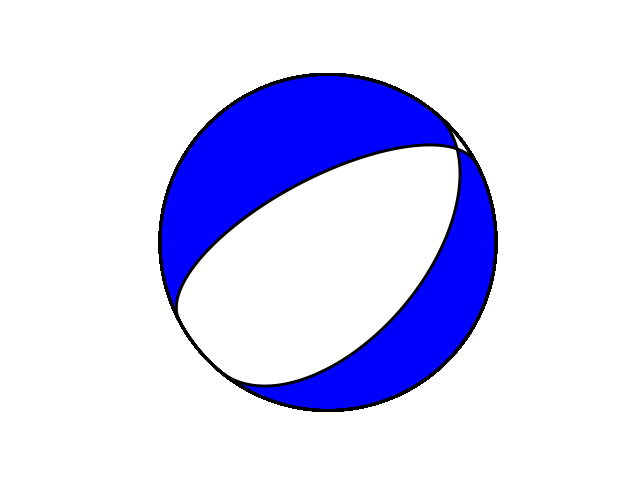
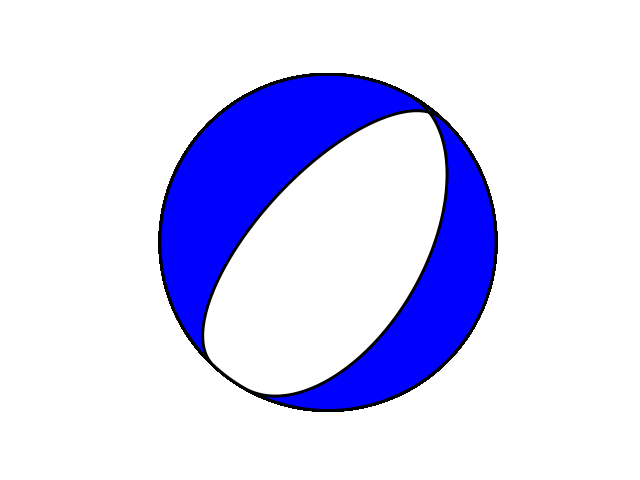
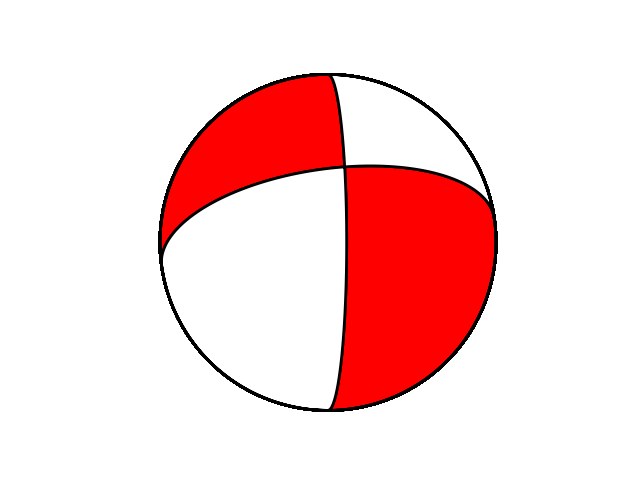
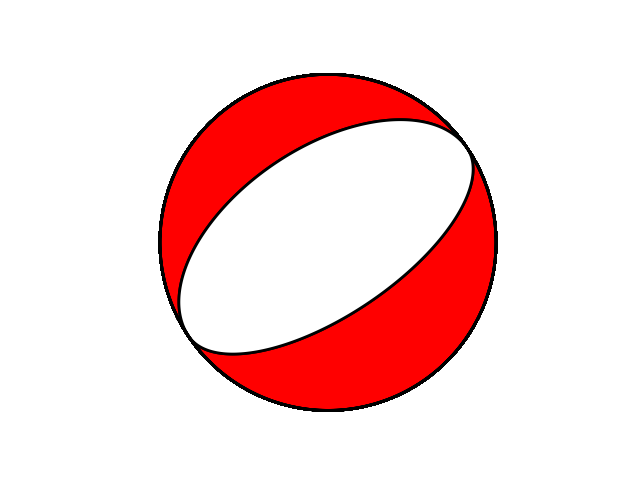
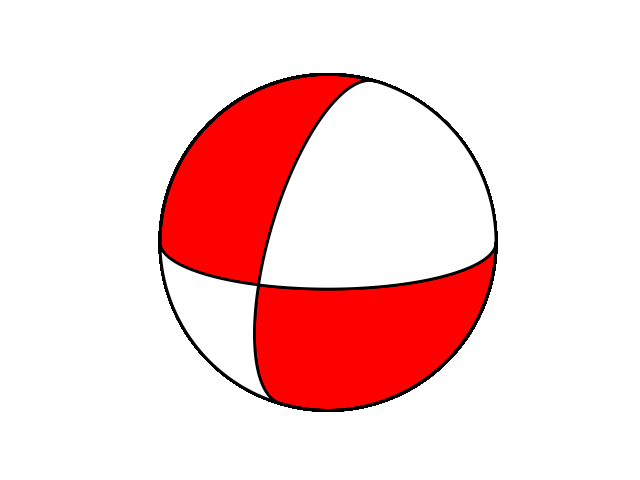
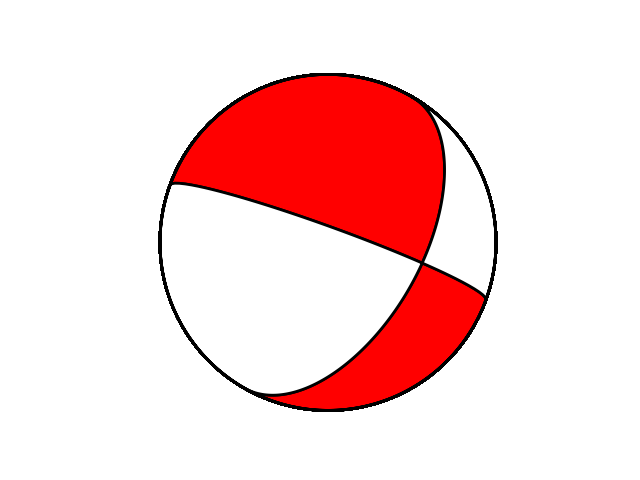
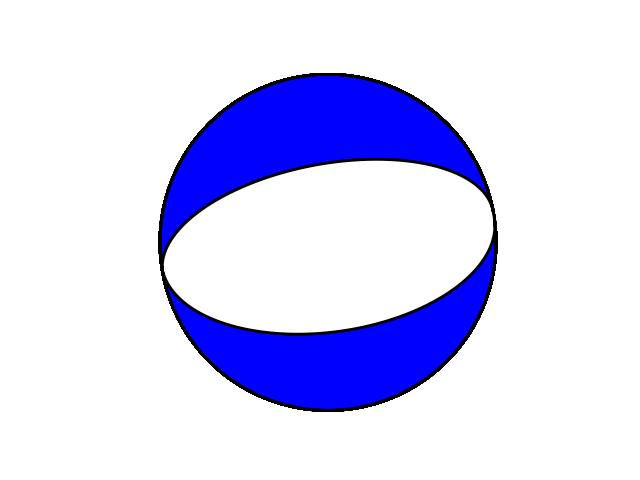
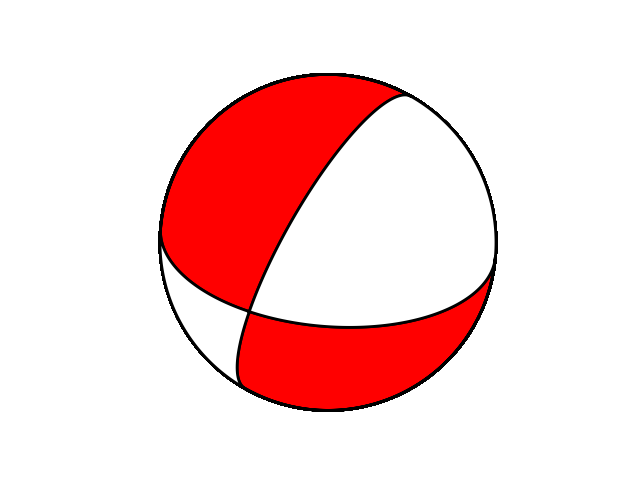
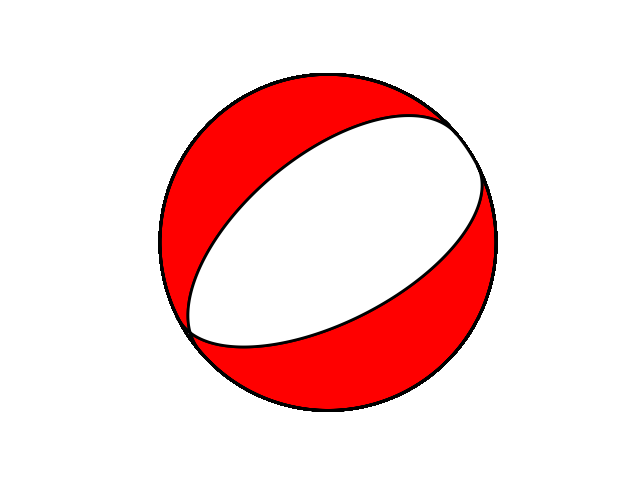
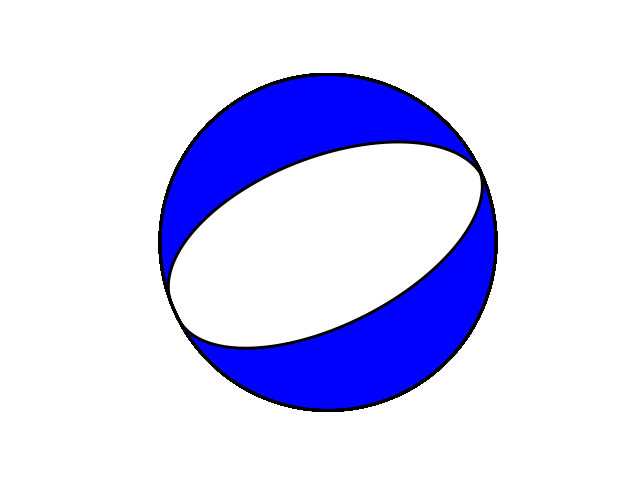
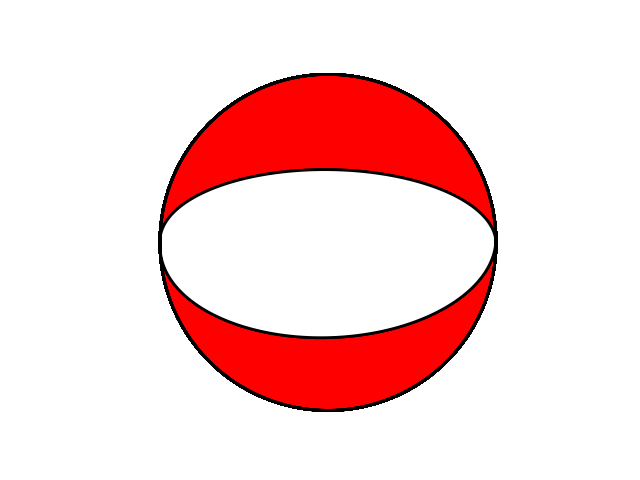
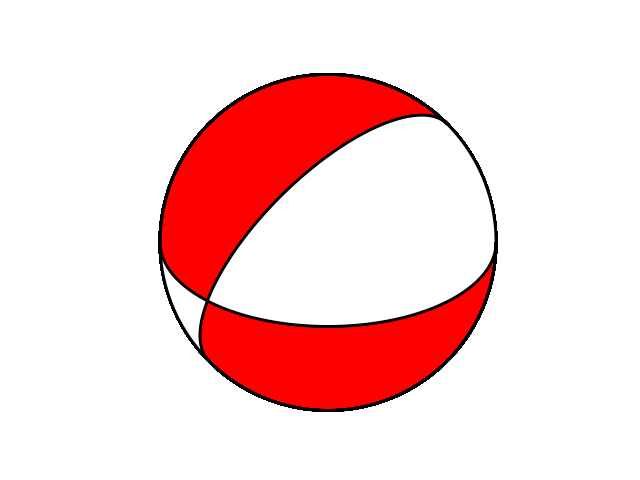
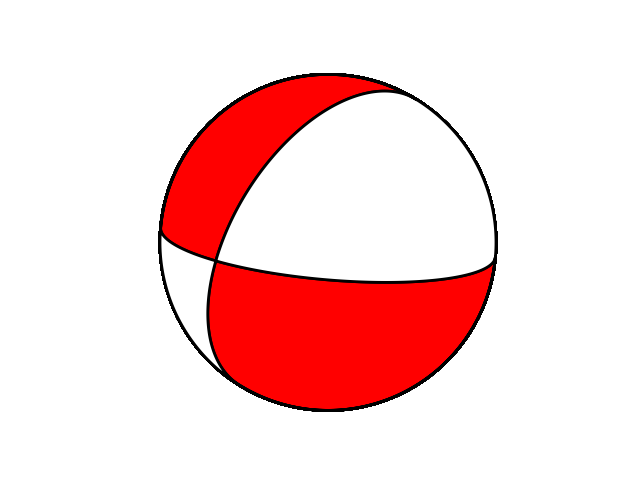
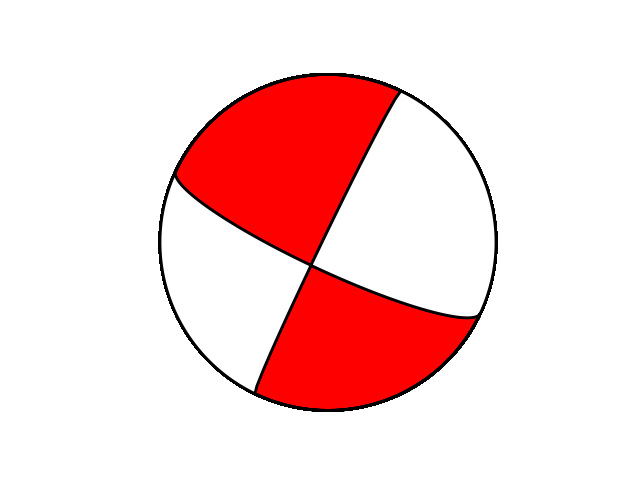
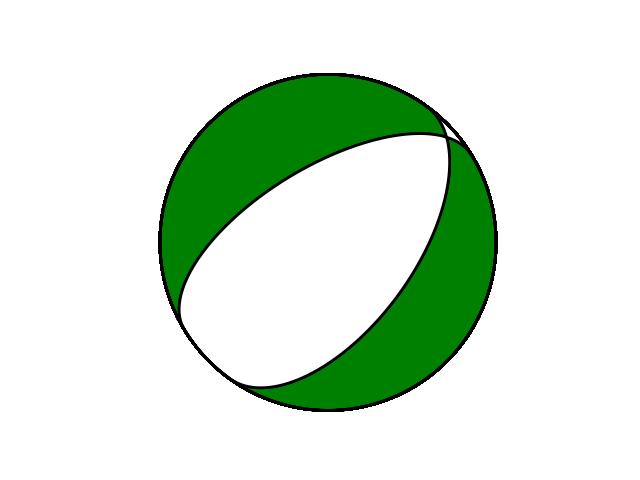
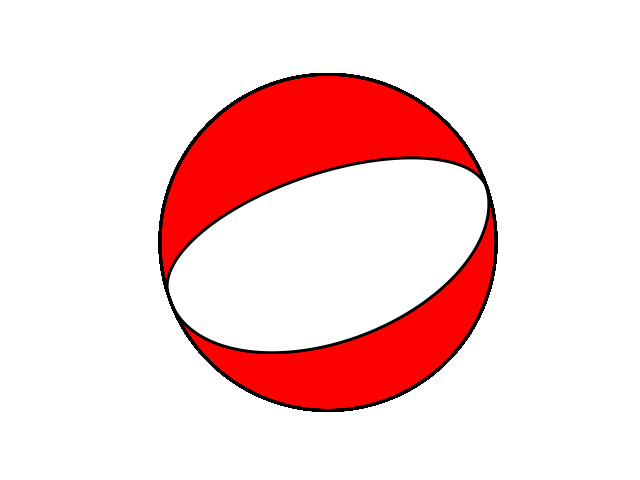
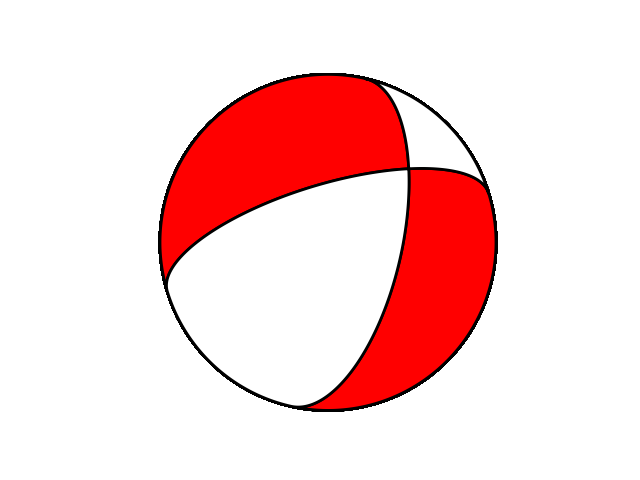
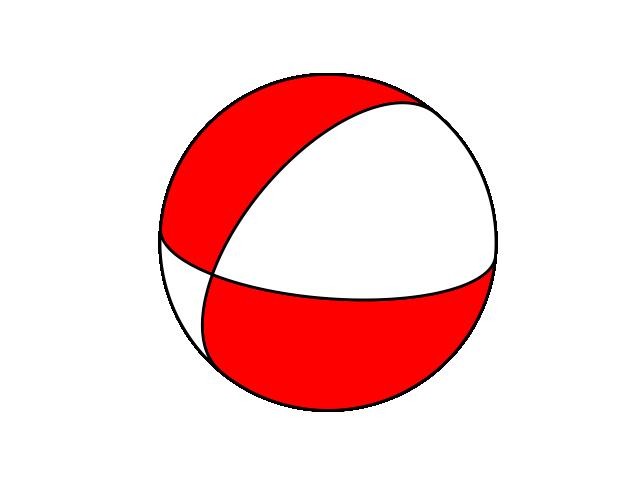
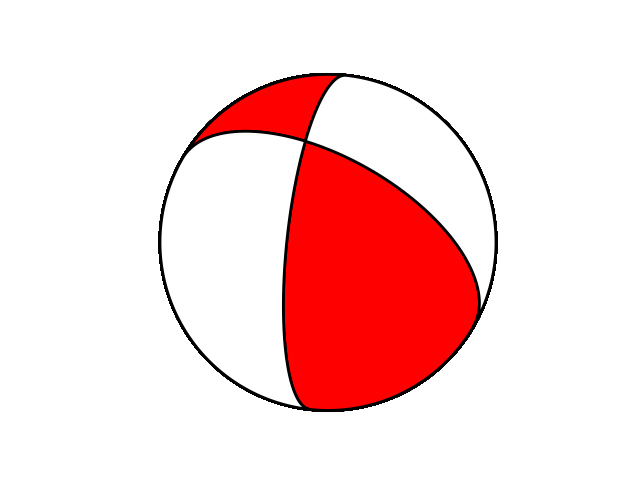
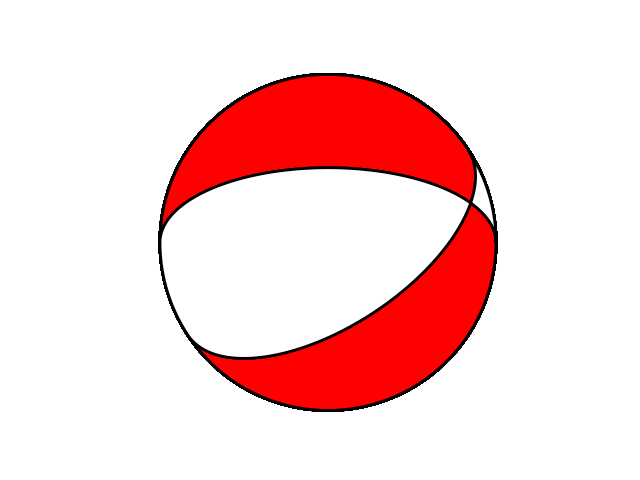
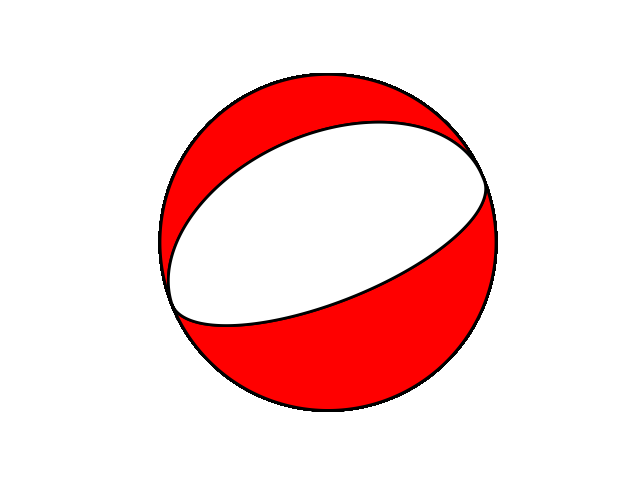
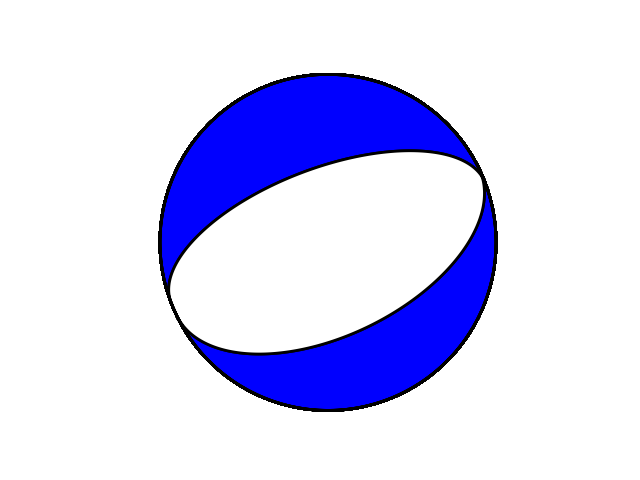
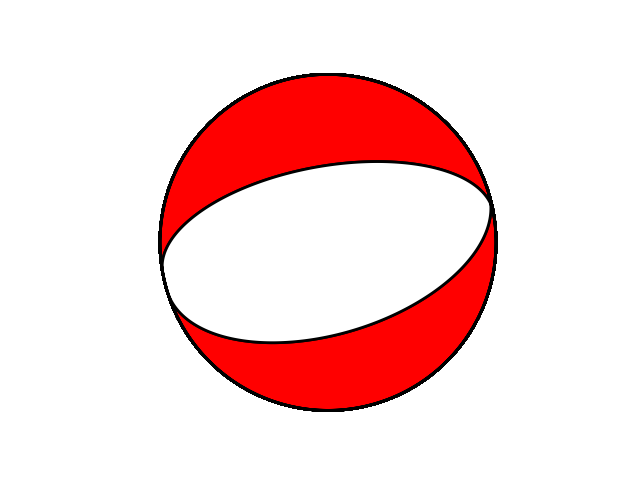
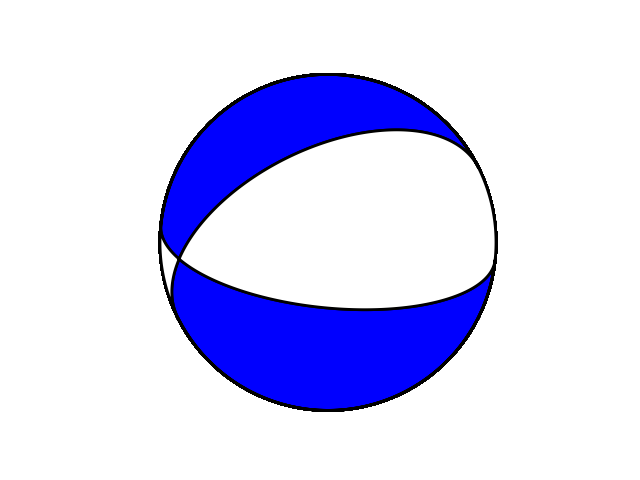
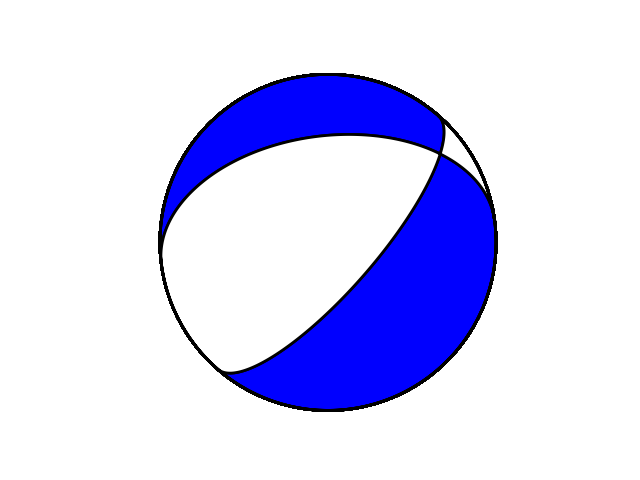
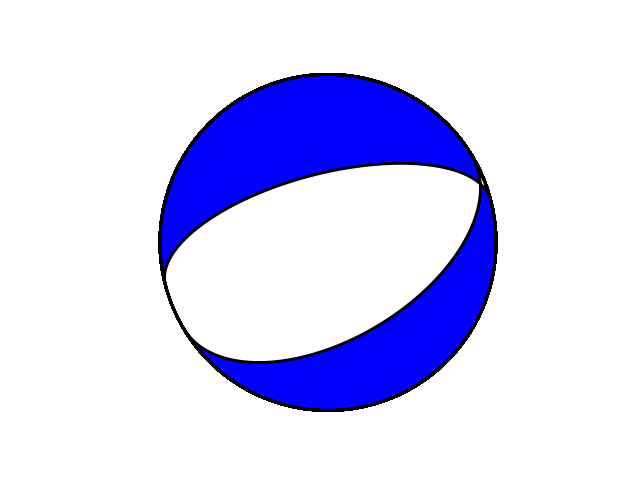
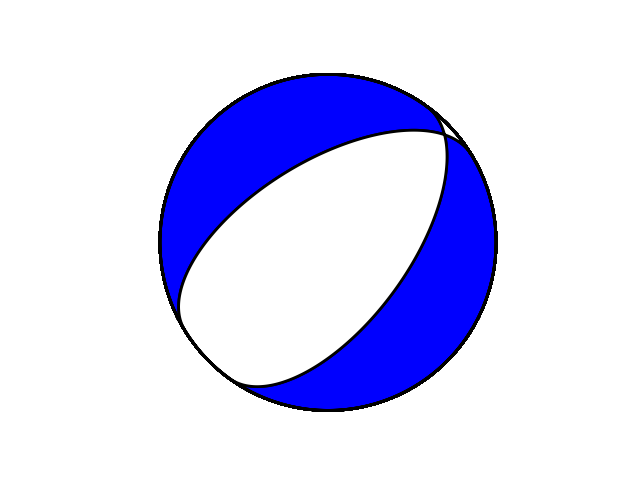
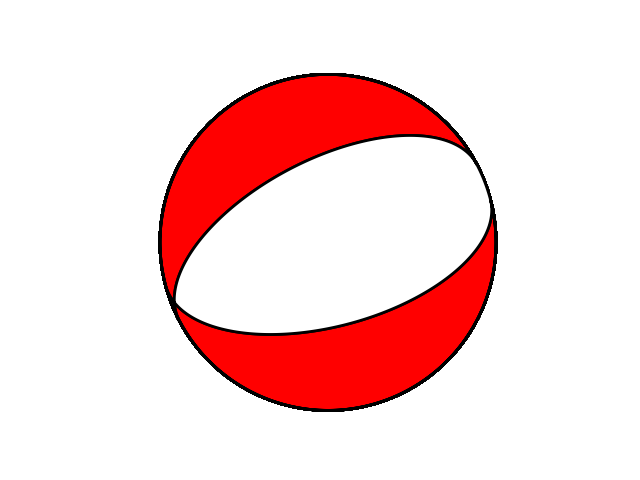
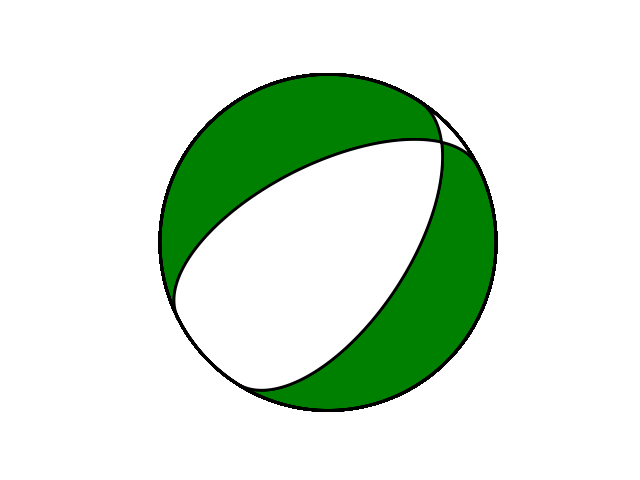
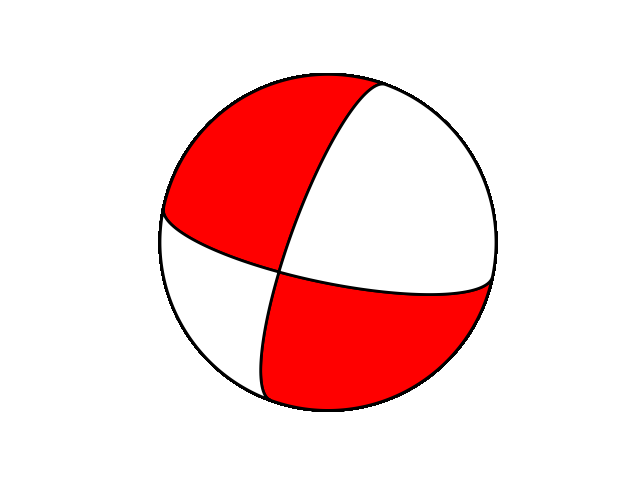
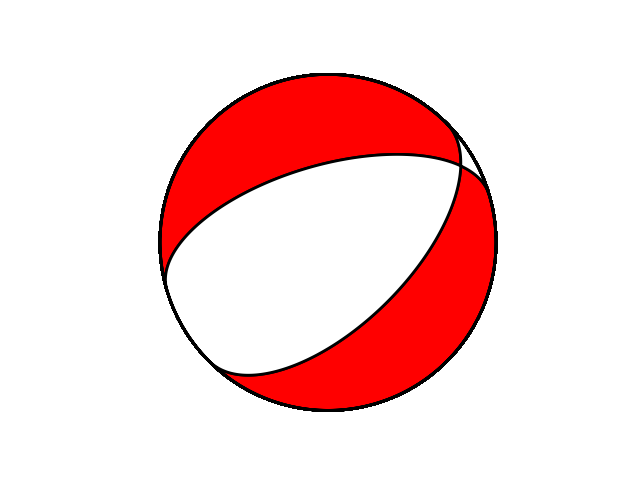
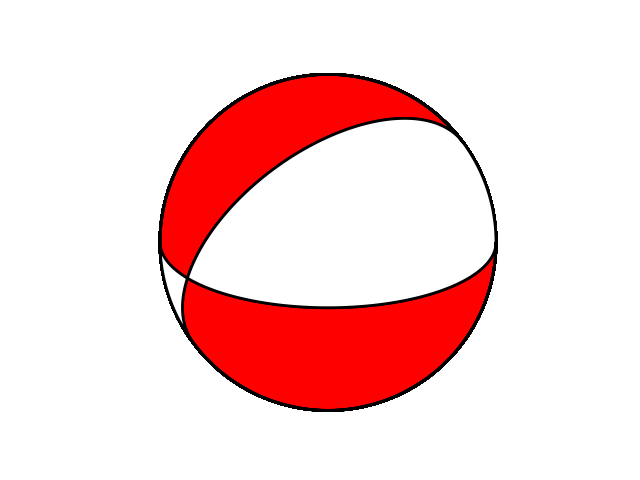
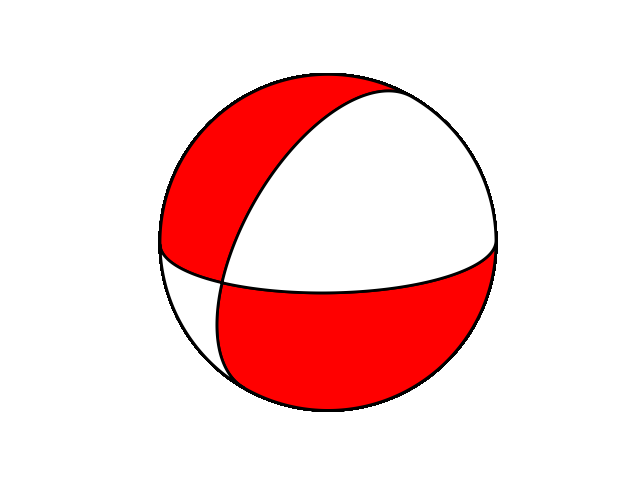
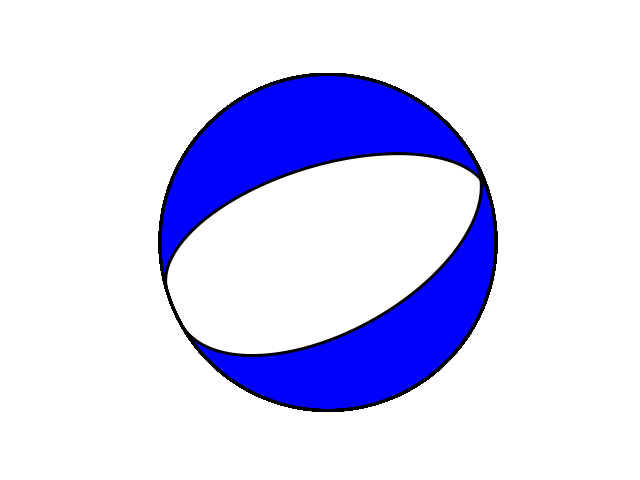
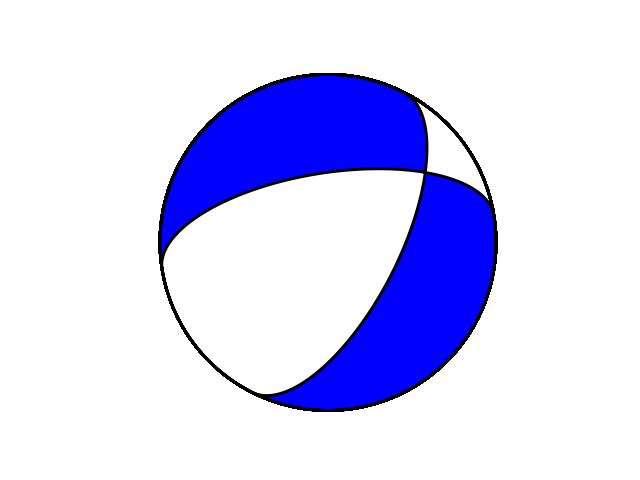
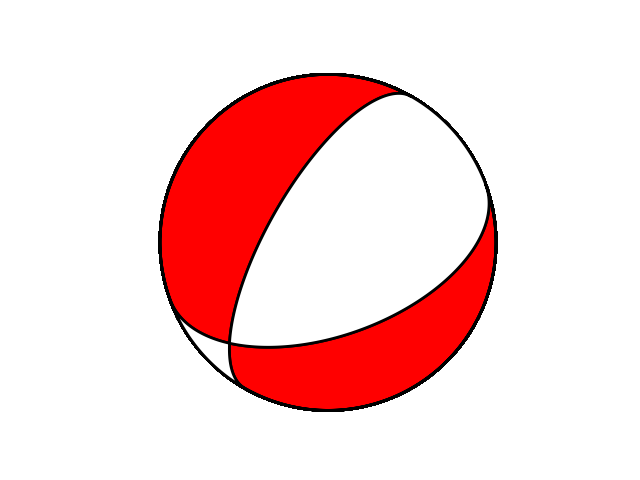
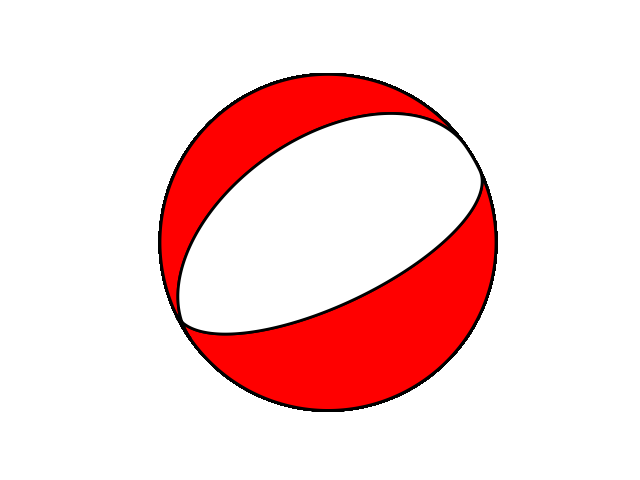
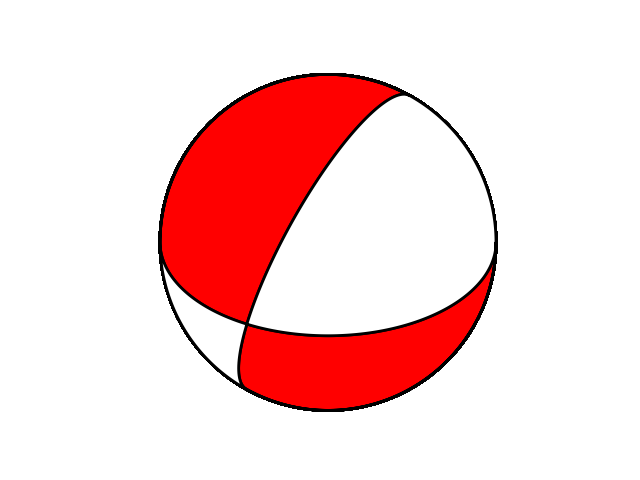
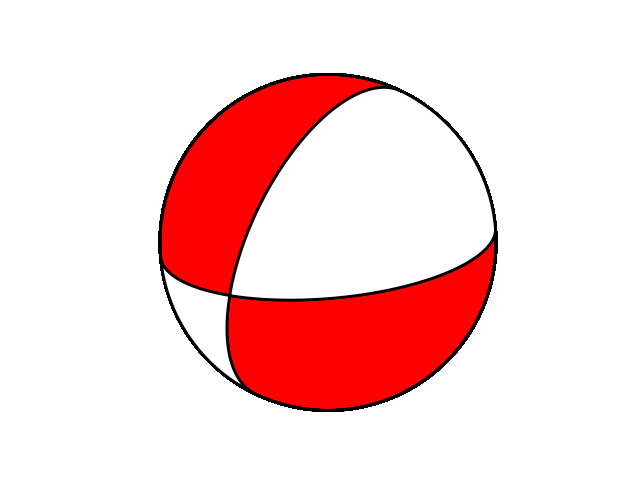
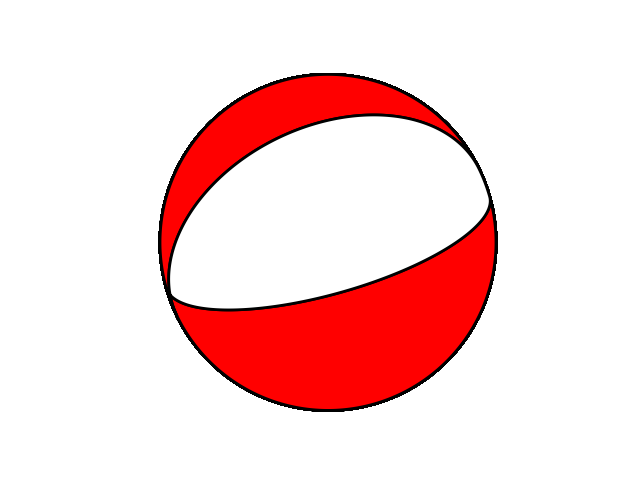
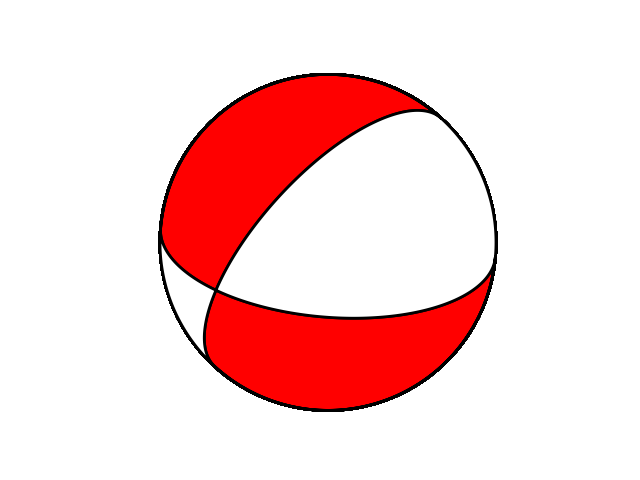
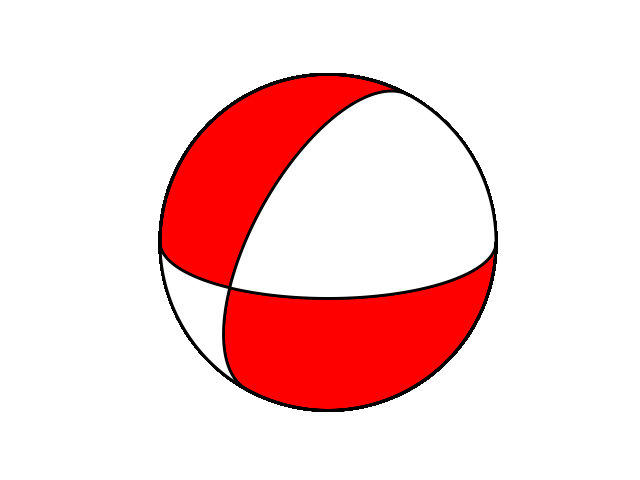
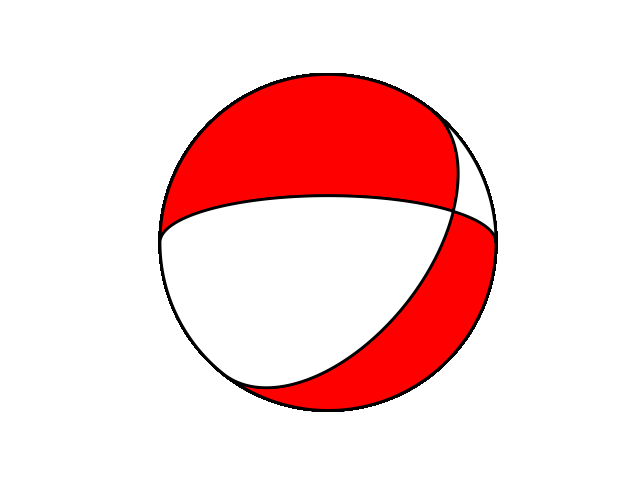
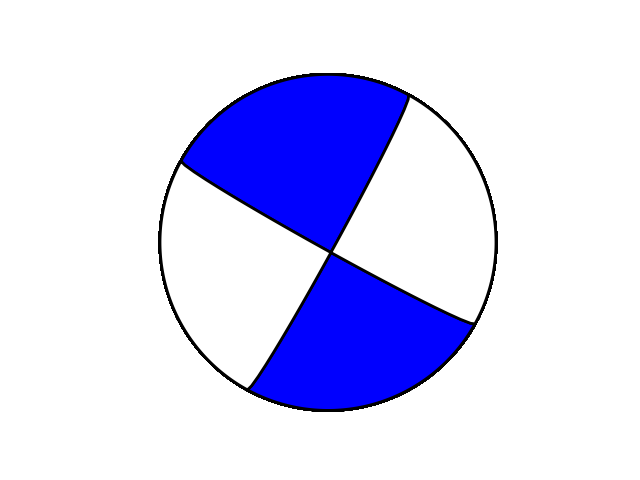
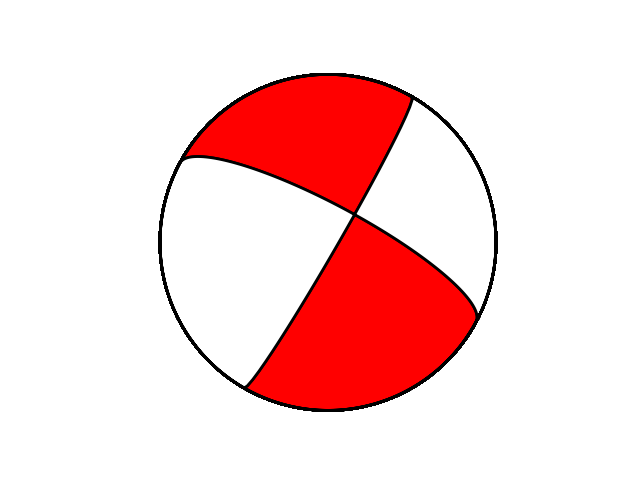
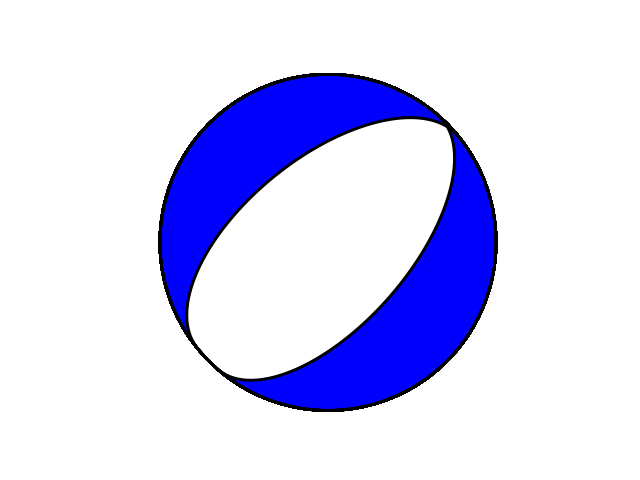
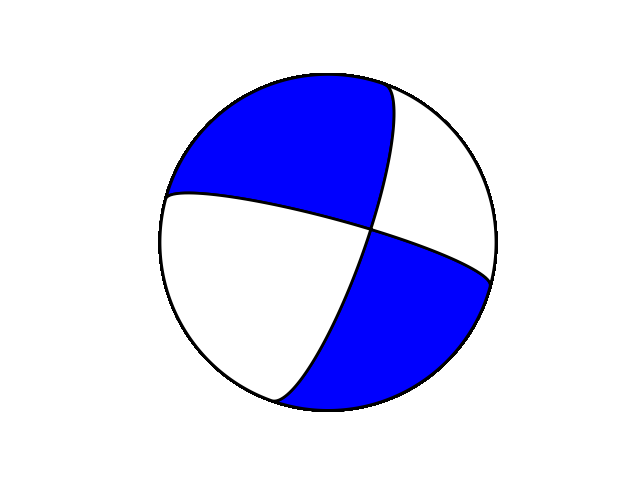
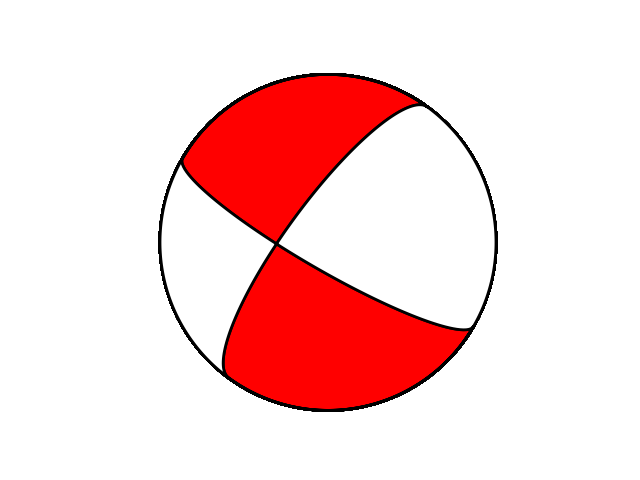
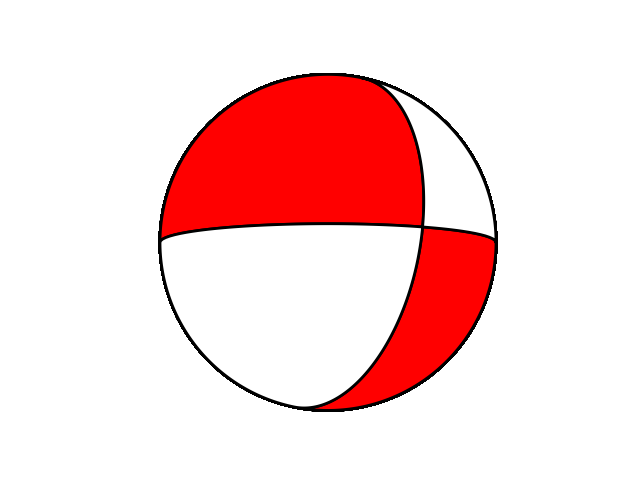
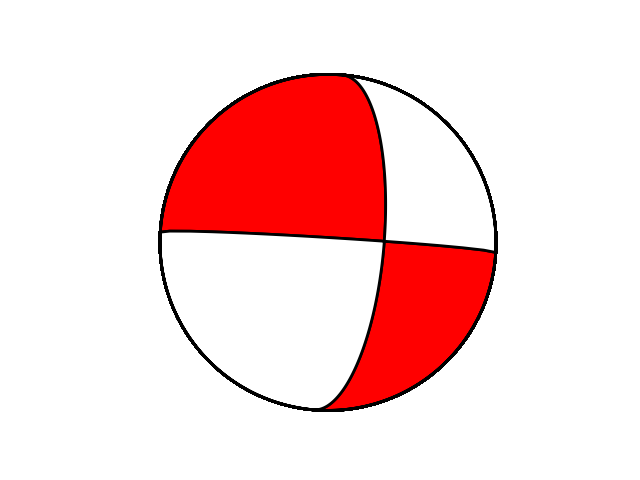
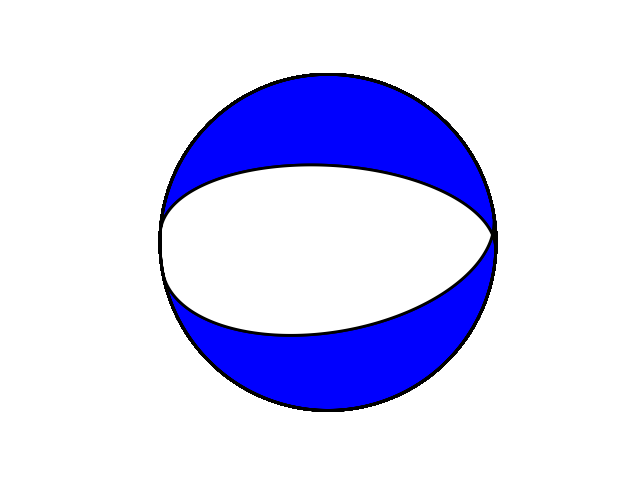
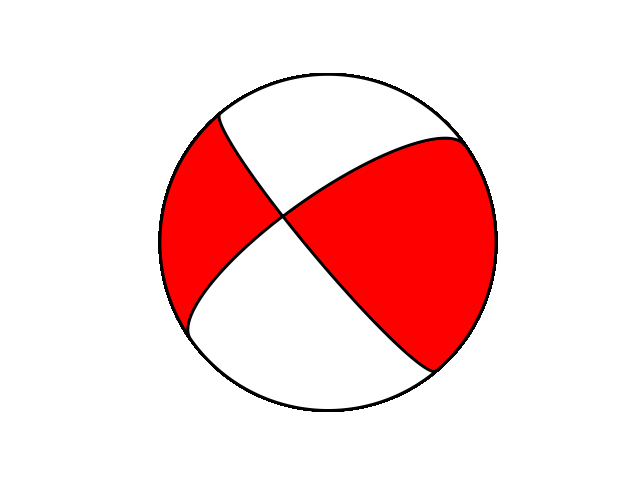
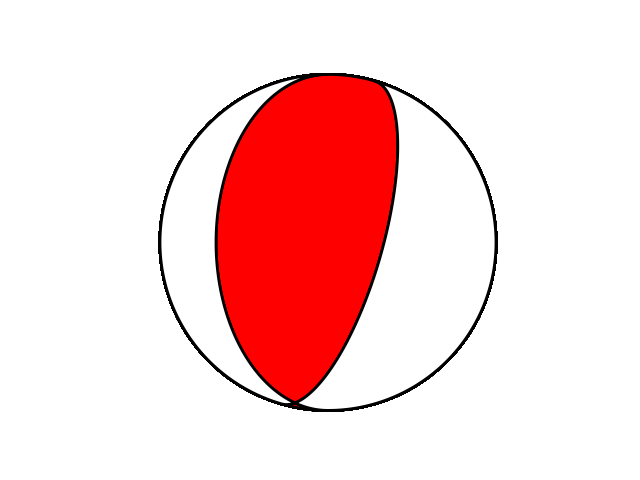
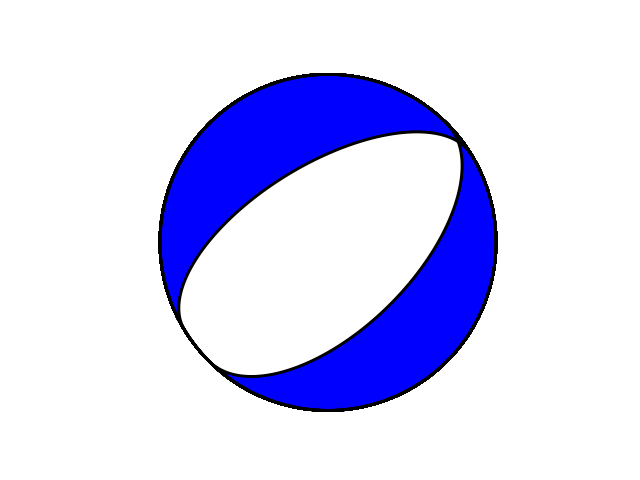
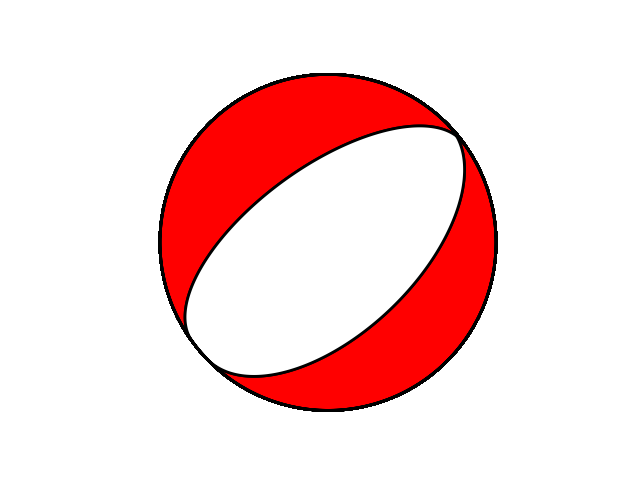
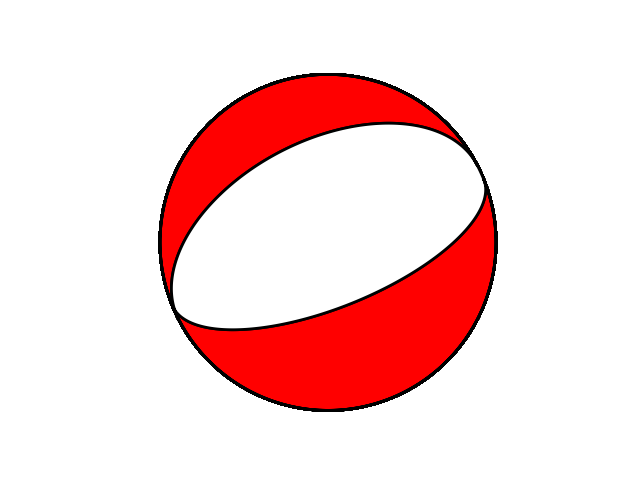
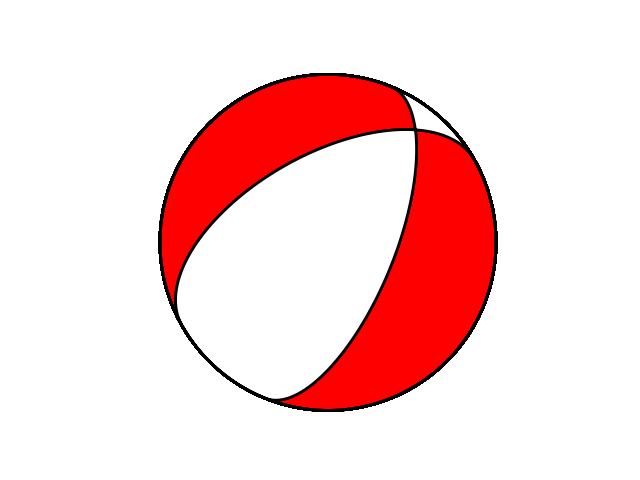
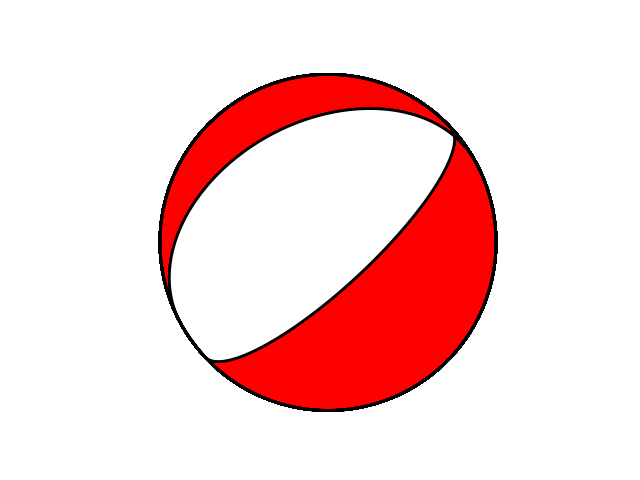
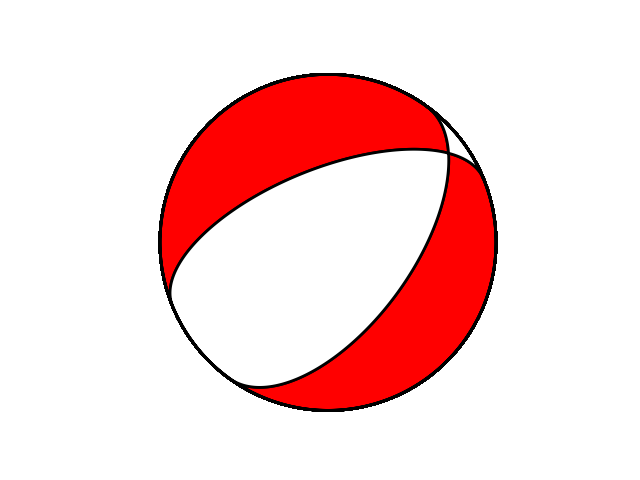
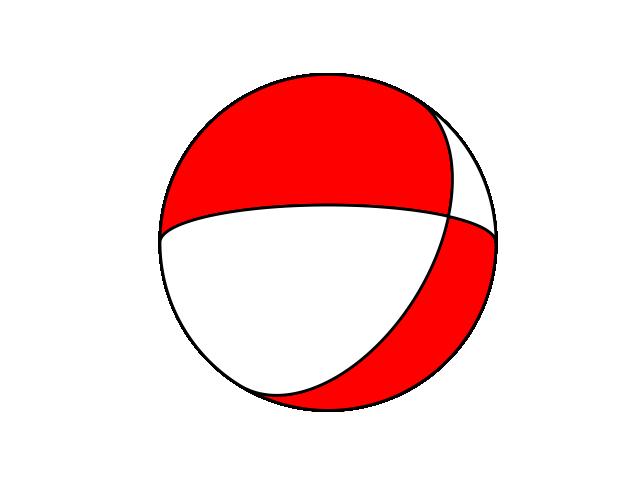
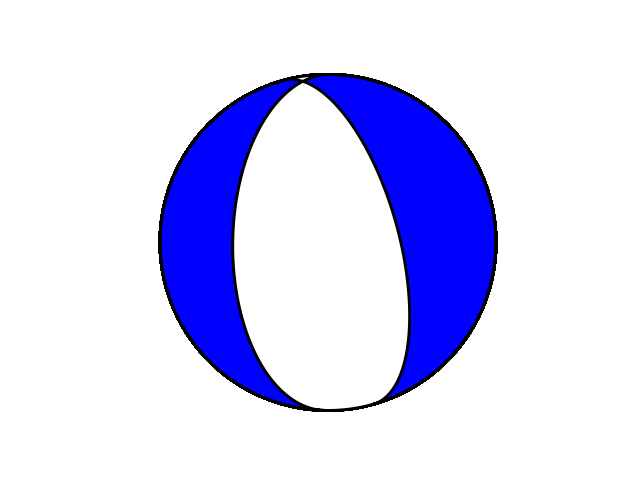
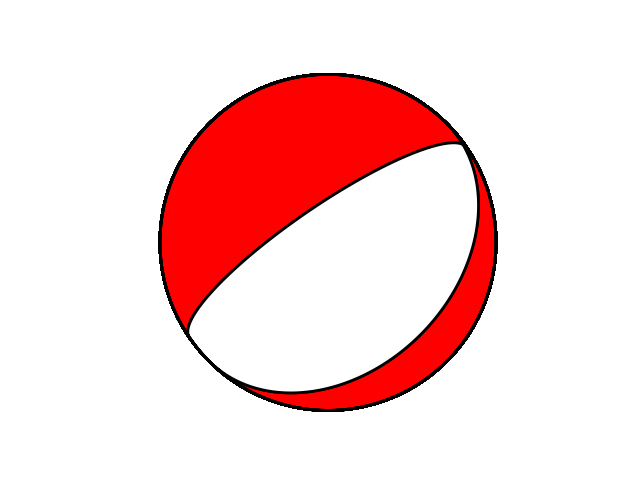
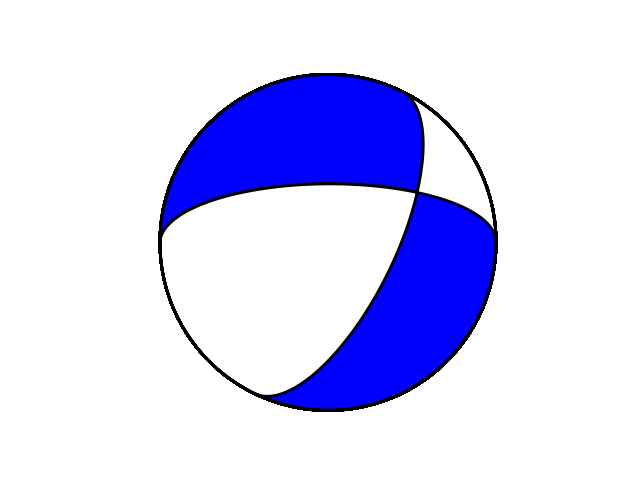
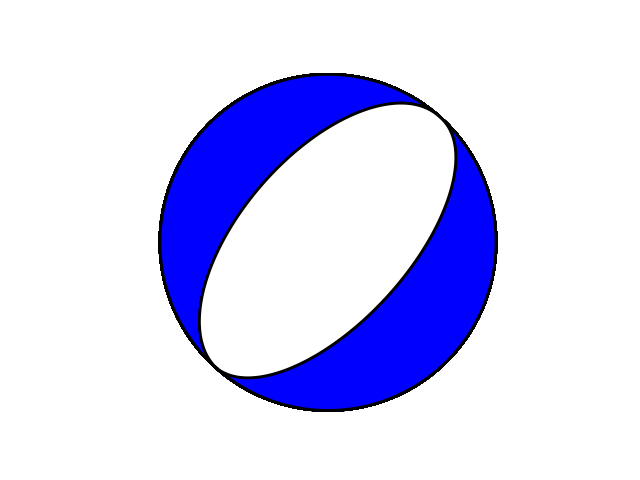
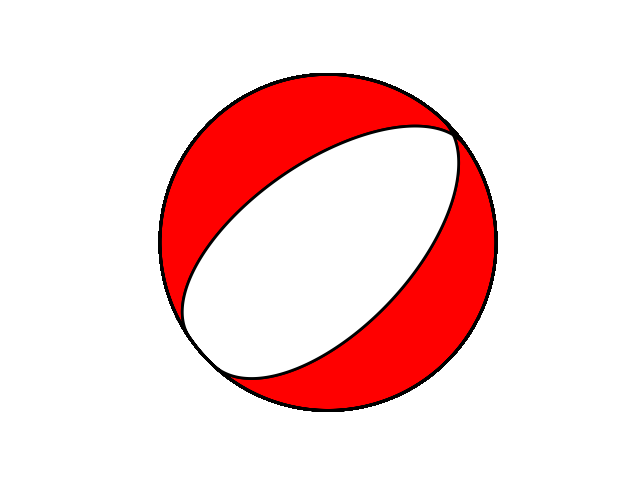
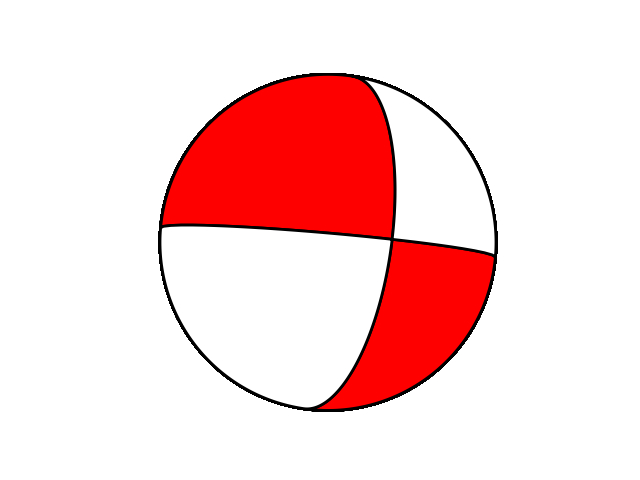
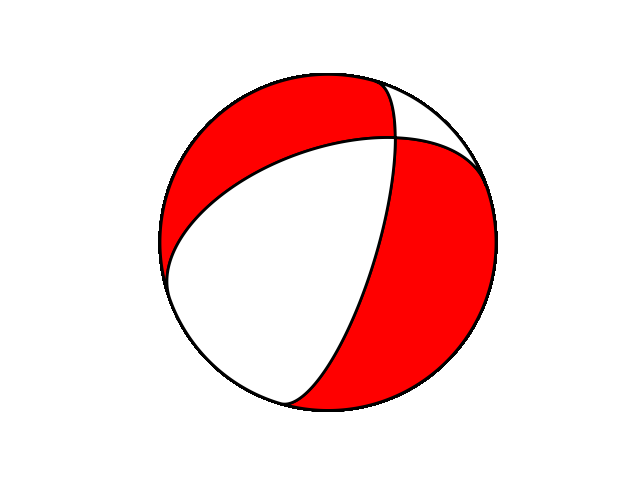
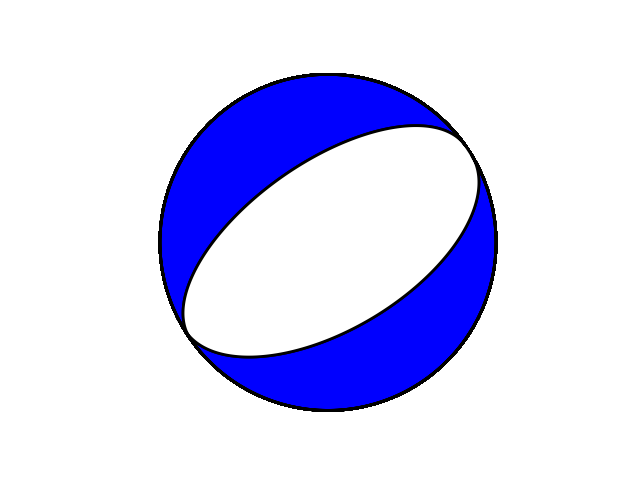
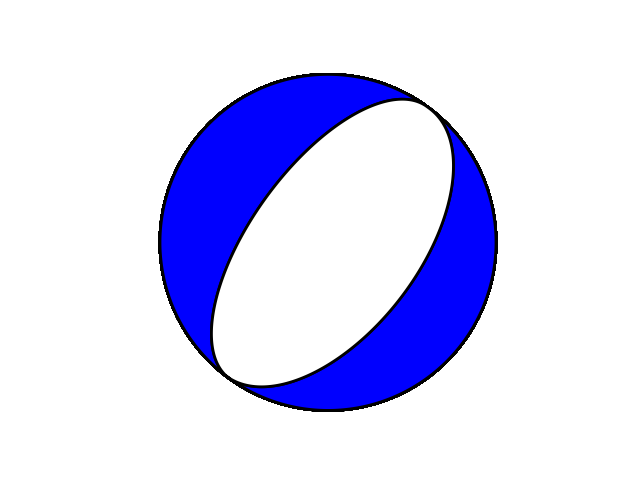
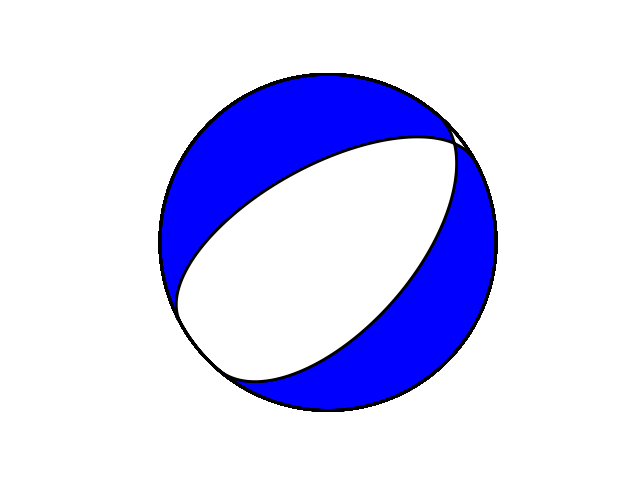
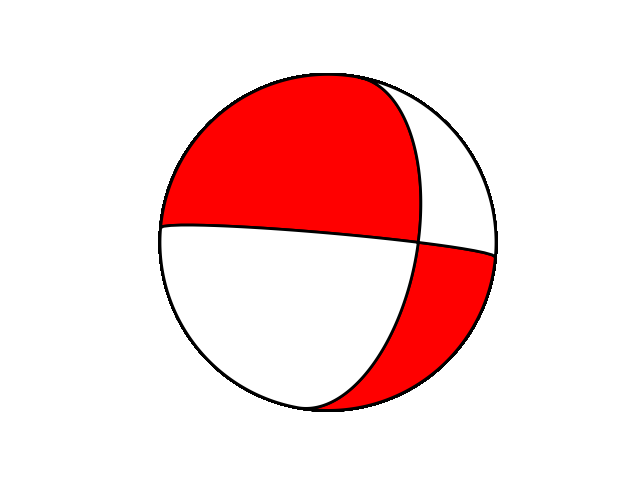
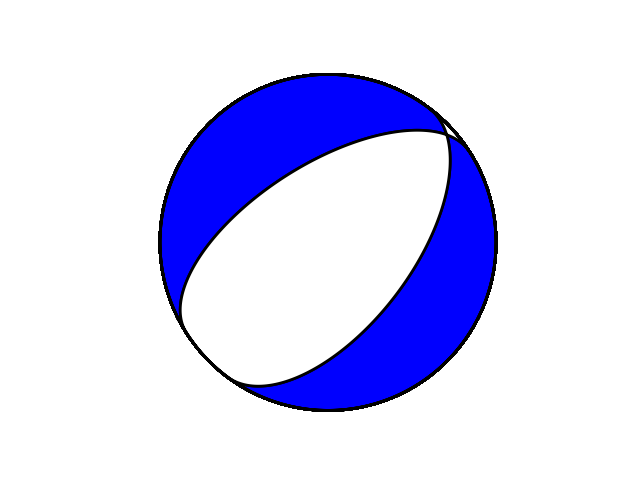
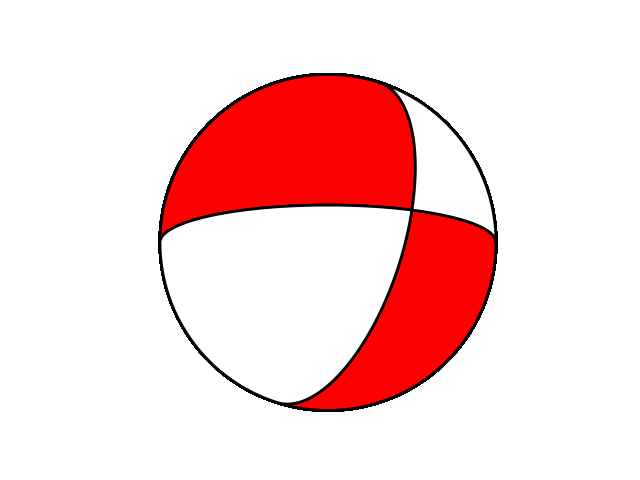
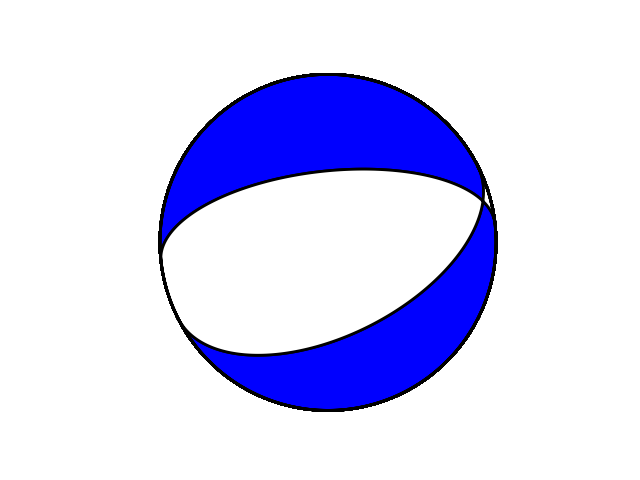
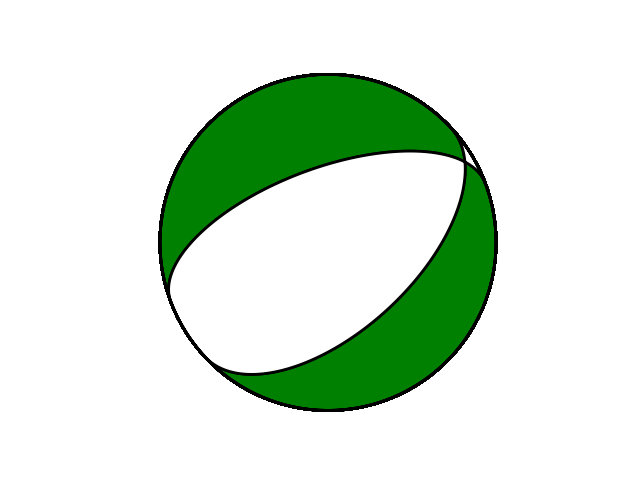
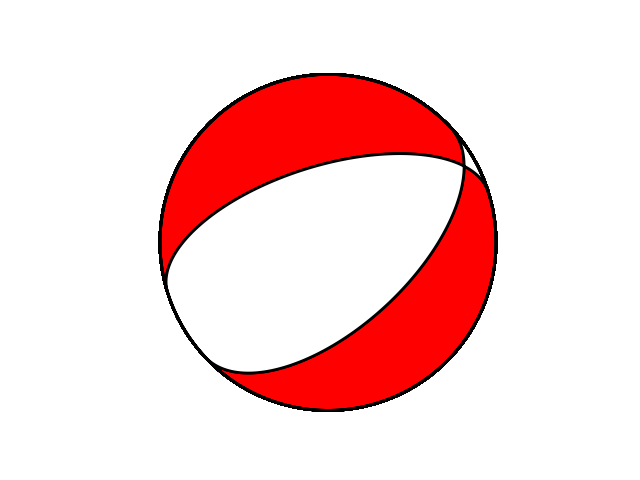
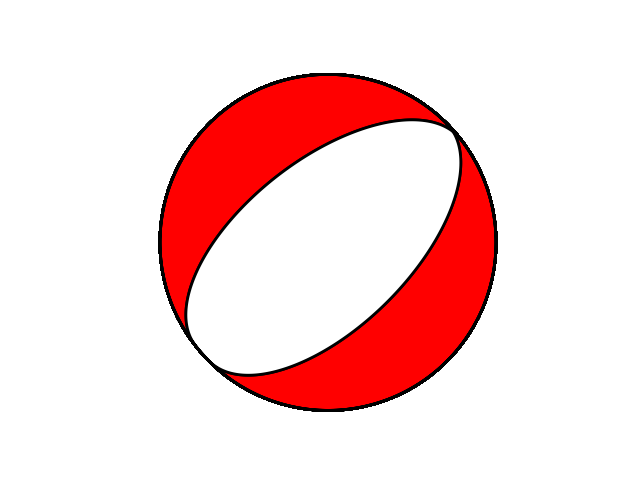
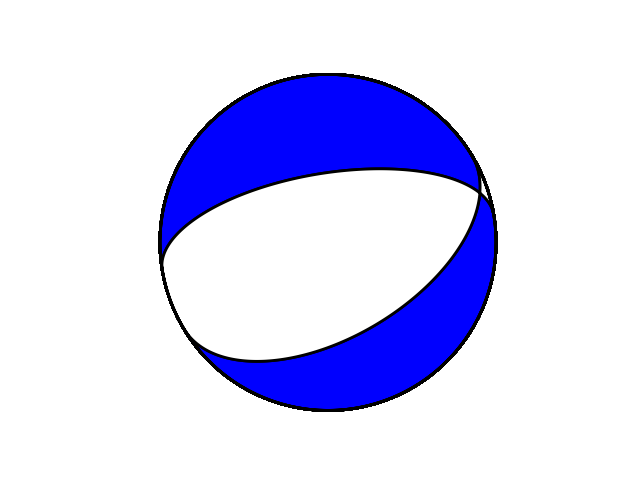
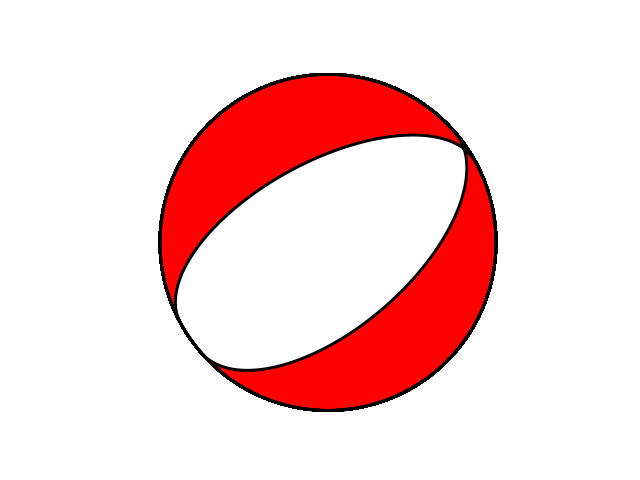
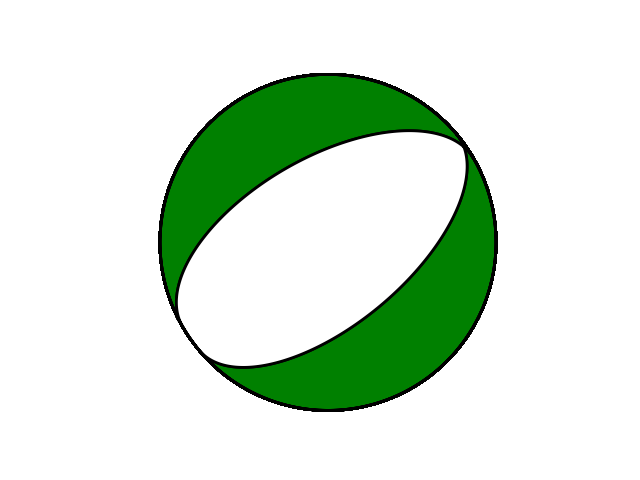
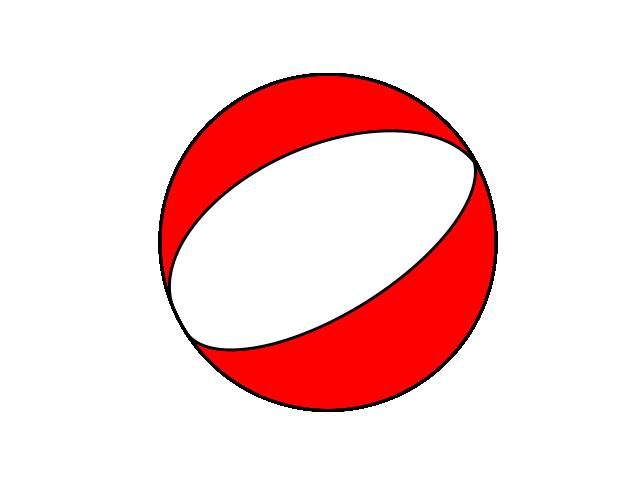
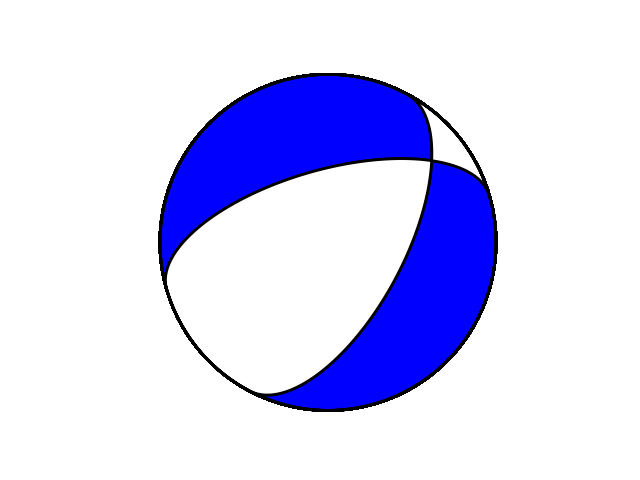
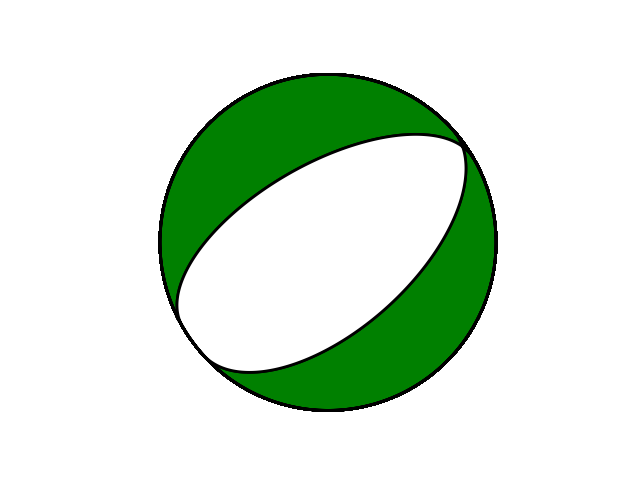
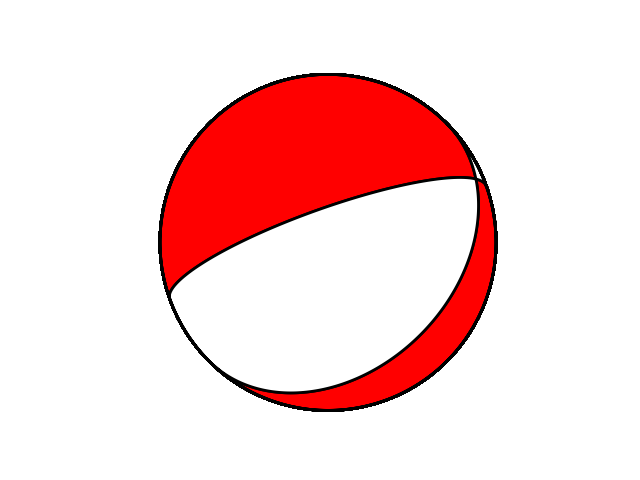
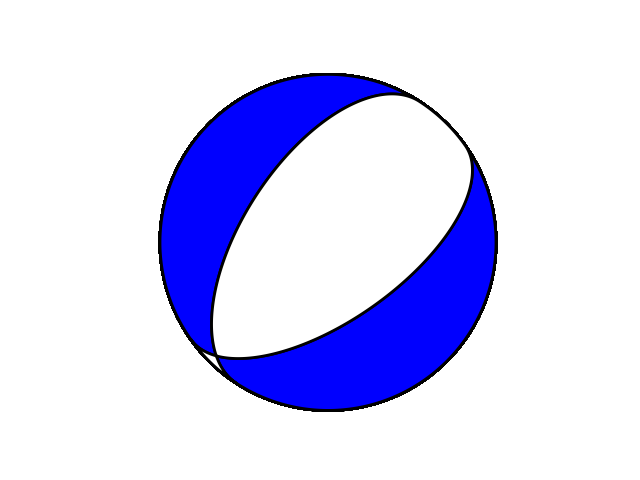
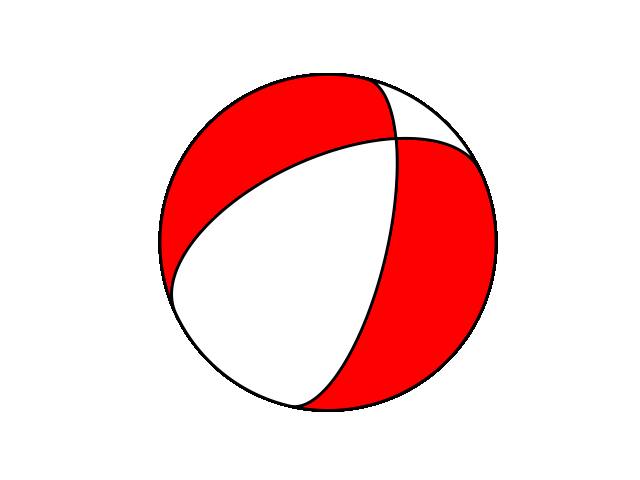
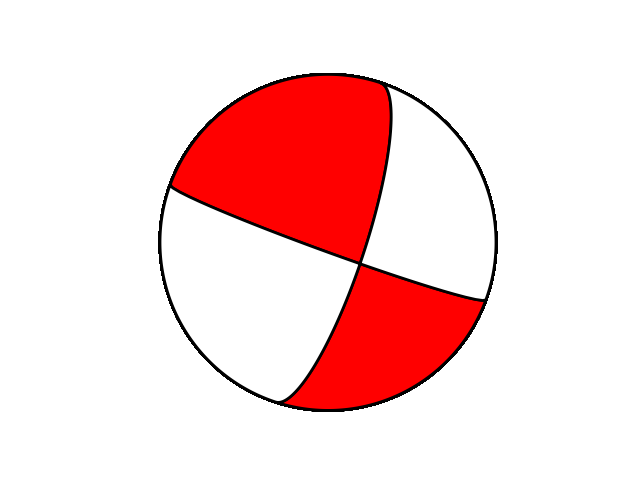
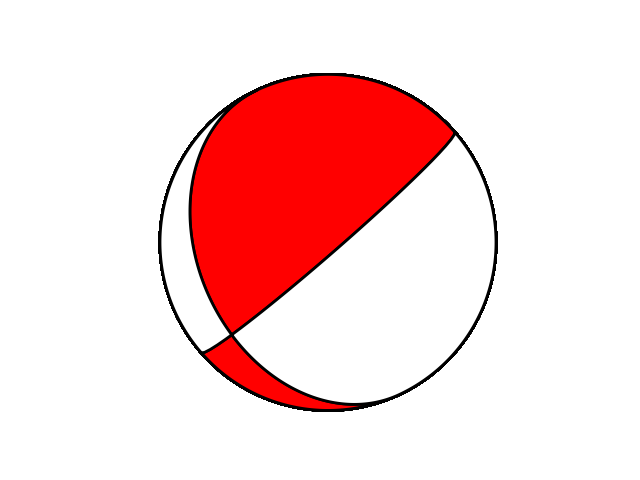
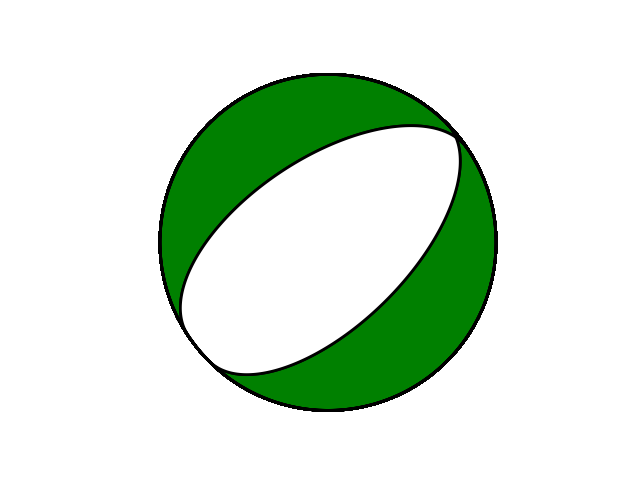
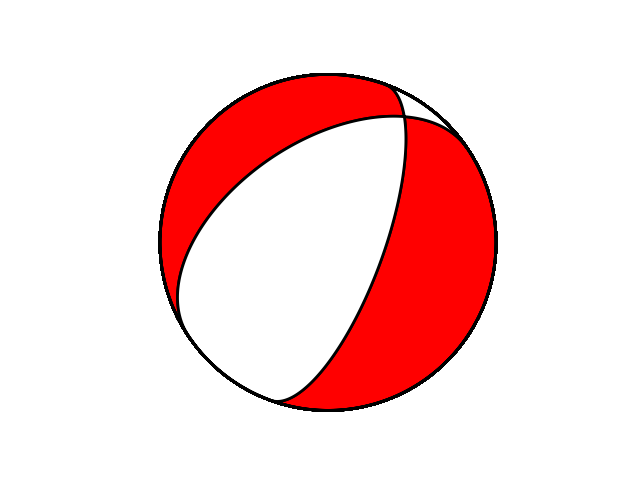
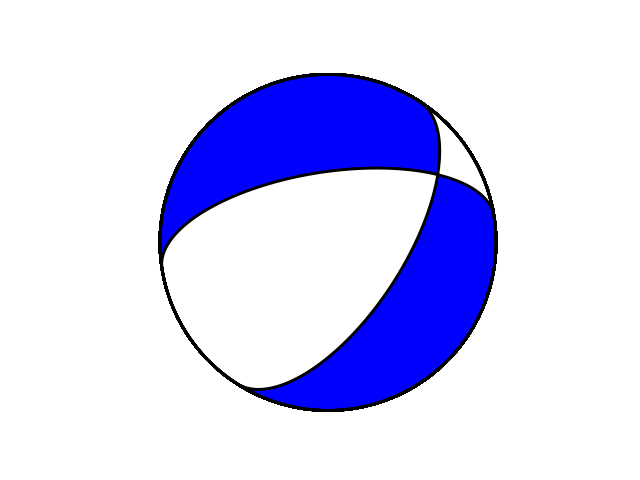
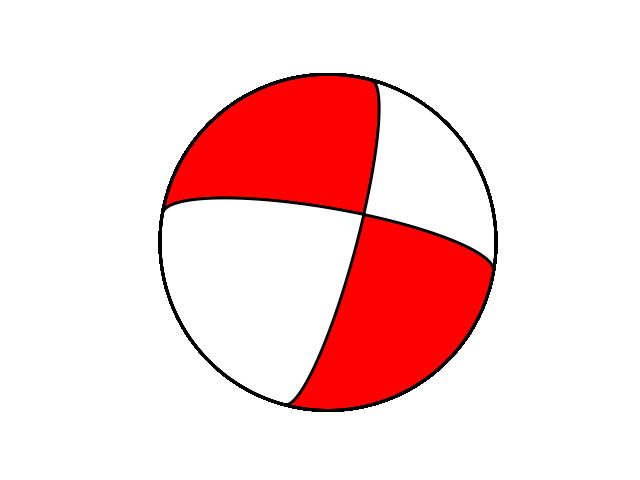
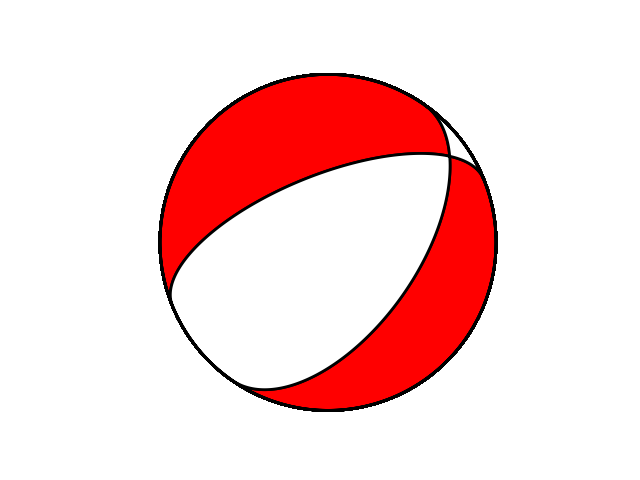
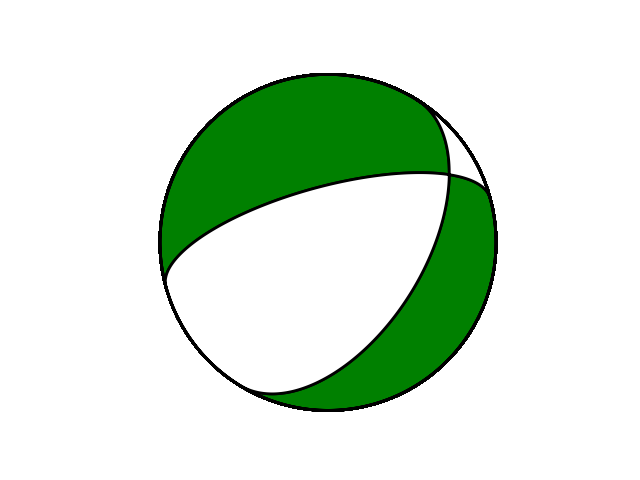
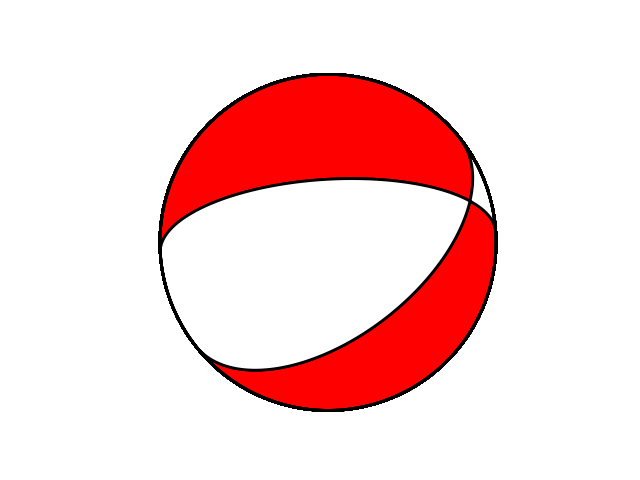
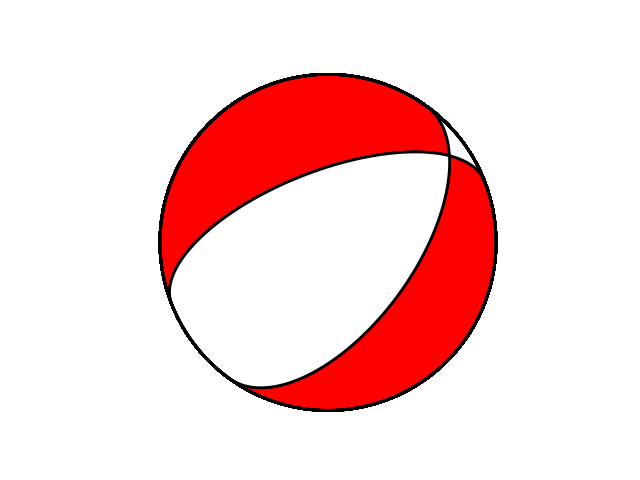
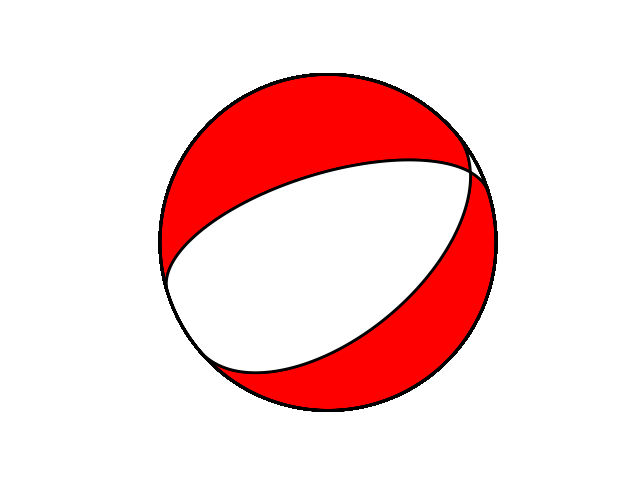
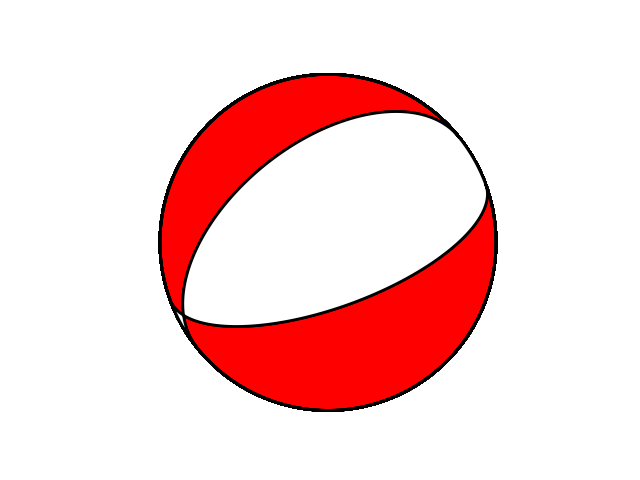
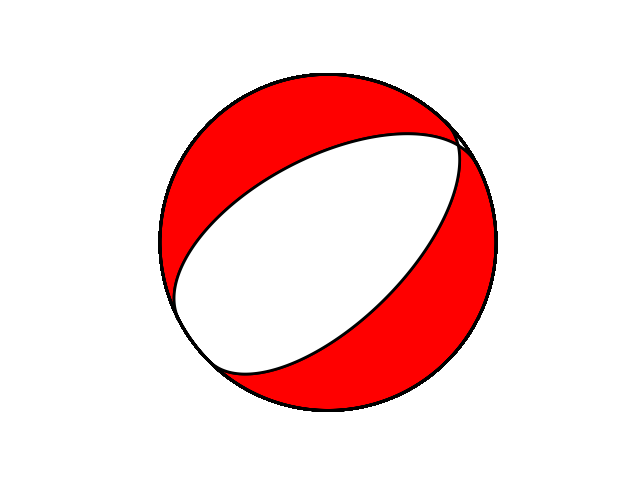
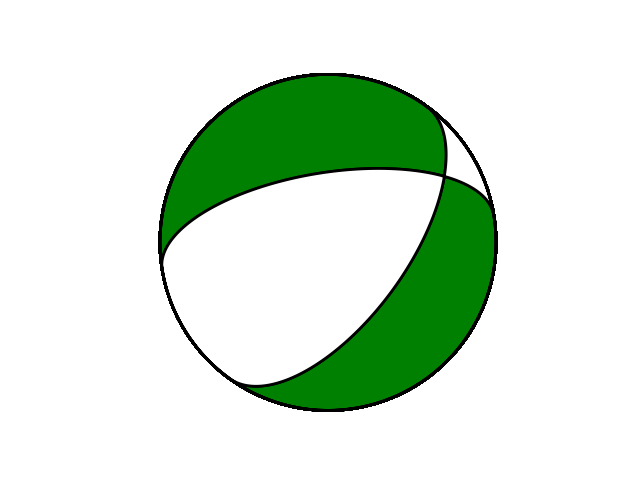
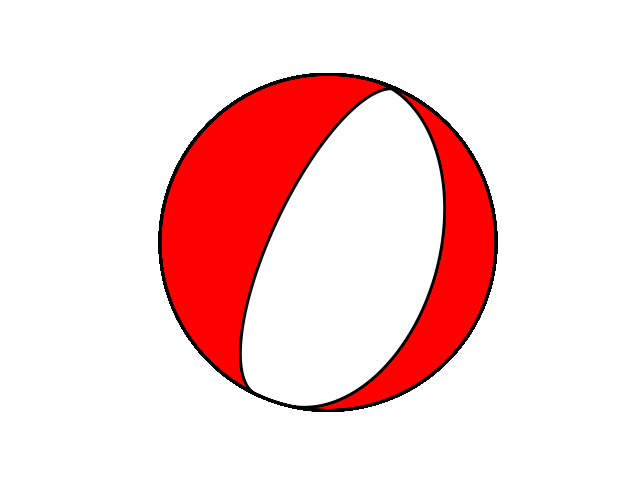
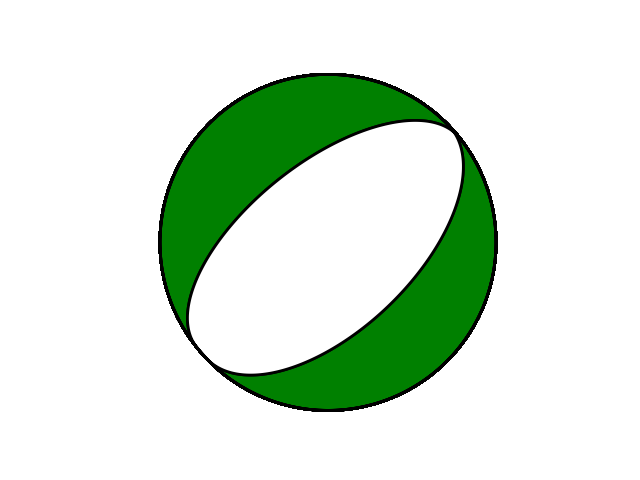
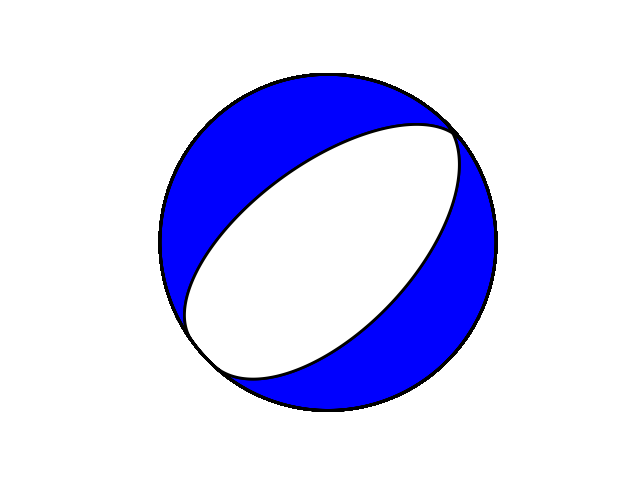
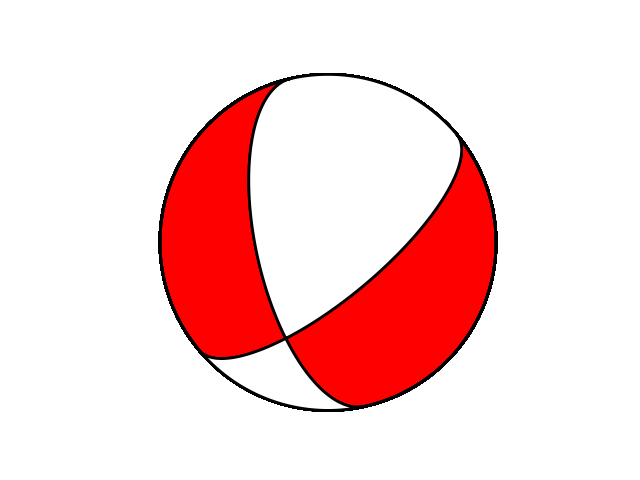
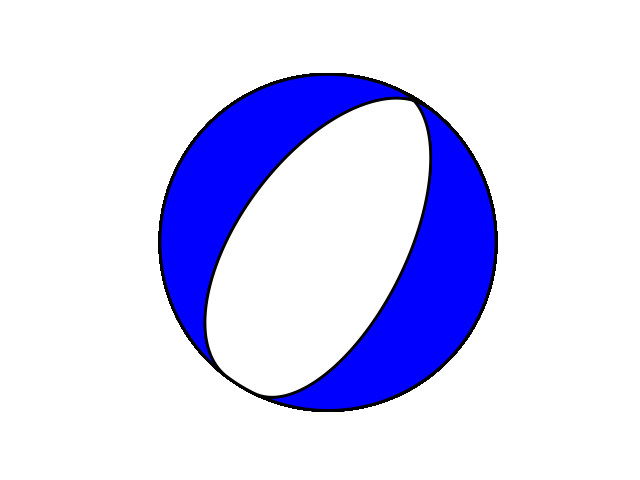
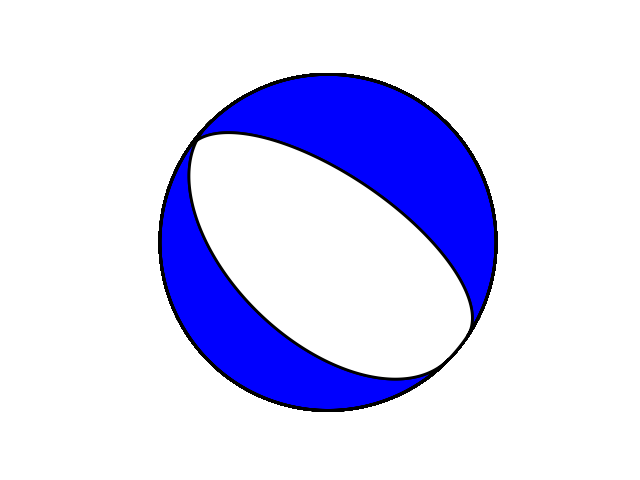
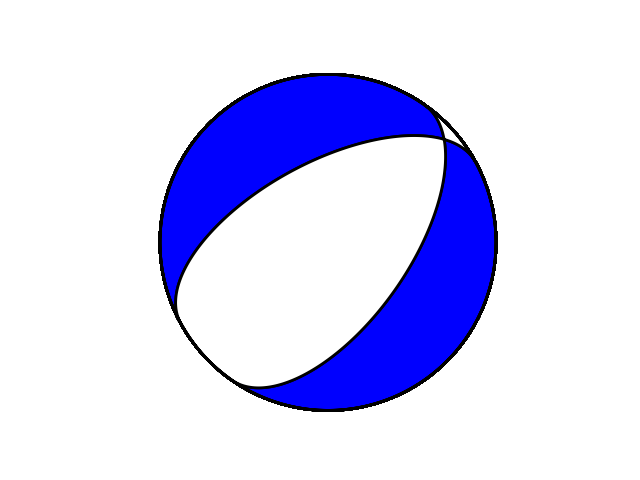
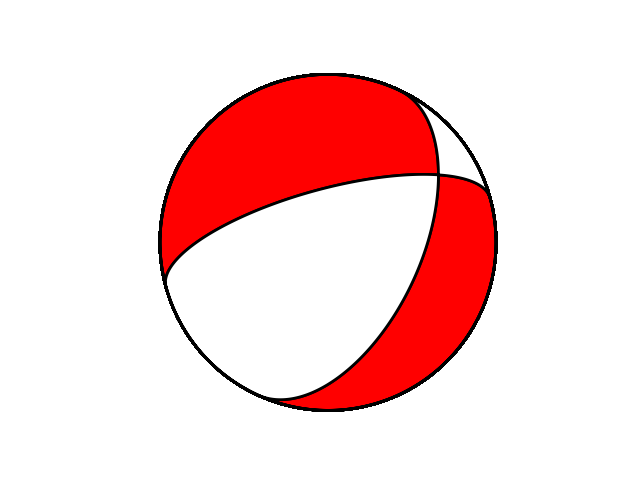
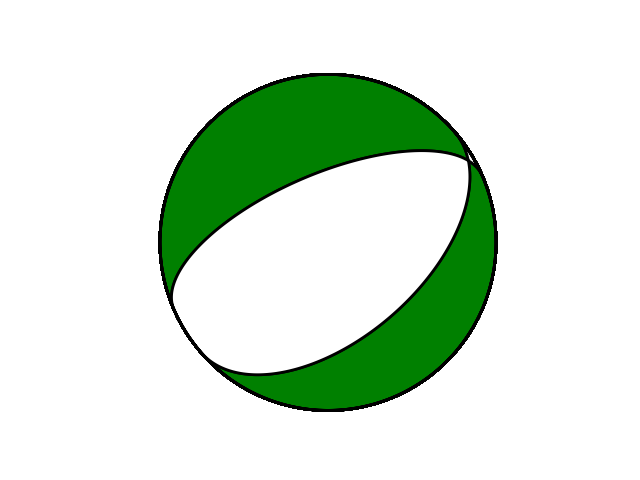
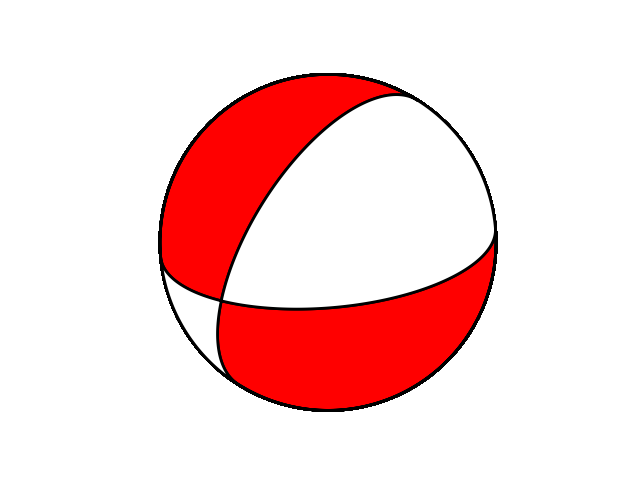
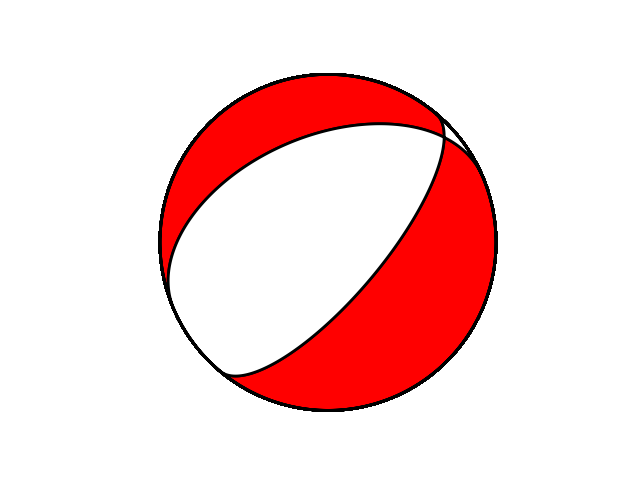
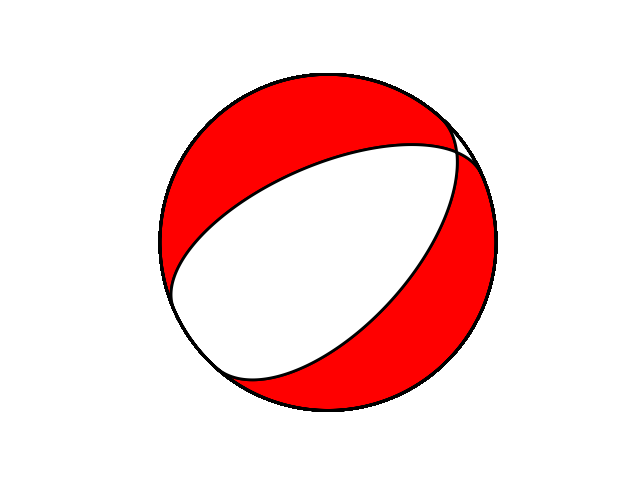
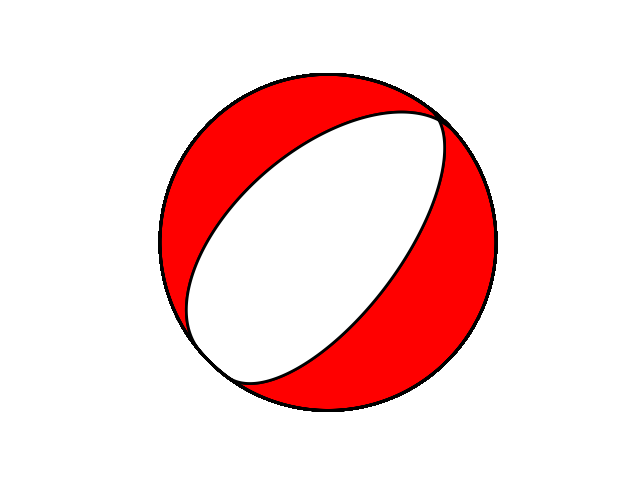
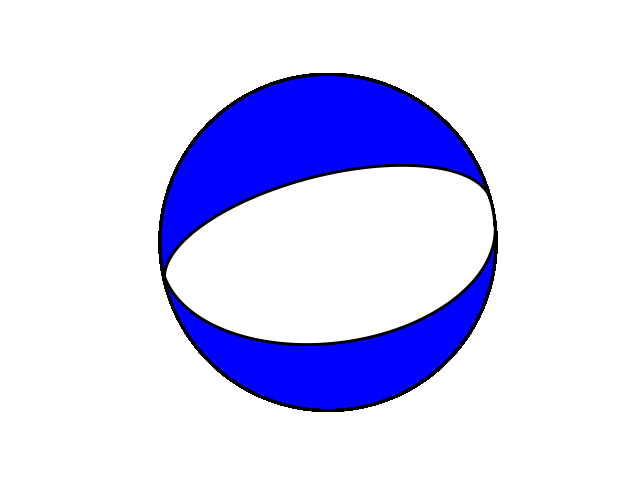
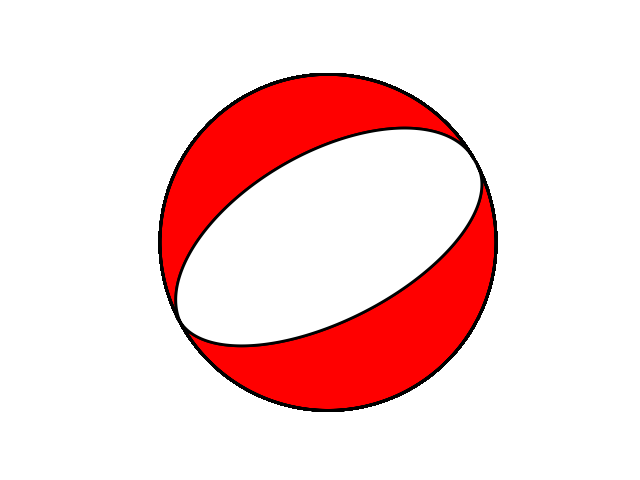
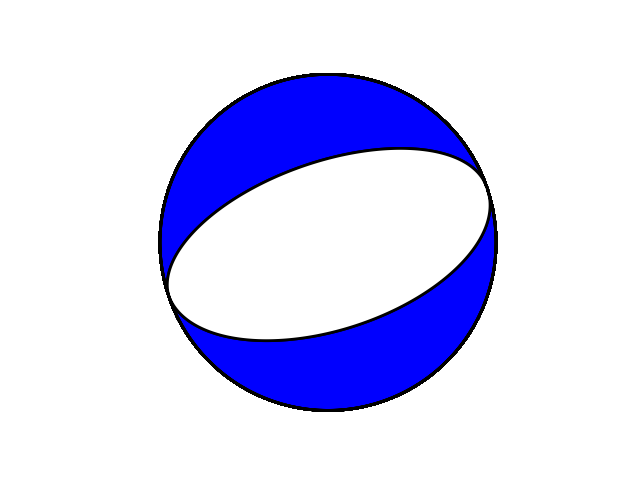
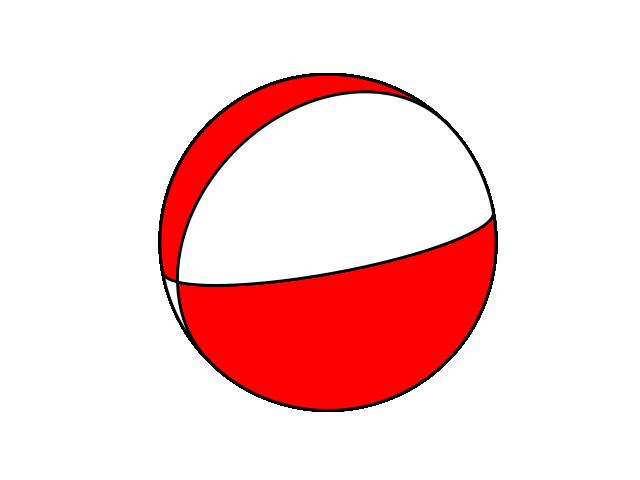
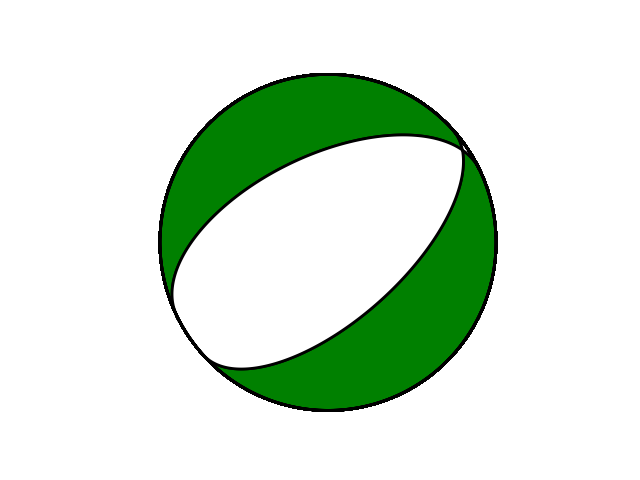
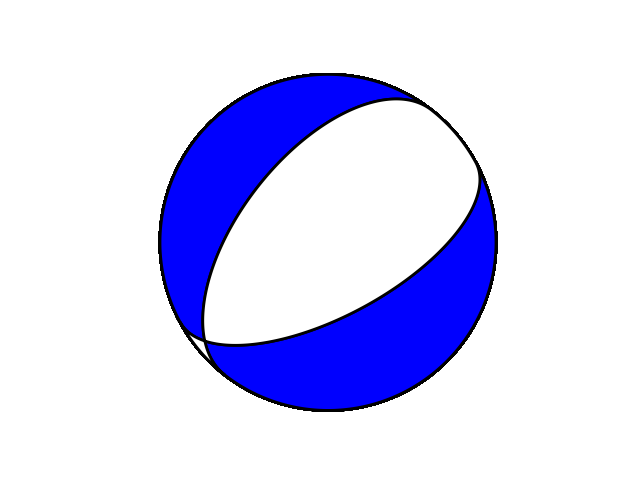
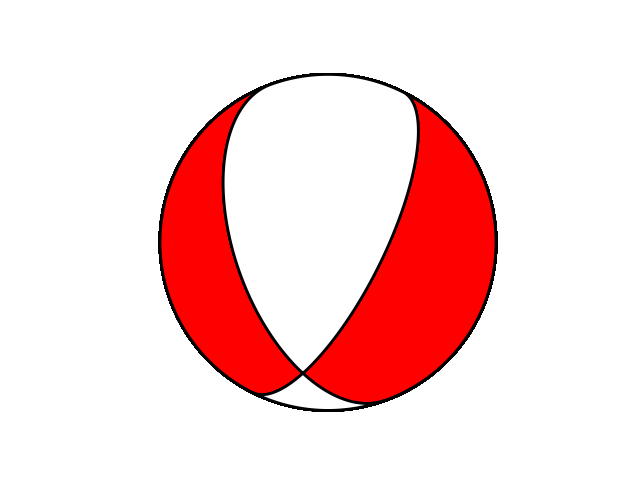
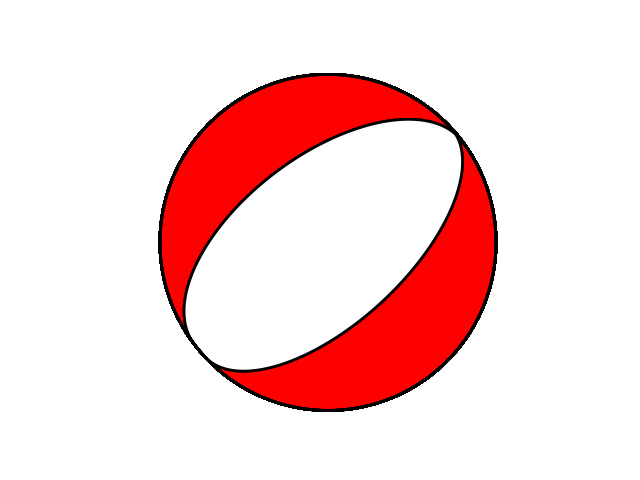
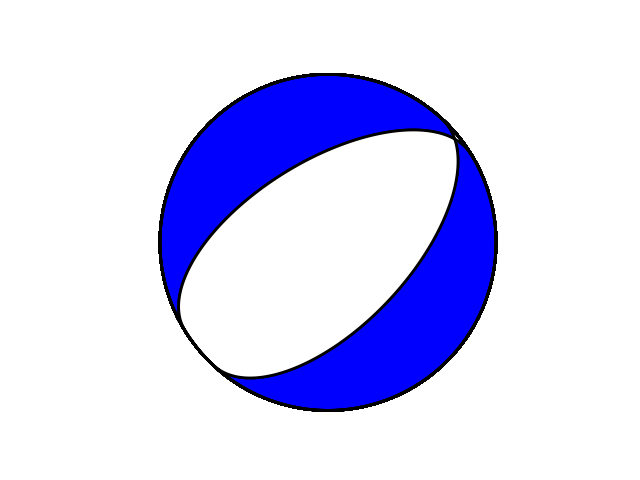
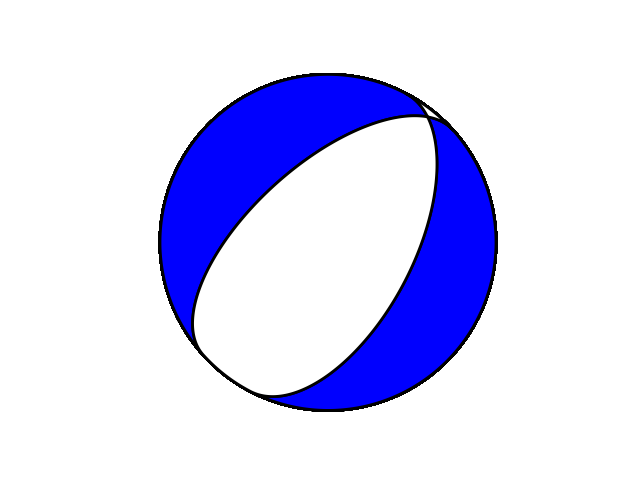
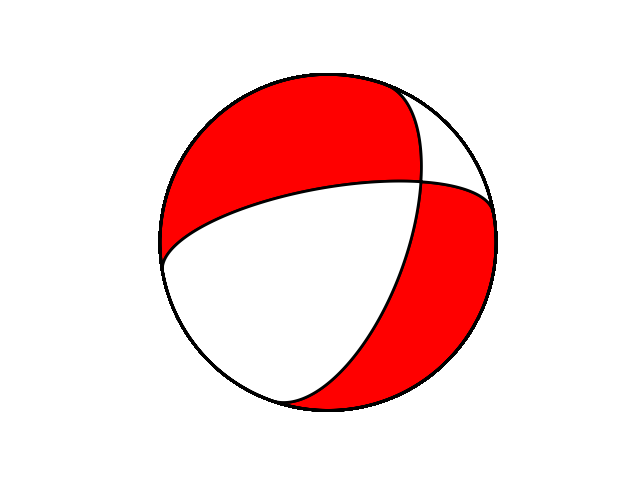
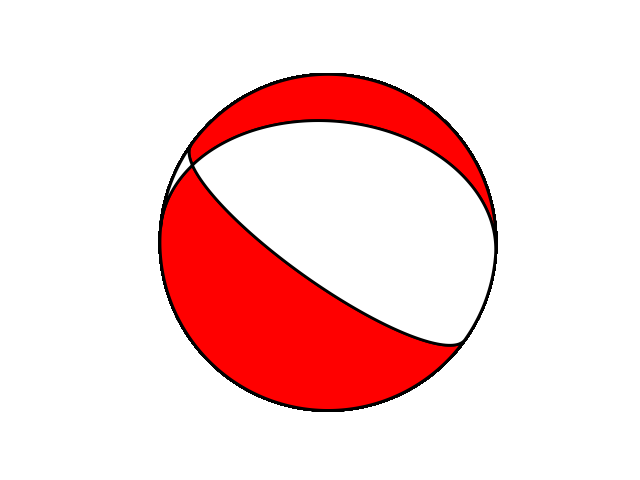
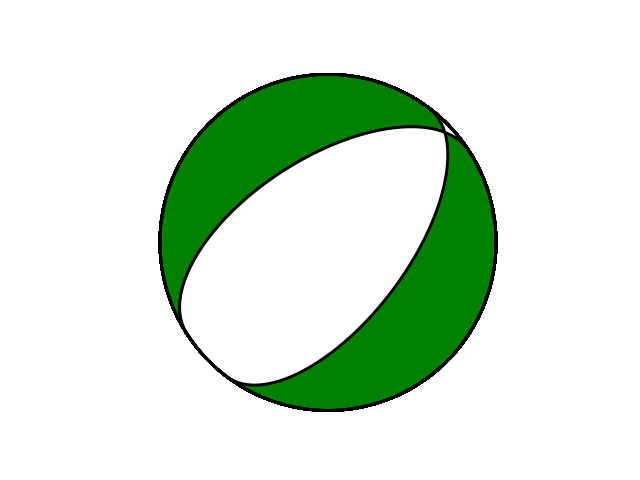
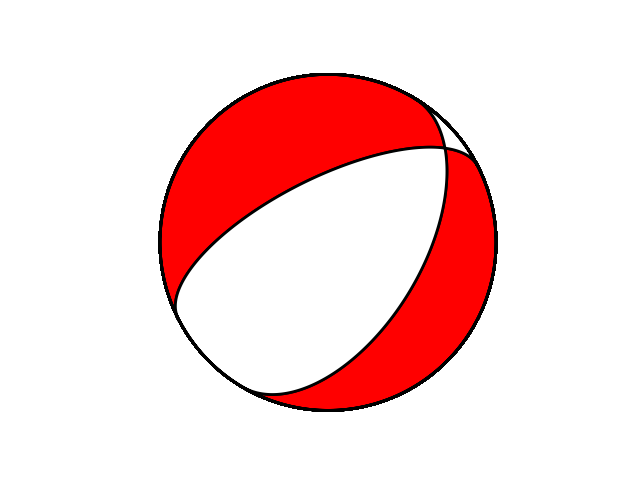
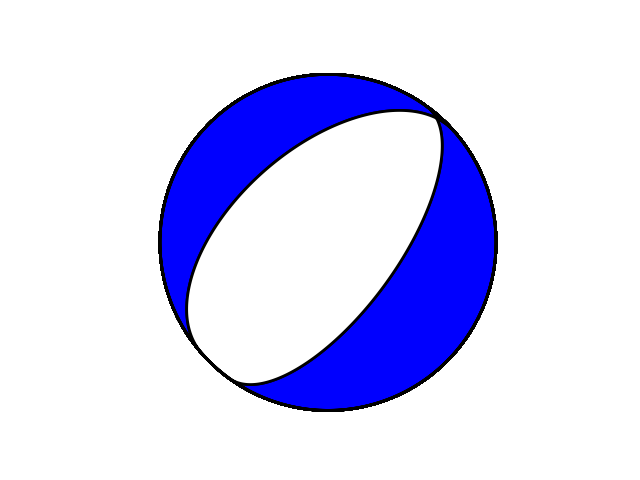
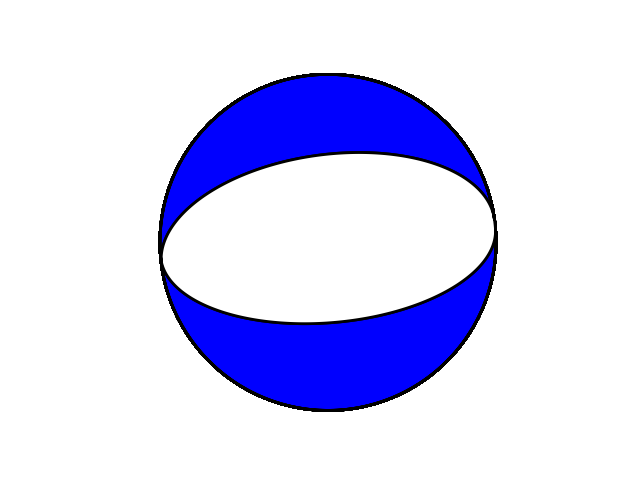
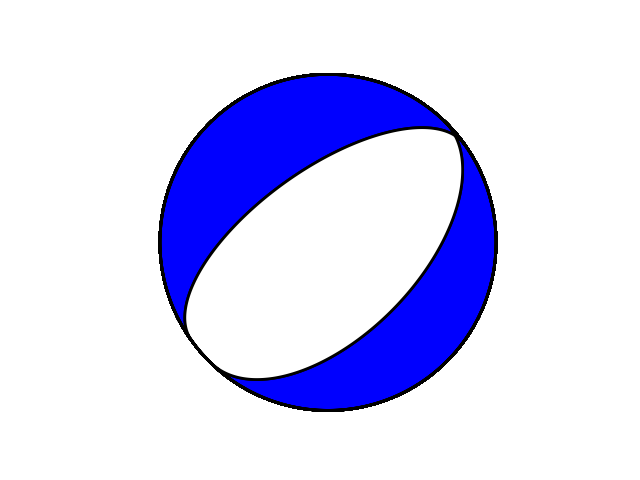
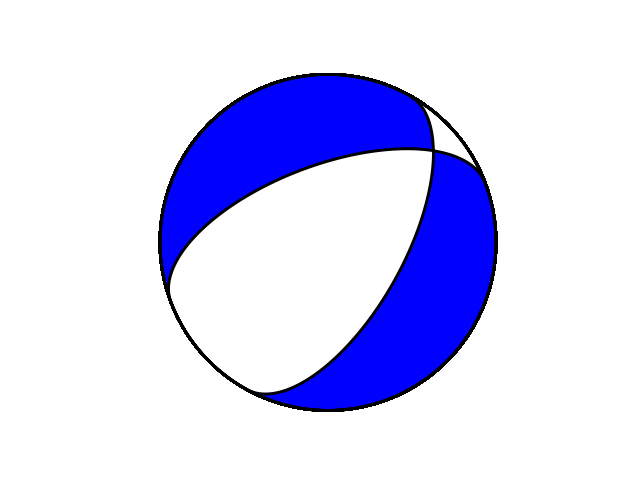
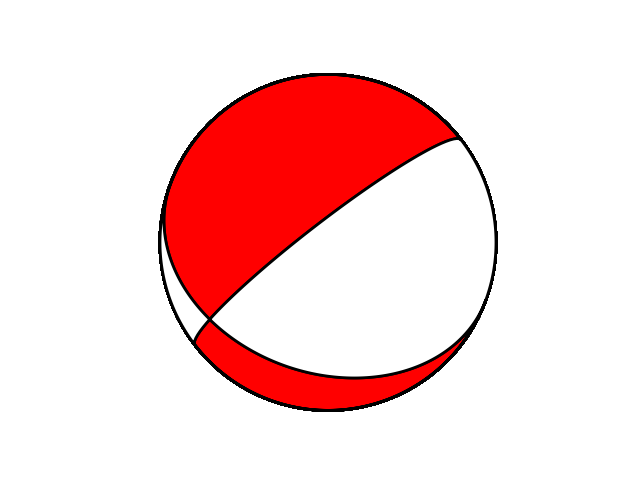
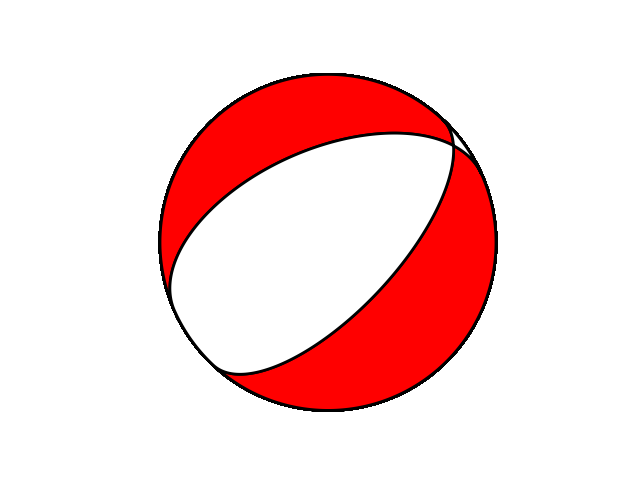
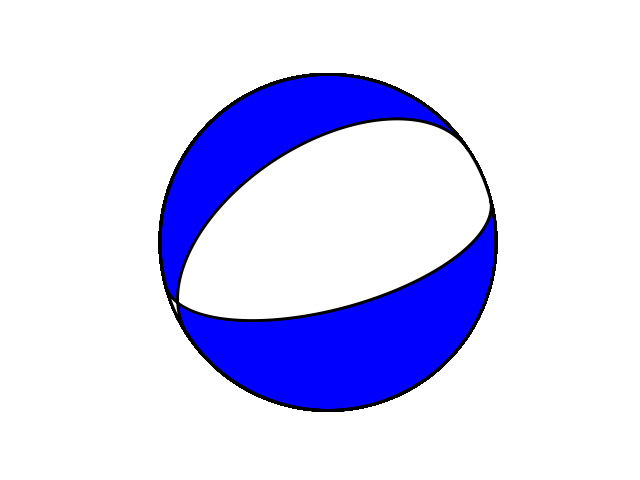
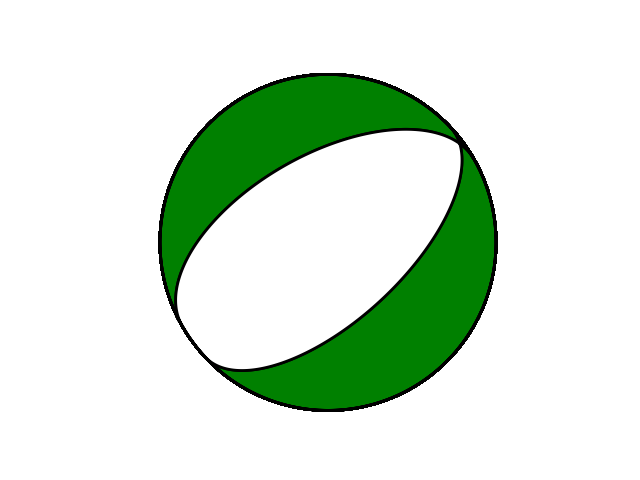
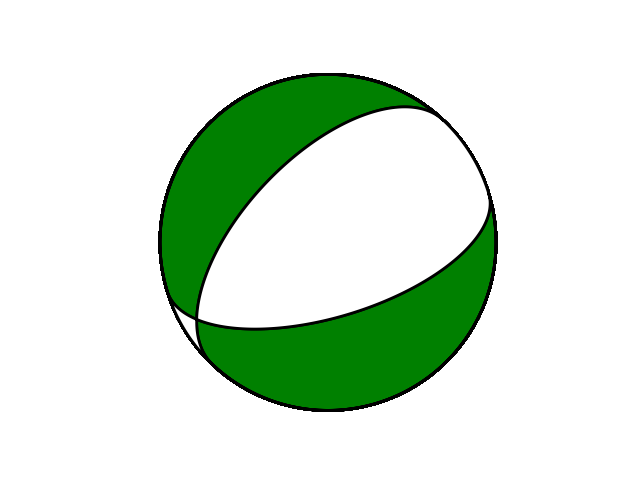
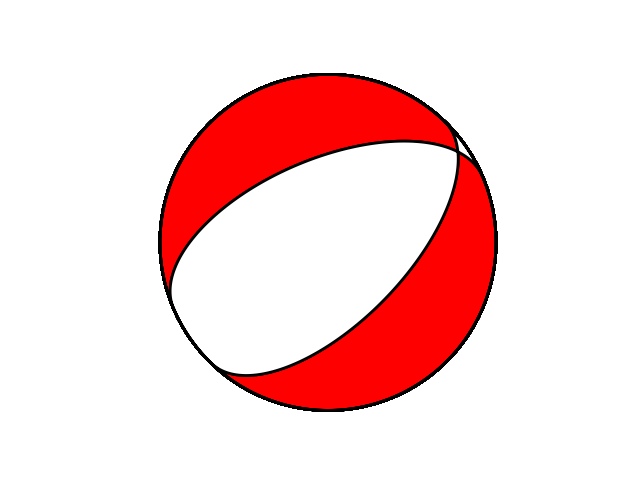
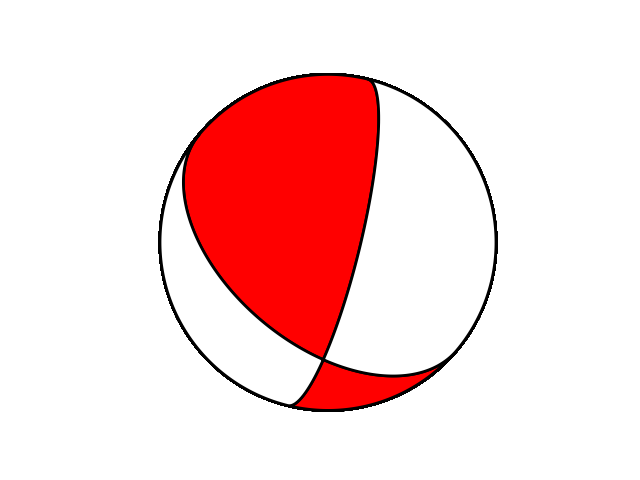
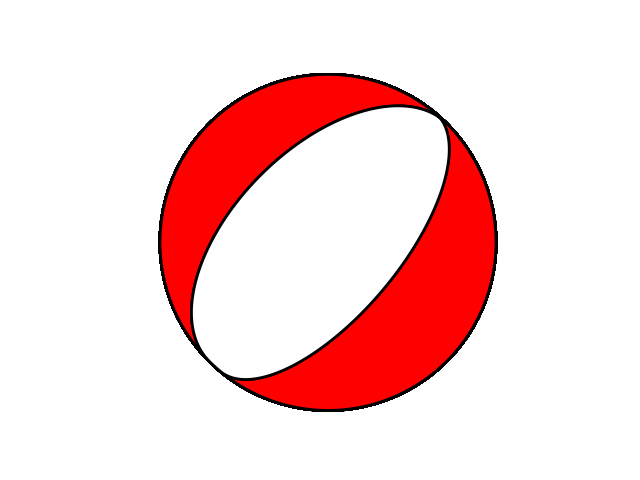
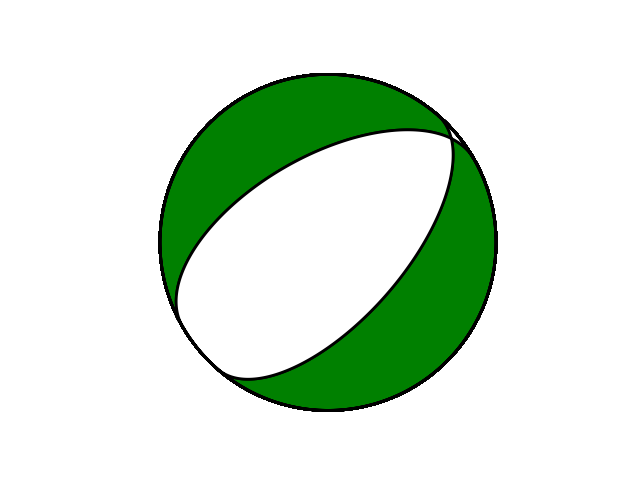
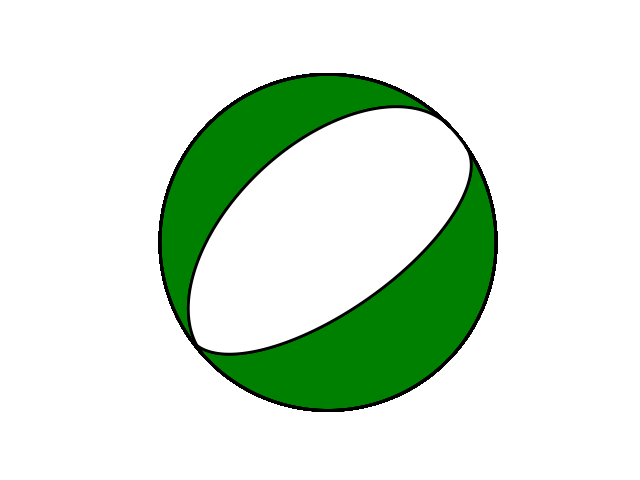
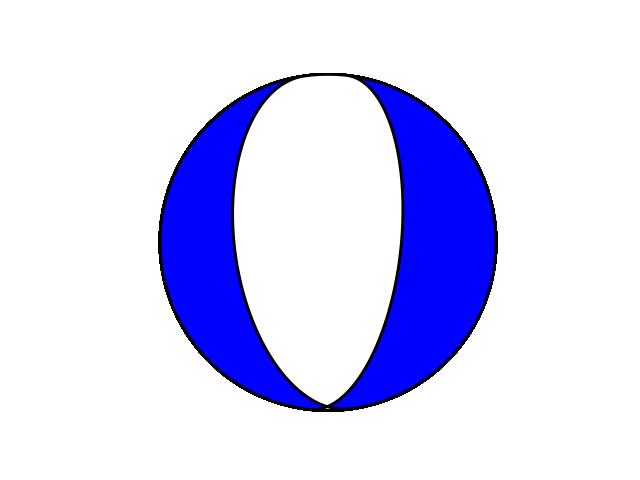
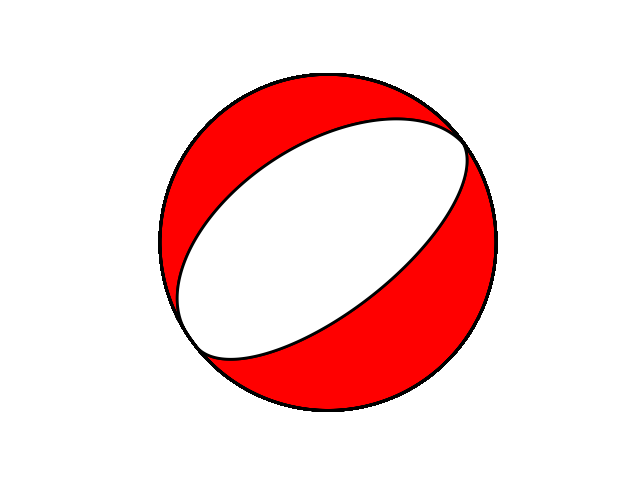
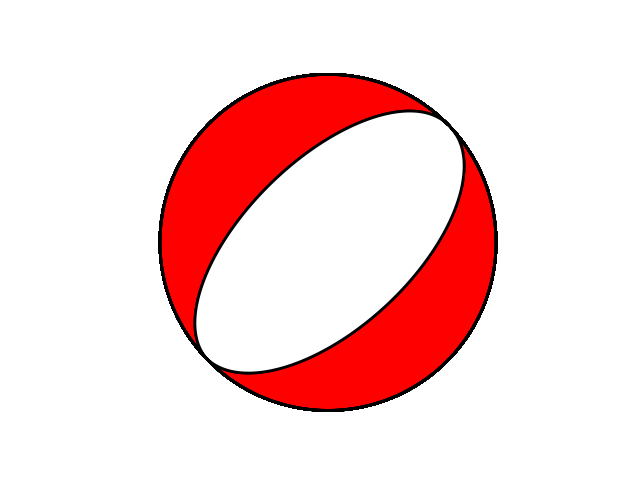
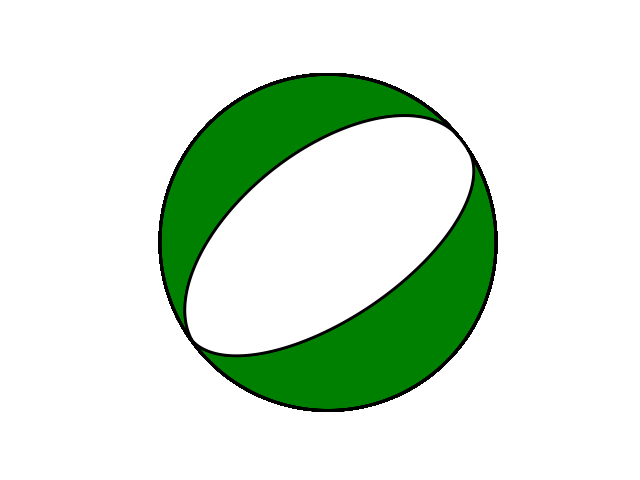
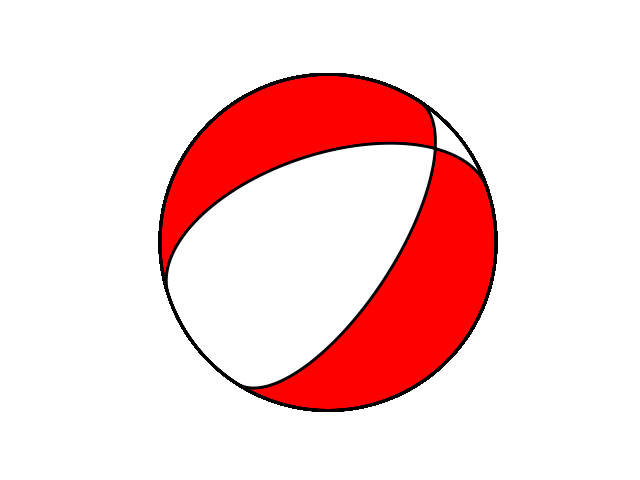
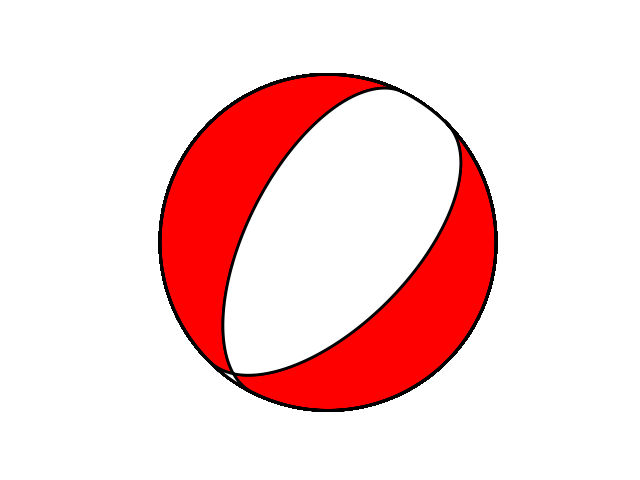
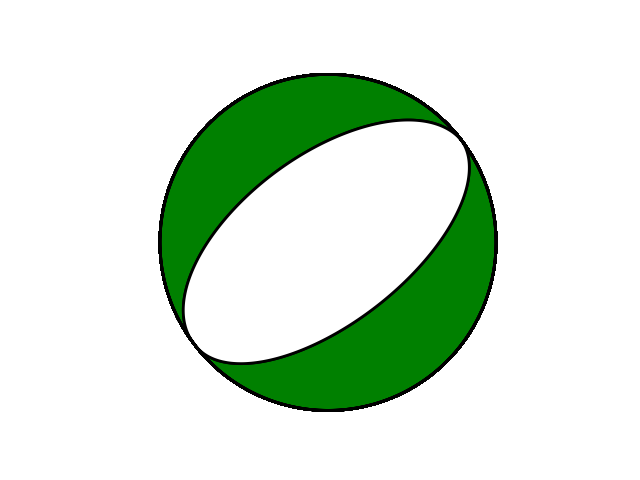
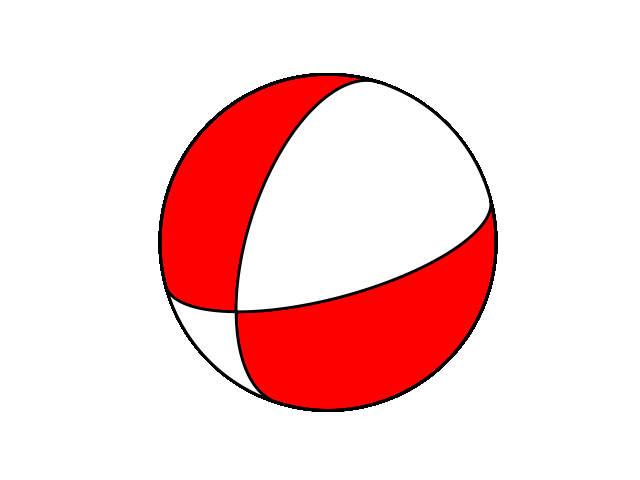
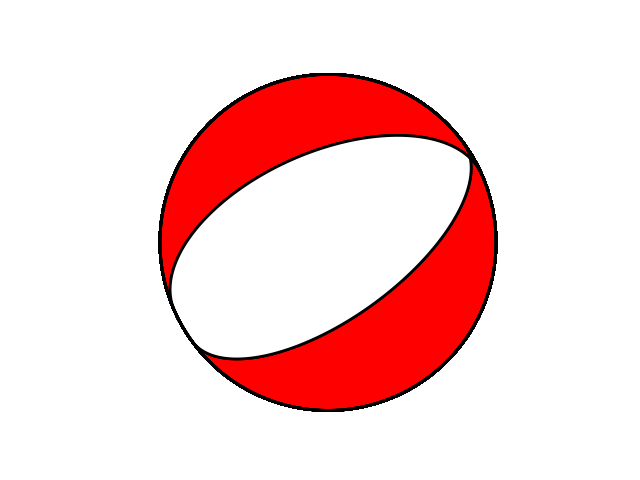
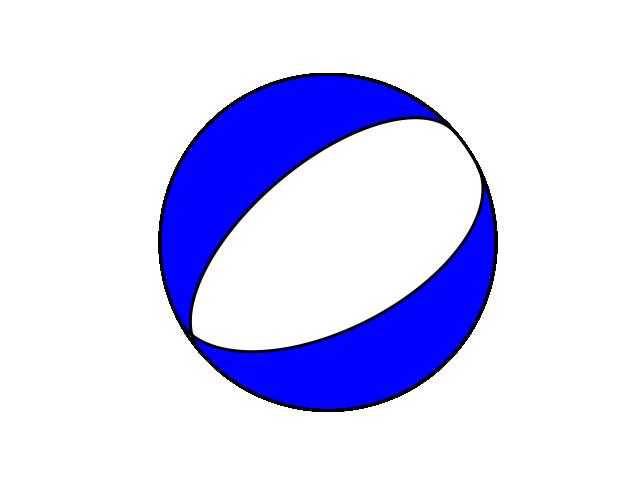
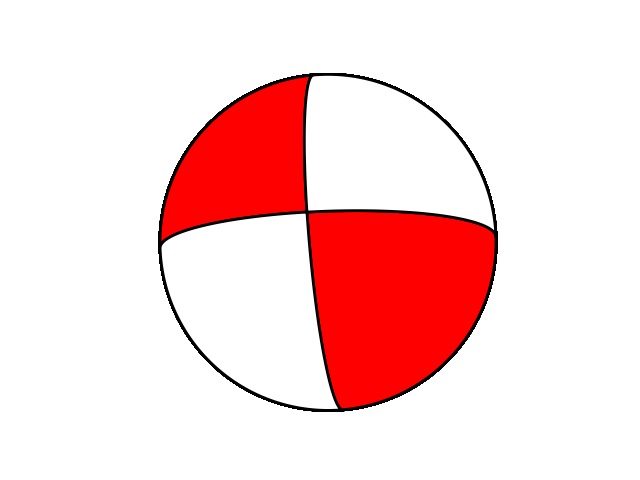
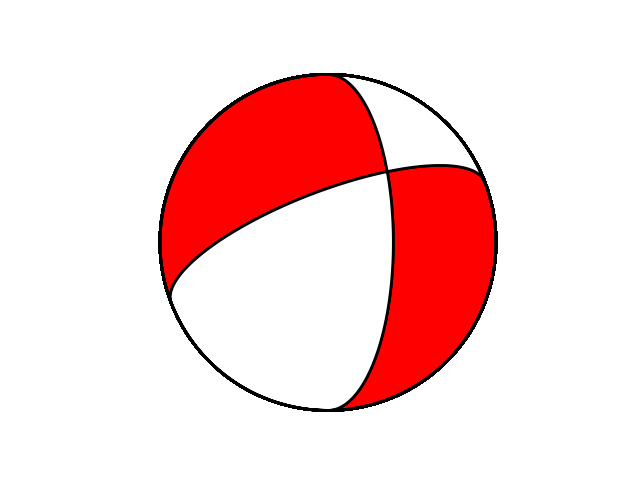
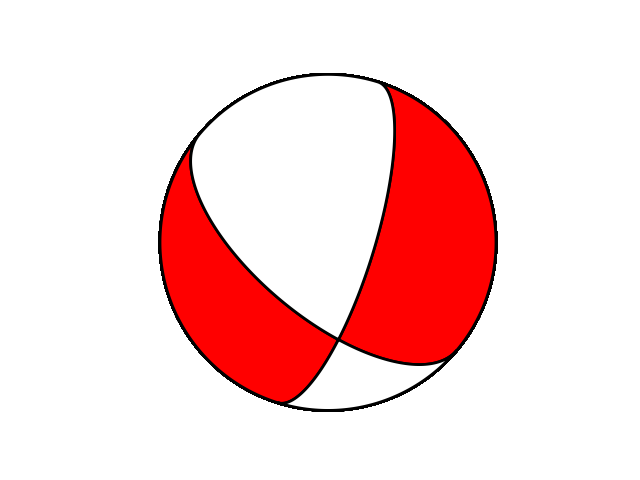
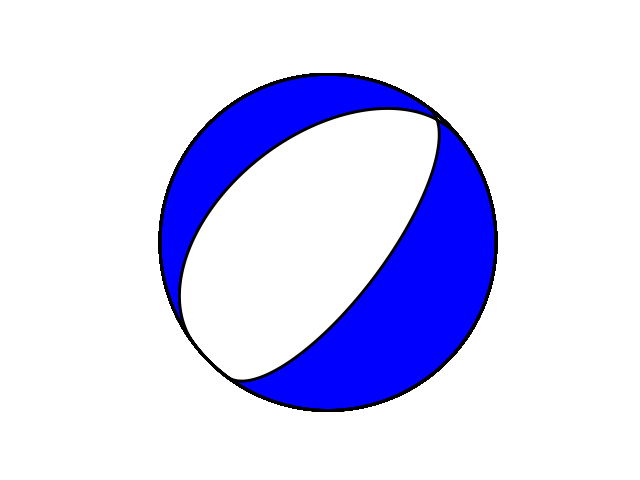
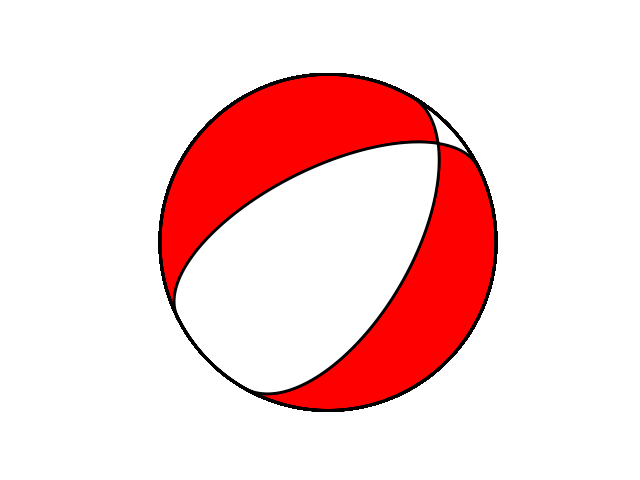
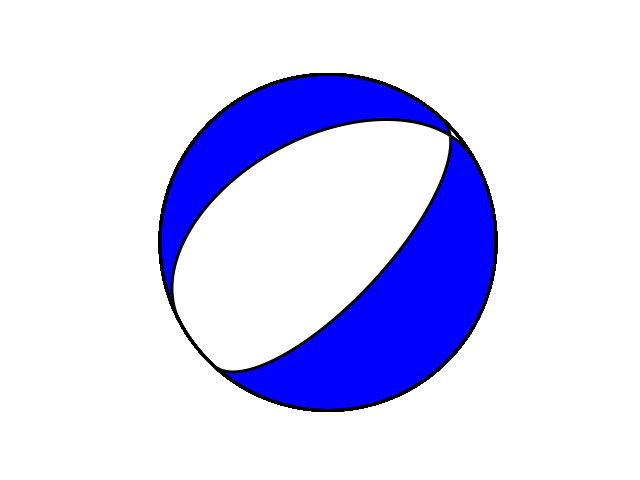
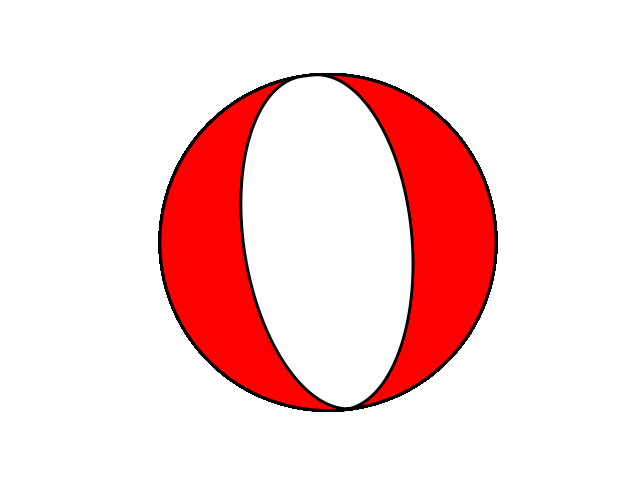
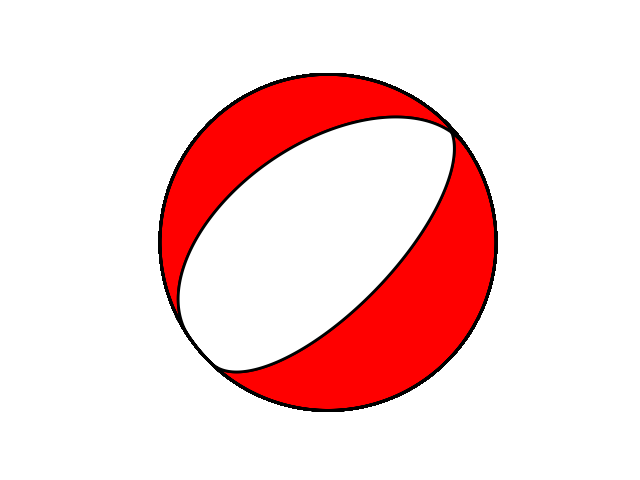
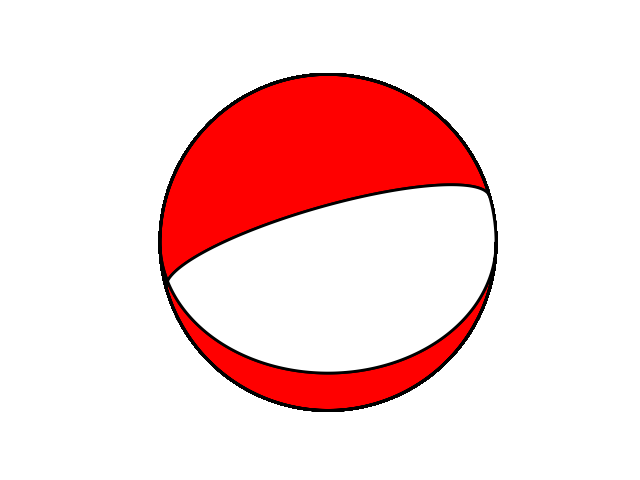
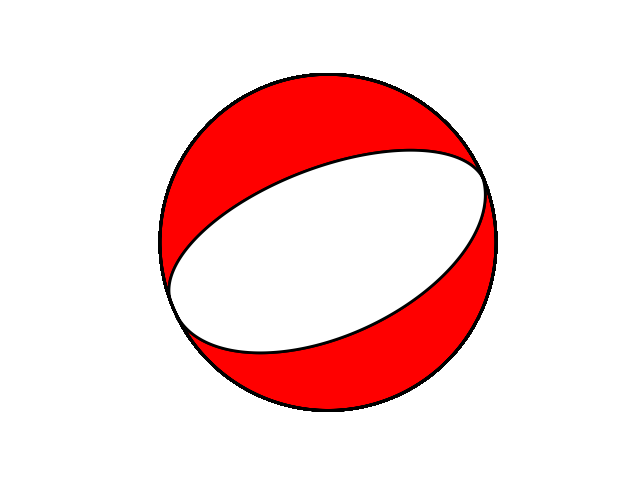
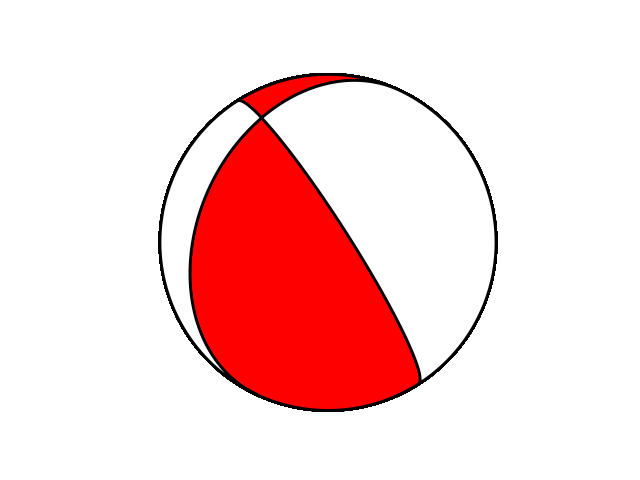
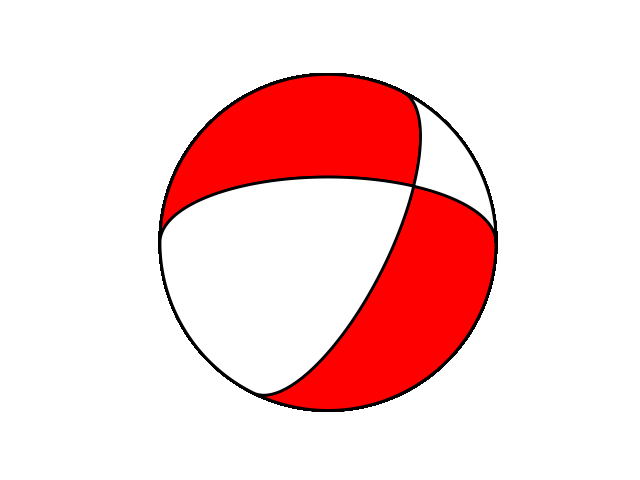
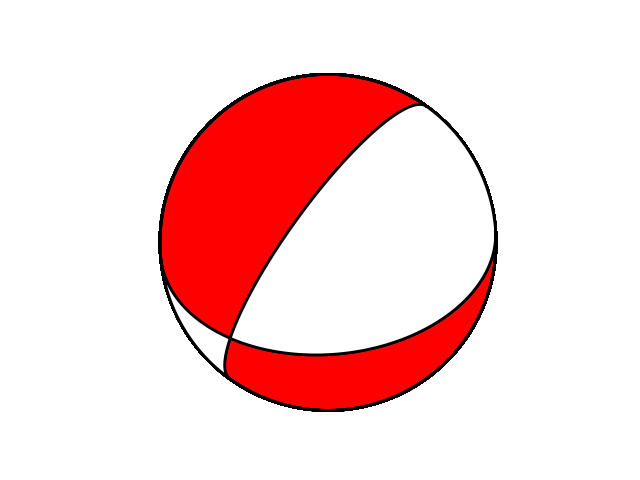
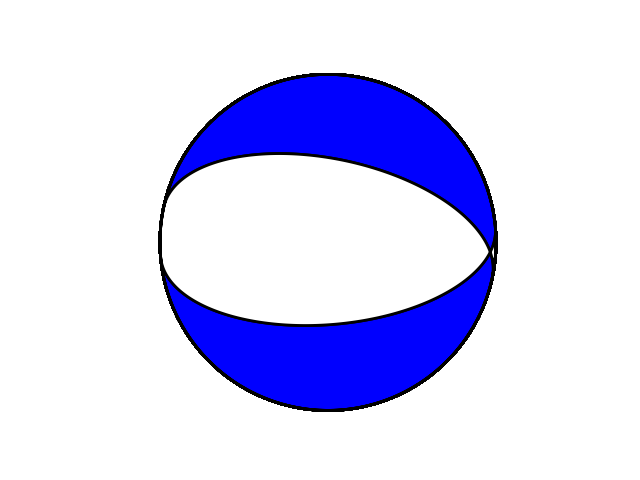
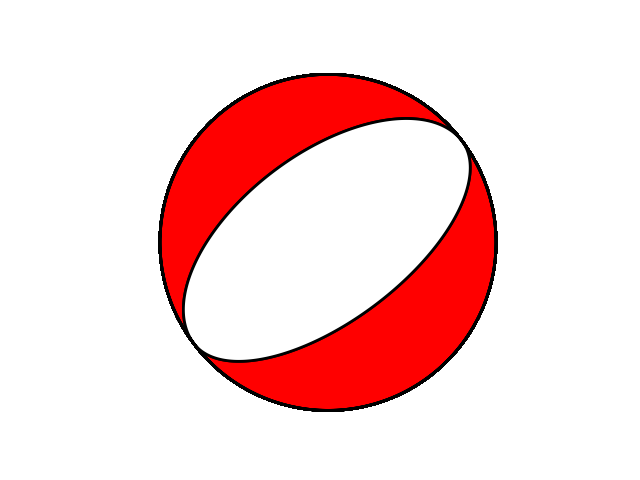
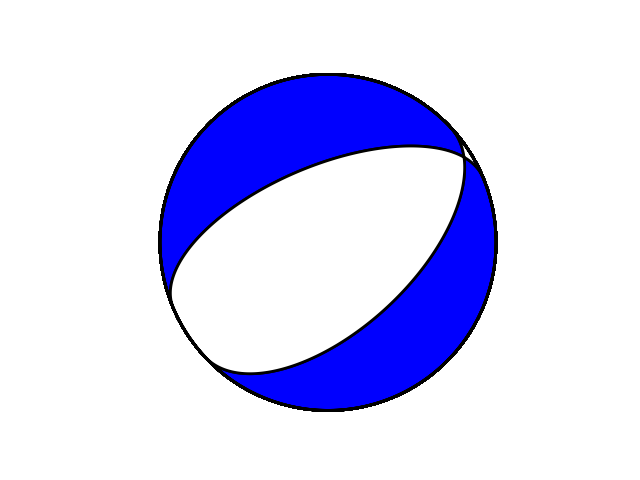
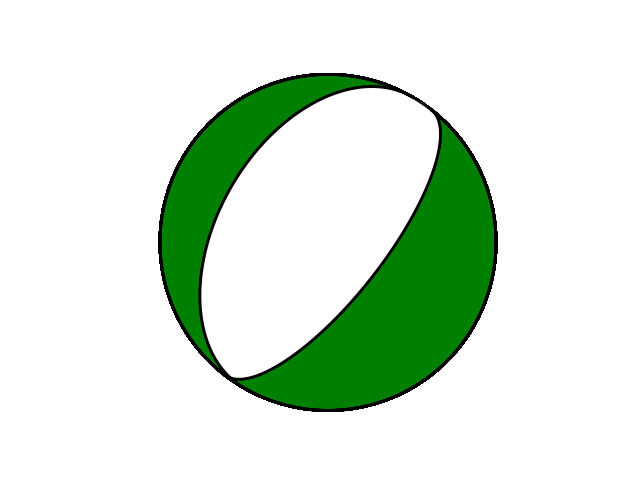
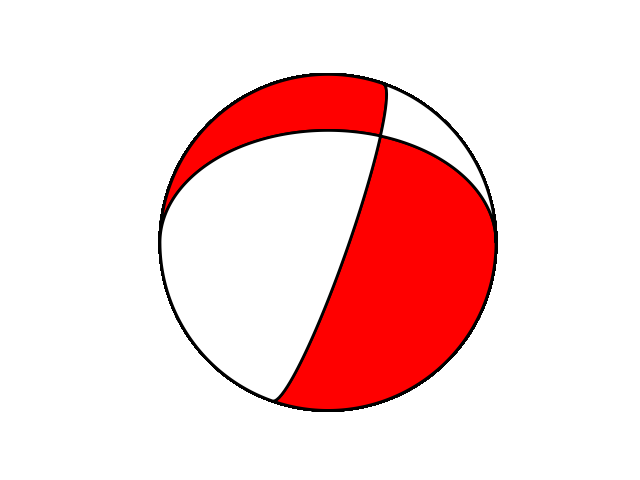
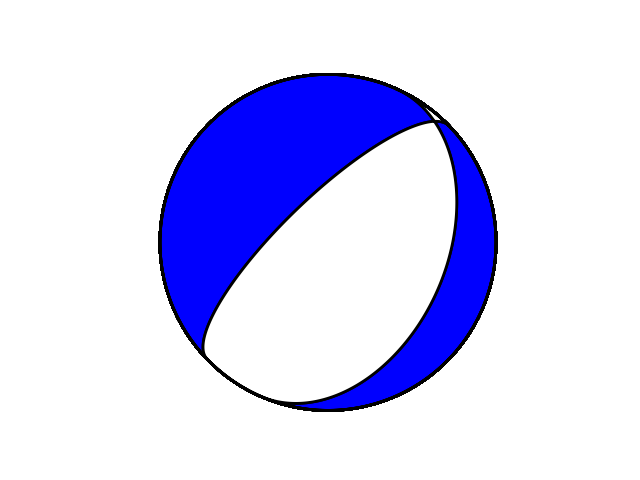
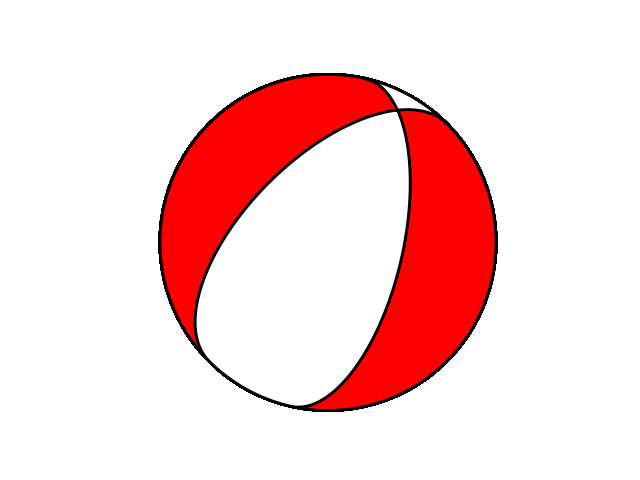
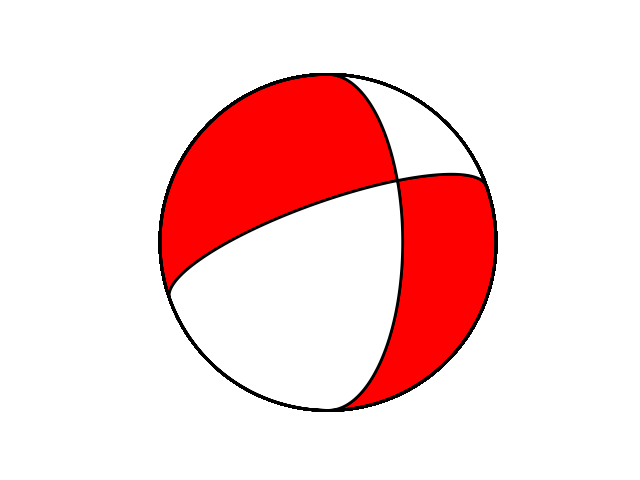
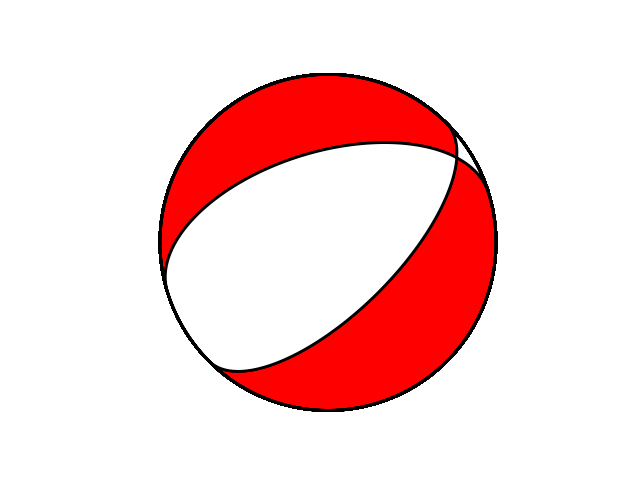
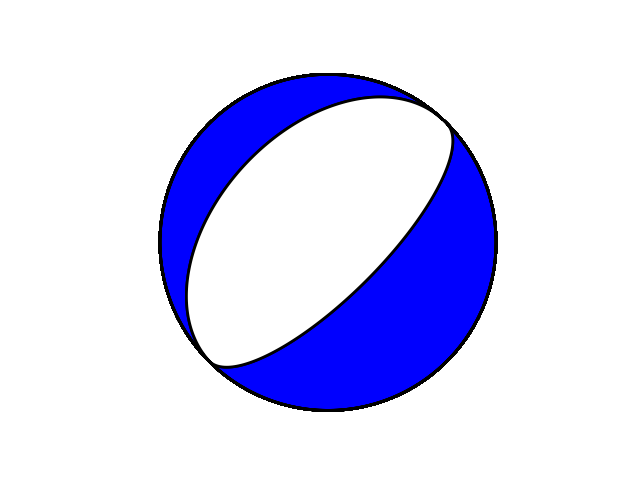
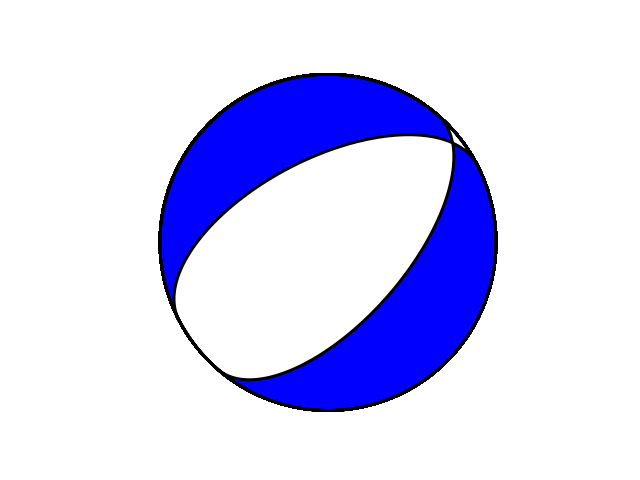
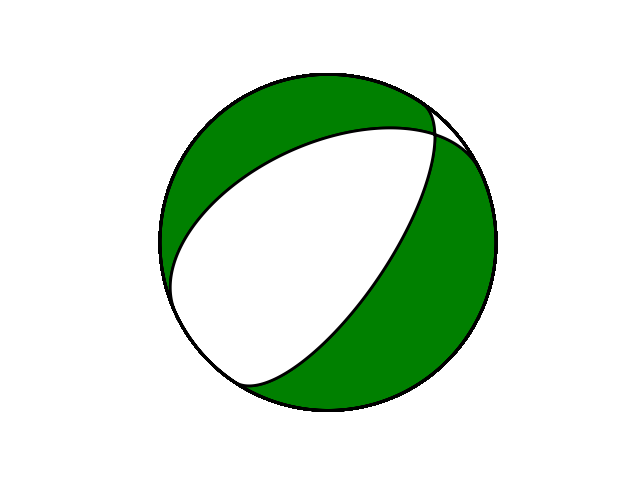
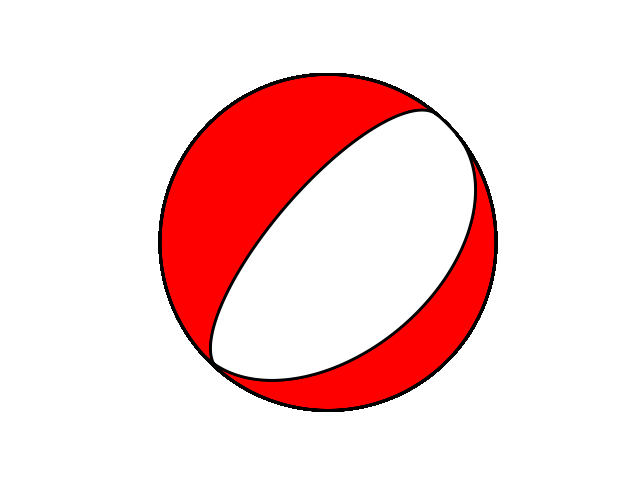
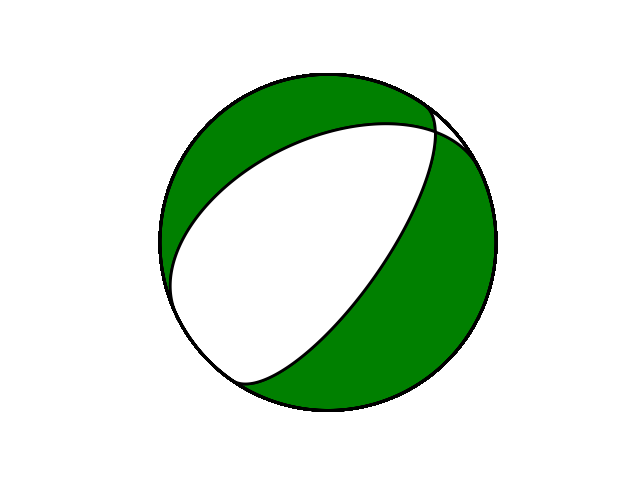
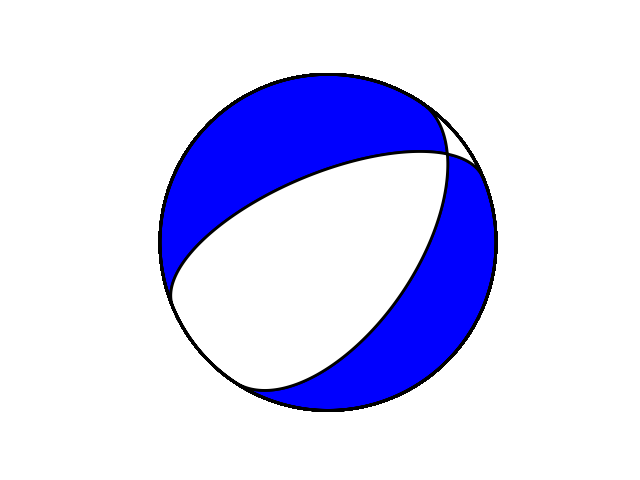
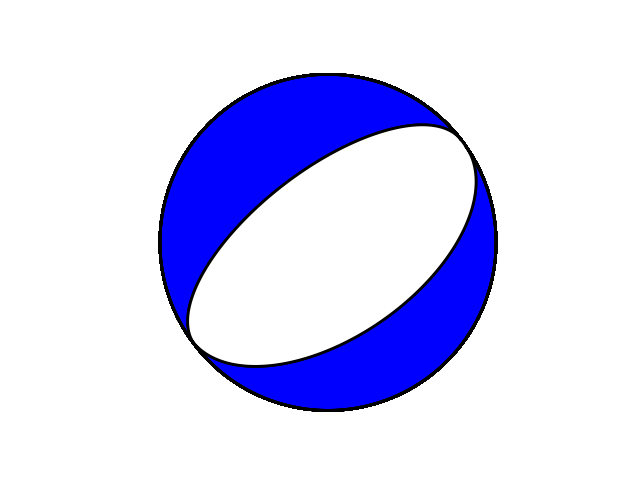
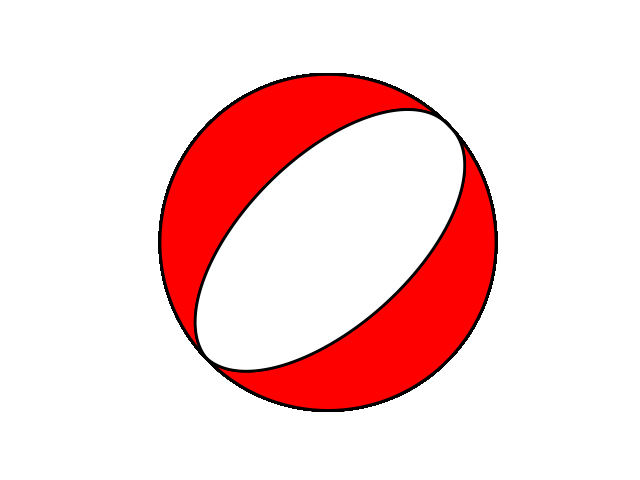
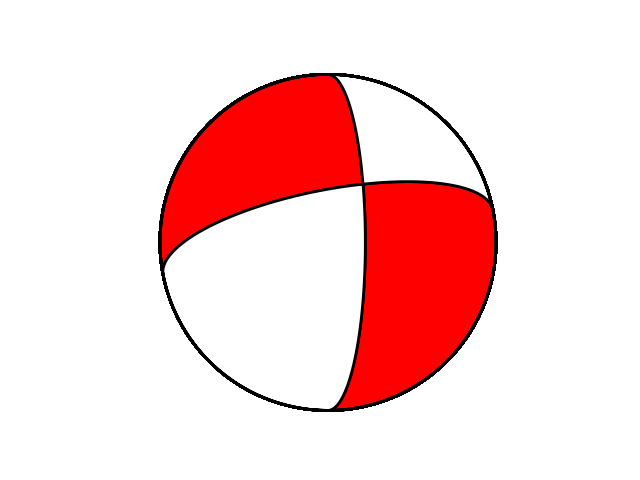
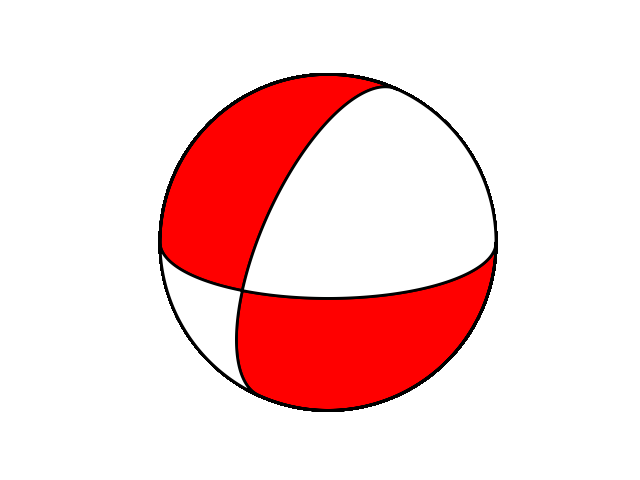
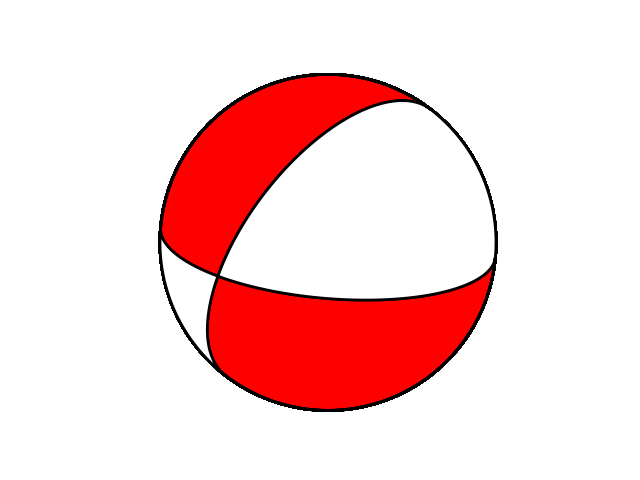
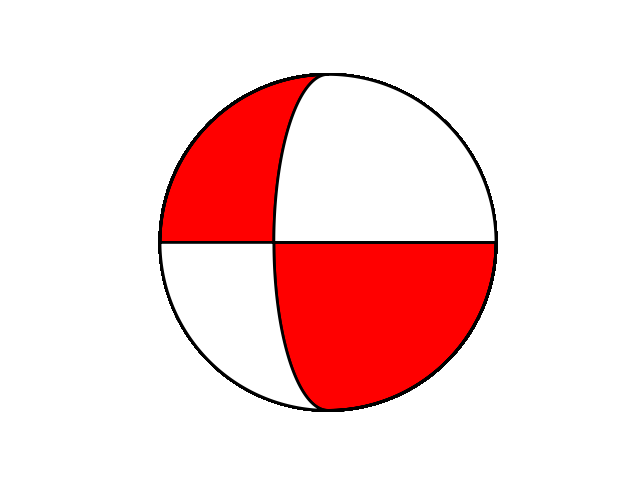
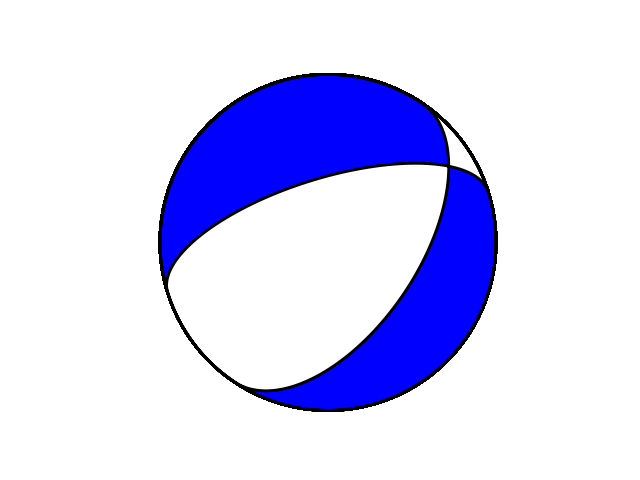
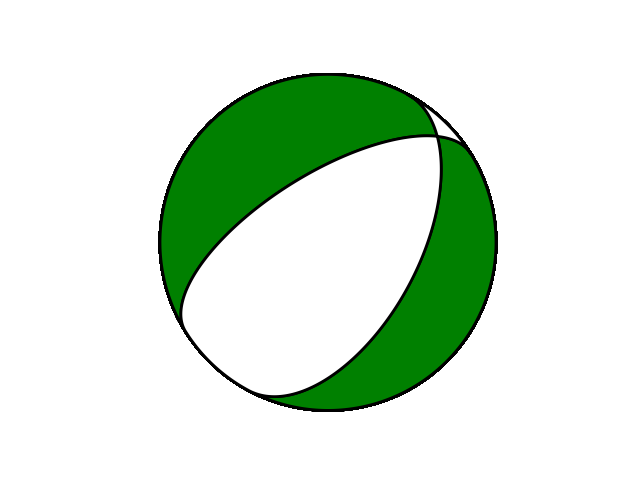
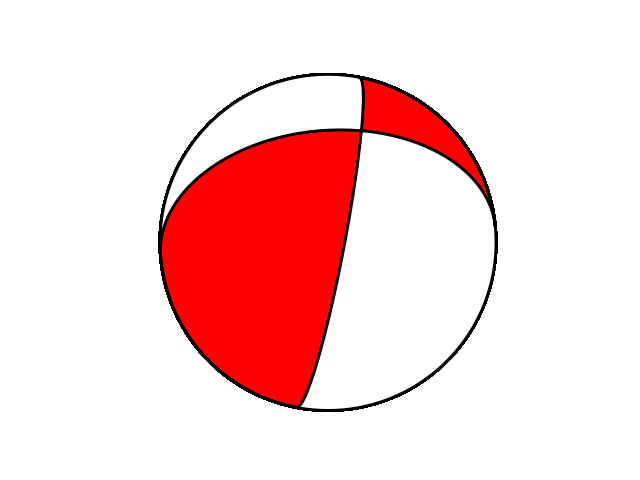
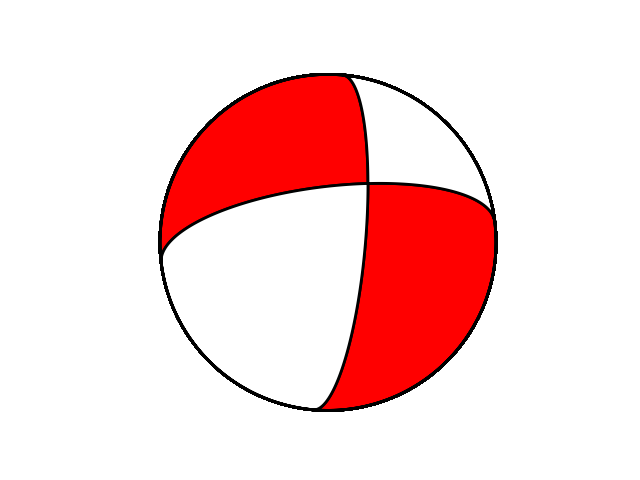
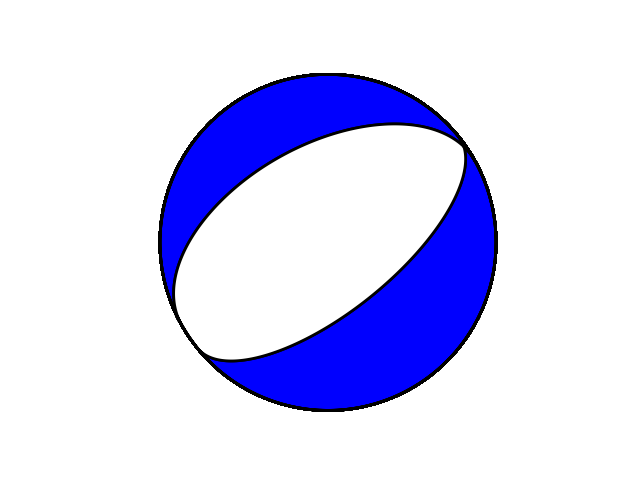
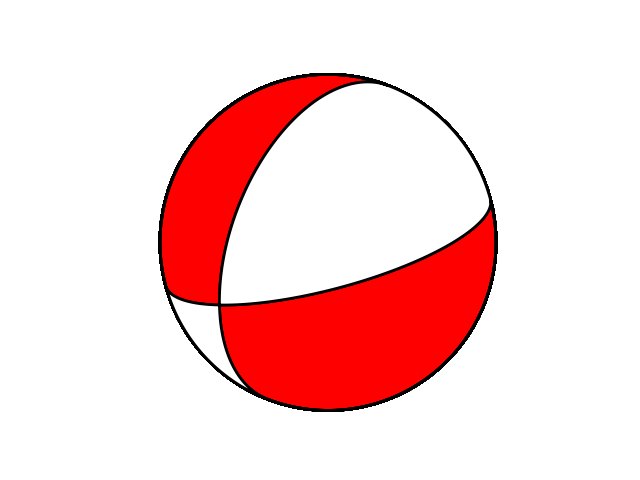
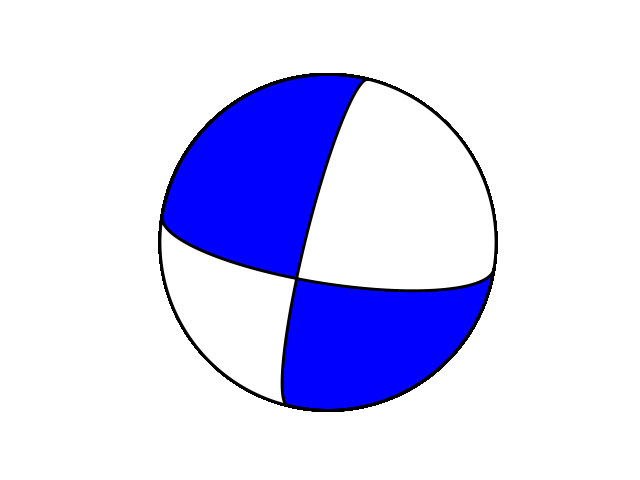
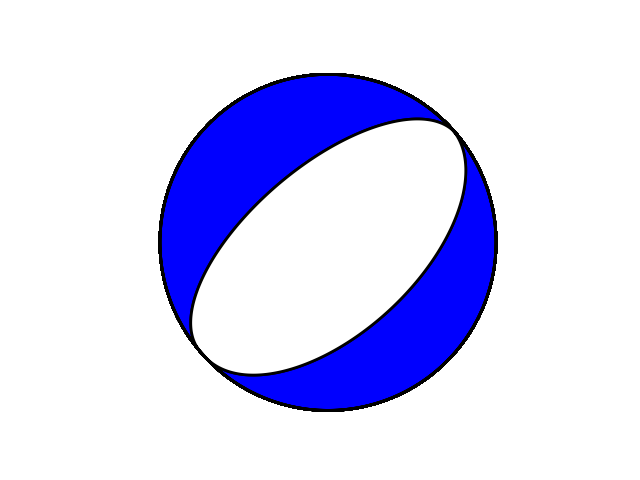
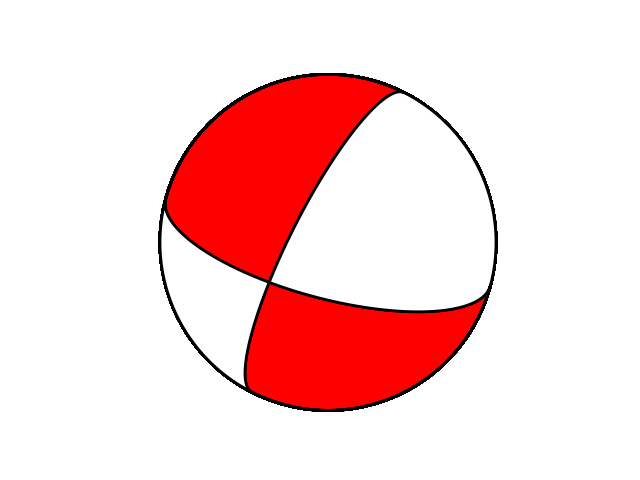
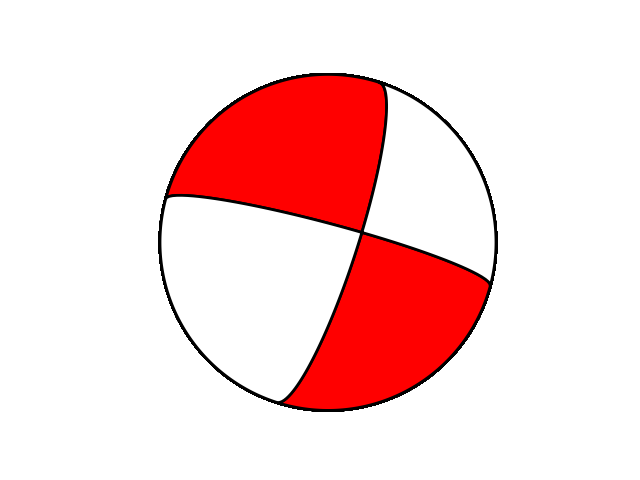
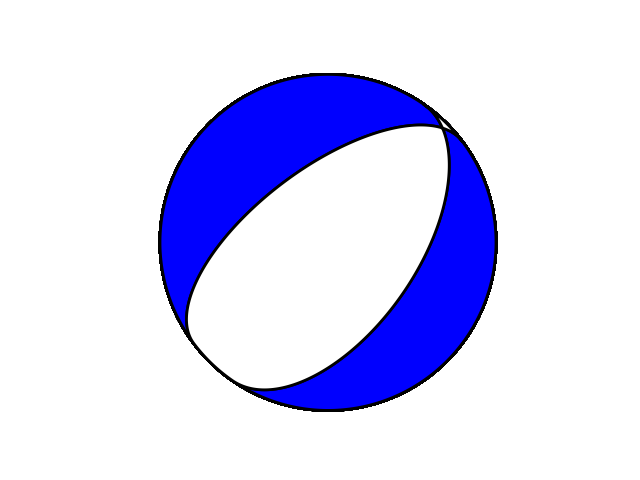
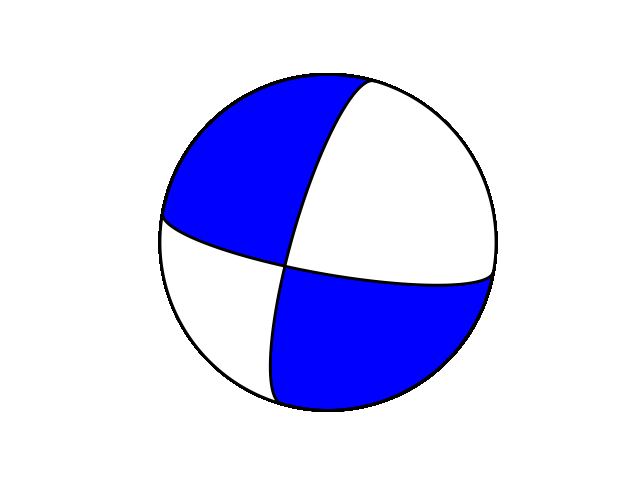
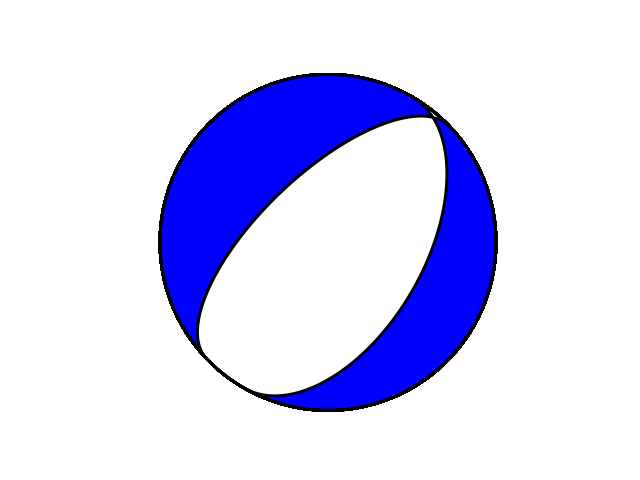
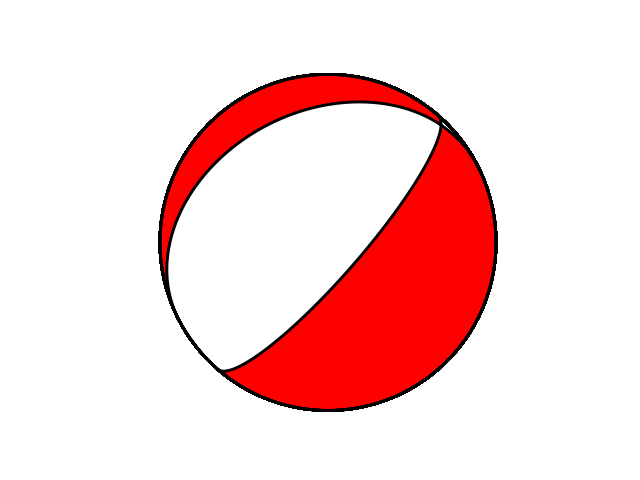
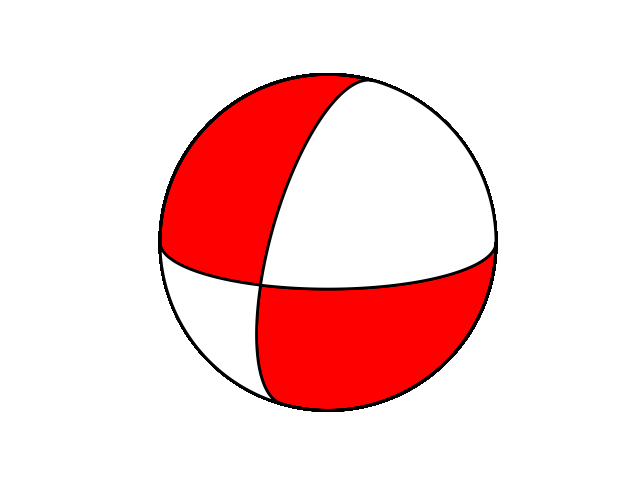
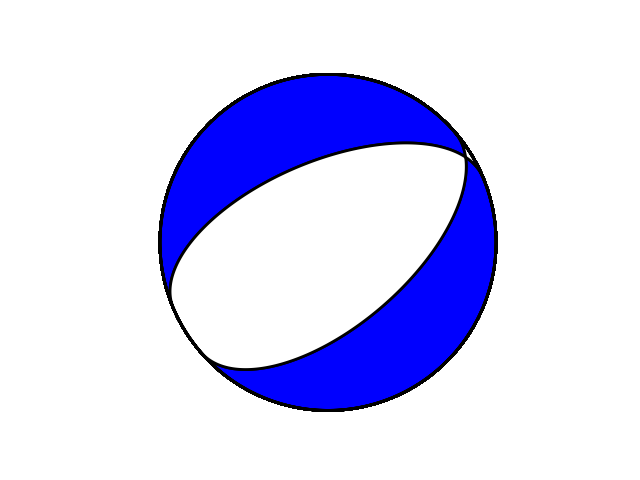
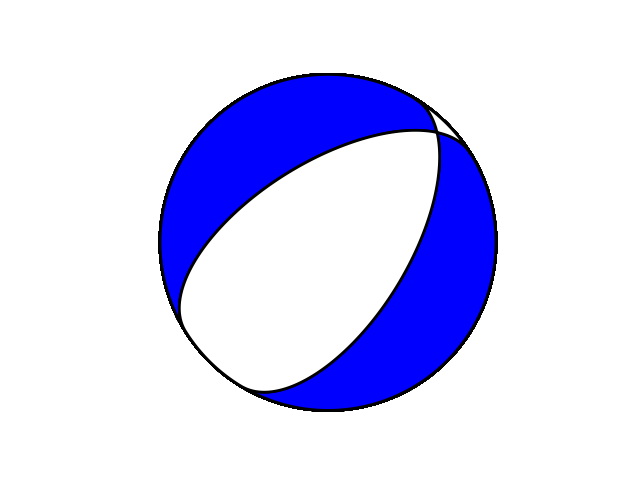
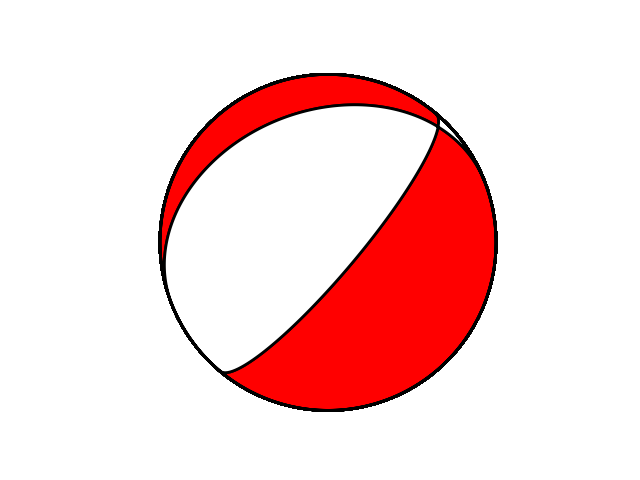
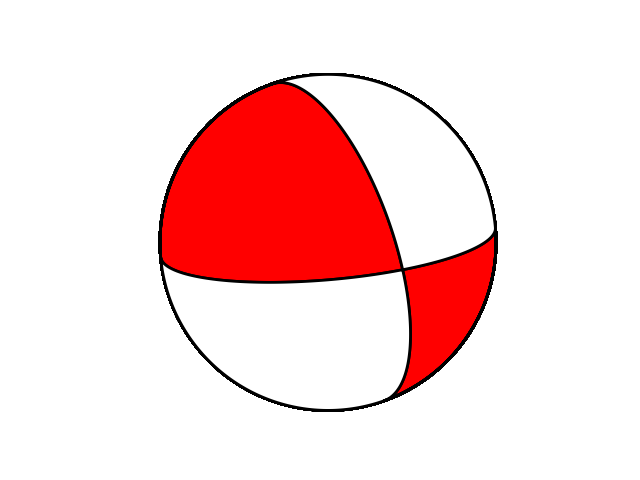
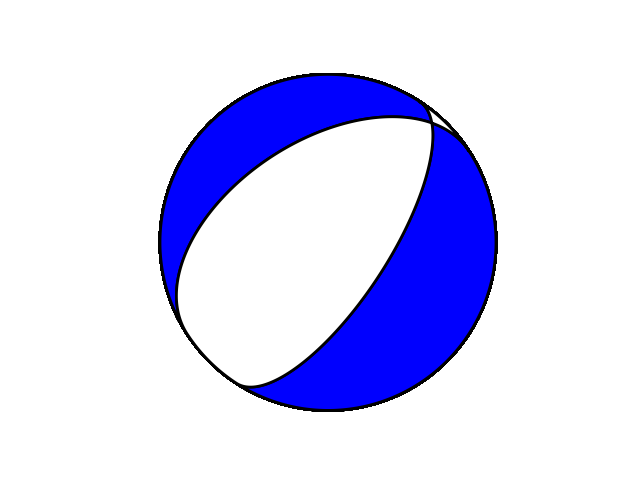
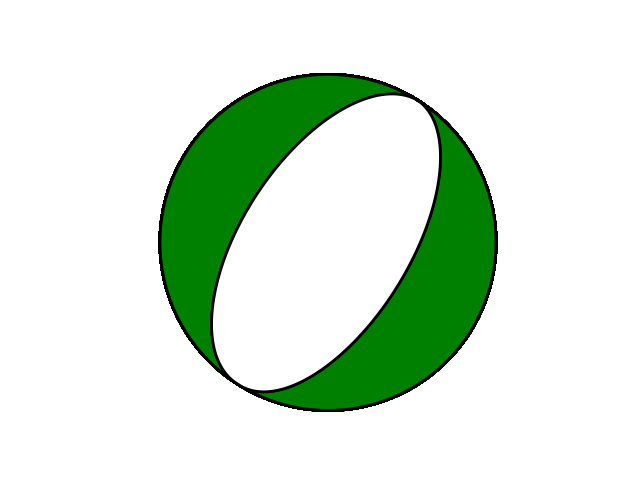
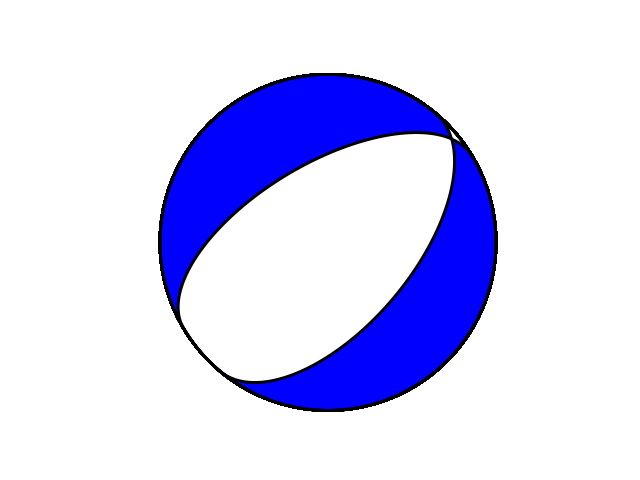
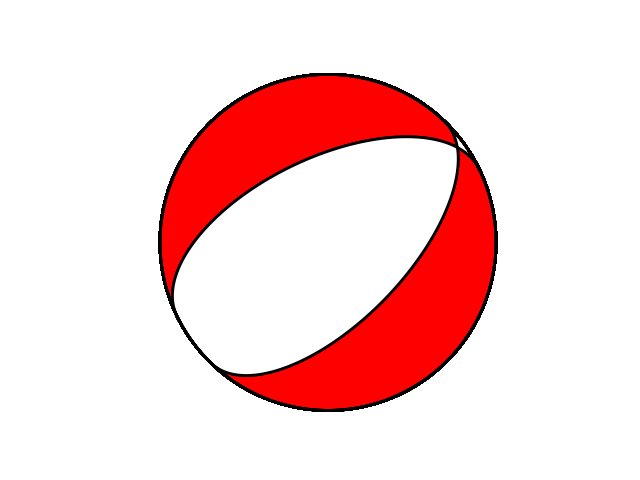
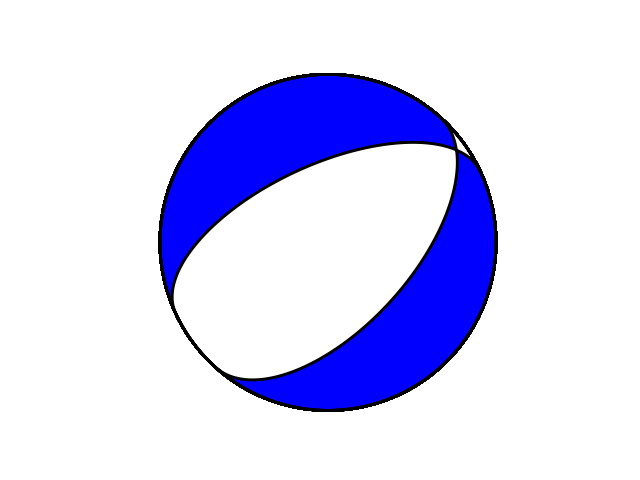
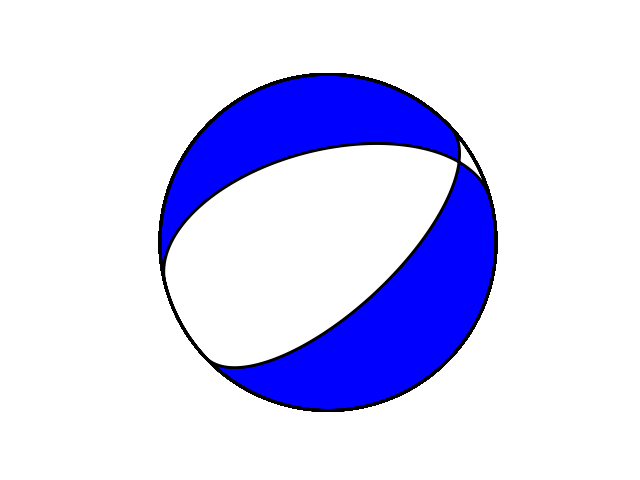
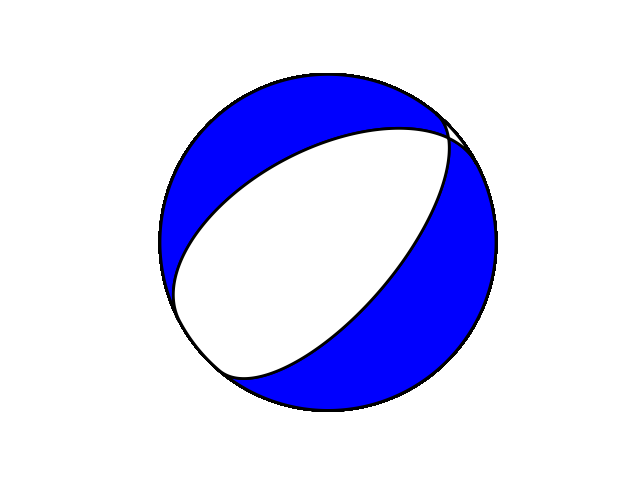
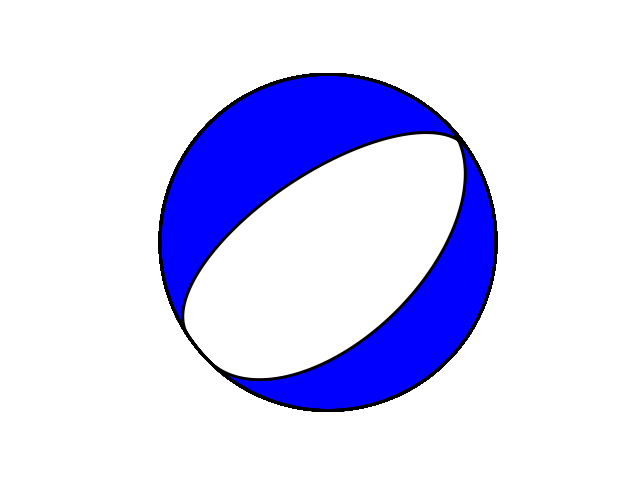
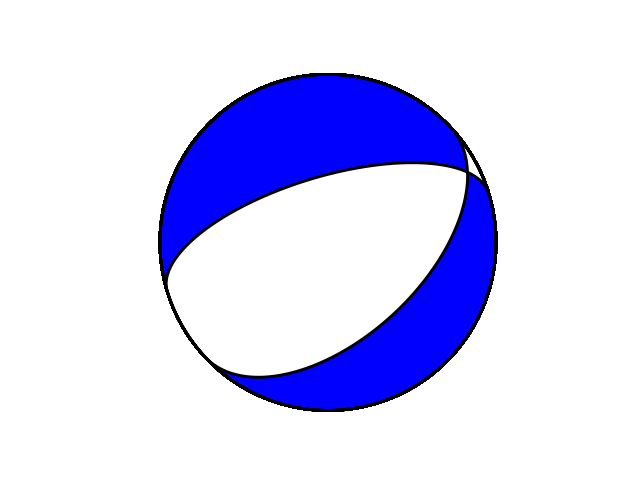
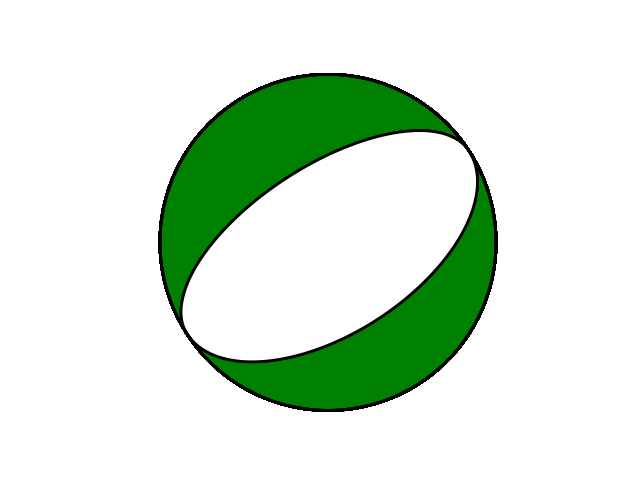
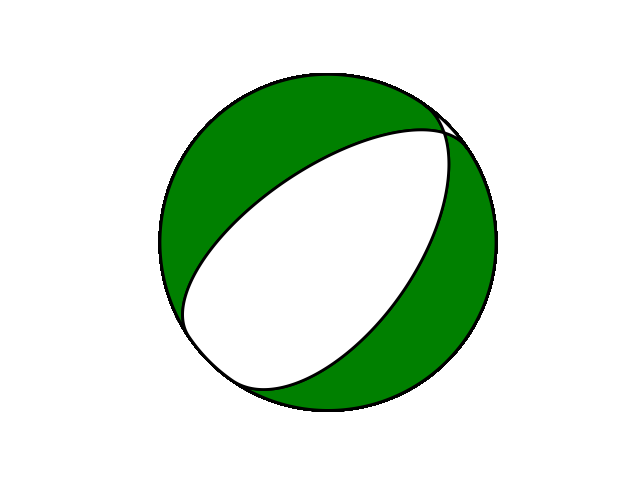
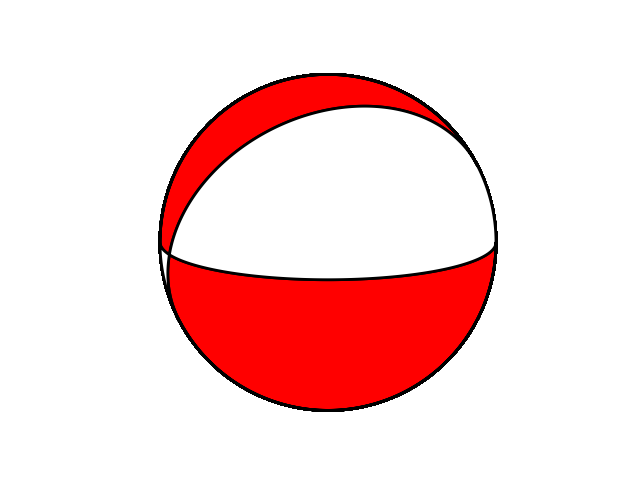
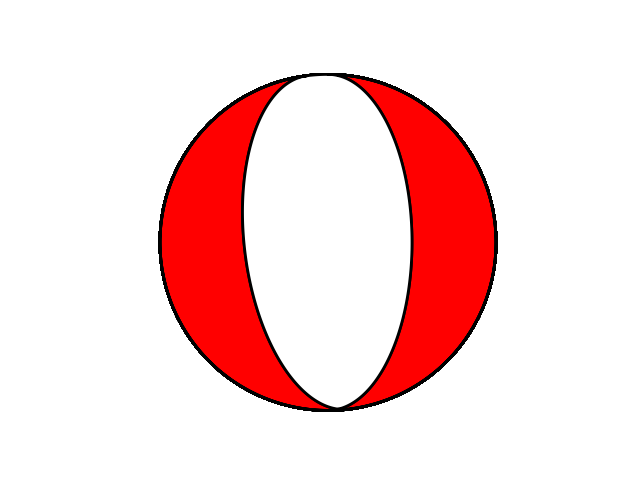
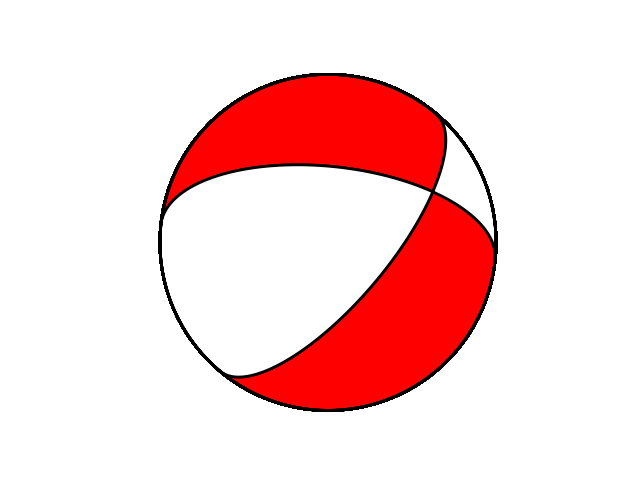
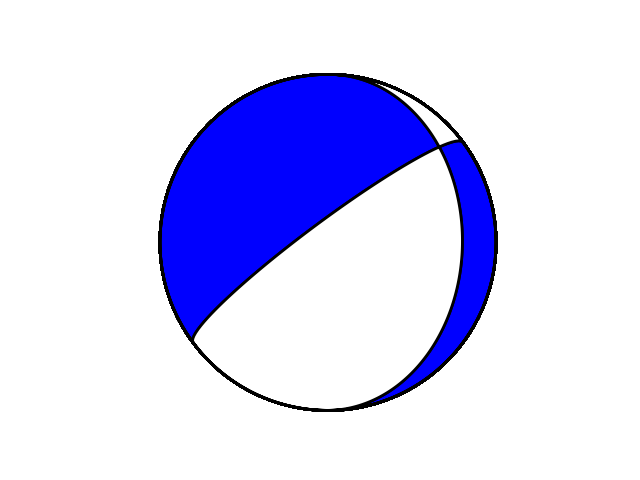
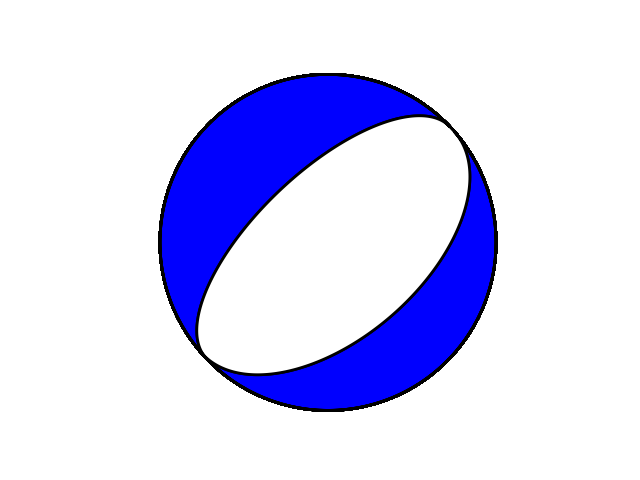
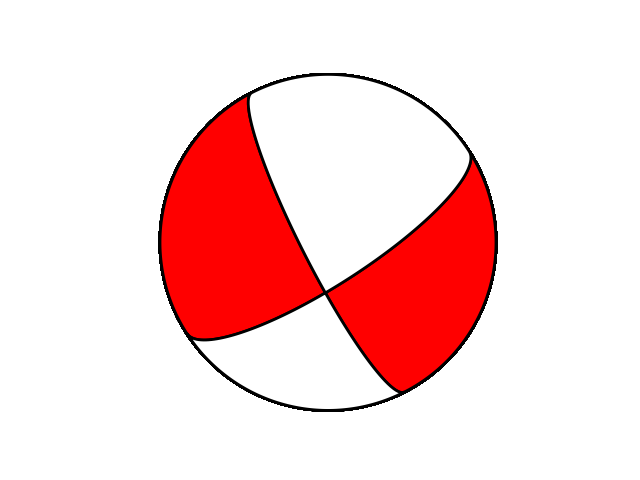
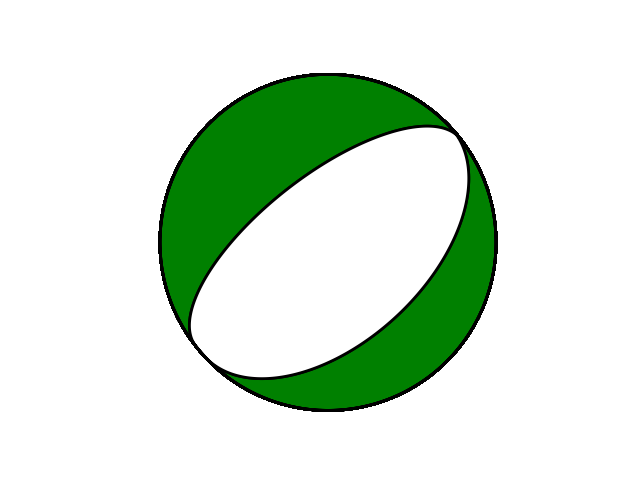
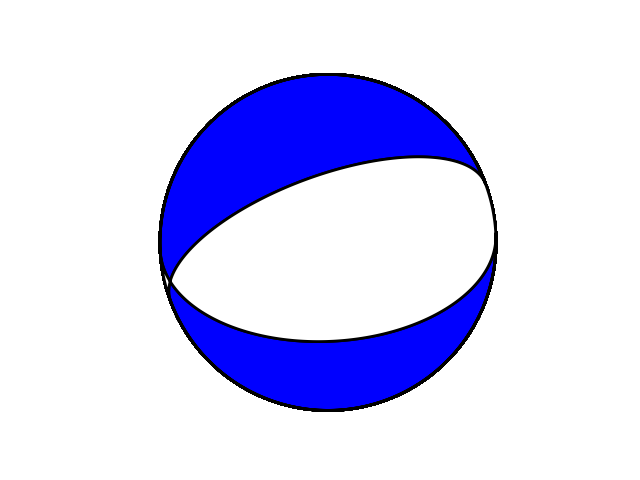
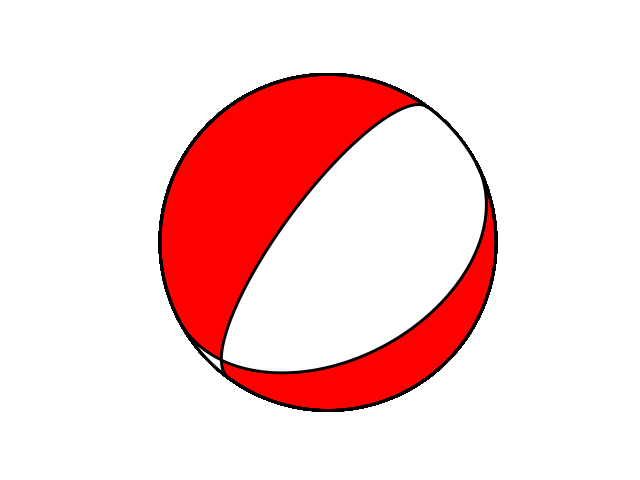

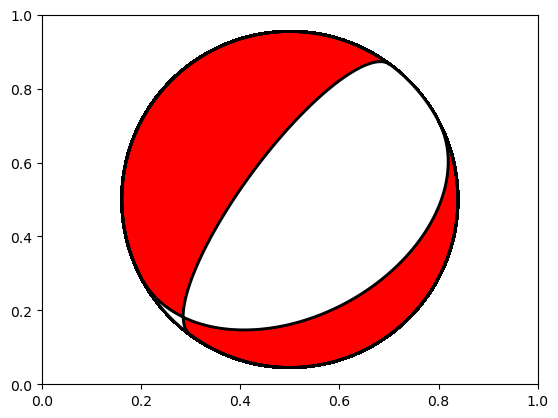

In [43]:
from obspy.imaging.beachball import beachball
import os

# Create the folder if it does not exist
os.makedirs("bb", exist_ok=True)

# Create a Matplotlib figure and axes for beachballs
fig, ax = plt.subplots()

for event in EQ:
    # Generate beach ball image using obspy 
    mt = [event['mt_strike_1'],event['mt_dip_1'],event['mt_rake_1']]
    #print(mt)
    outfile = './bb/' + event['ev_unid'] + '.png' # filename for beachball    
    par = event['mt_per_clvd']
    #print(par)
    if 10 < par < 20:
        facecolor = 'g'
    elif par >= 20:
        facecolor = 'b'
    else: 
        facecolor = 'r'
    #print(f"DC: {event['mt_per_dc']}")
    
    ax.axison = False
    beachball(mt, size=event['ev_mag_value'], linewidth=2, facecolor=facecolor, outfile=outfile, fig=fig) # , alpha= 0.5
    
    # Create an HTML string for the popup
    html = f'''
        <b>Time:</b> {event['ev_event_time']}<br>
        <b>Magnitude:</b> {event['ev_mag_value']}<br>
        <b>Mw:</b> {event['mt_mw']}<br>
        <b>Depth:</b> {event['ev_depth']}<br>
        <b>Lat:</b> {event['ev_latitude']}<br>
        <b>Lon:</b> {event['ev_longitude']}<br>
        <b>DC:</b> {event['mt_per_dc']}<br>
        <b>ISO:</b> {event['mt_per_iso']}<br>
        <b>CLVD:</b> {event['mt_per_clvd']}<br>
        <b>Strike:</b> {event['mt_strike_1']}<br>
        <b>Dip:</b> {event['mt_dip_1']}<br>
        <b>Rake:</b> {event['mt_rake_1']}<br>        
    '''
    # Custom icon
    size_icon = (event['ev_mag_value'])*8
    icon_image = folium.CustomIcon(
        icon_image= outfile,  # Replace with the actual path to your image file
        icon_size=(size_icon+8, size_icon),  # Optional: specify the size of the icon (width, height) in pixels
        icon_anchor=(size_icon/2, size_icon),  # Optional: the point on the icon that aligns with the lat/lon
        popup_anchor=(0, -30)   # Optional: where the popup opens relative to the icon_anchor
    )
    # Create a popup with the HTML content
    popup = folium.Popup(html, max_width=200)

    # Add a marker with the popup
    folium.Marker(
        location=[event['ev_latitude'], event['ev_longitude']],
        popup=popup,
        tooltip=event['ev_unid'],
        icon=icon_image
    ).add_to(m)
    ax.cla()
display(m)

 # Plot GNSS timeseries

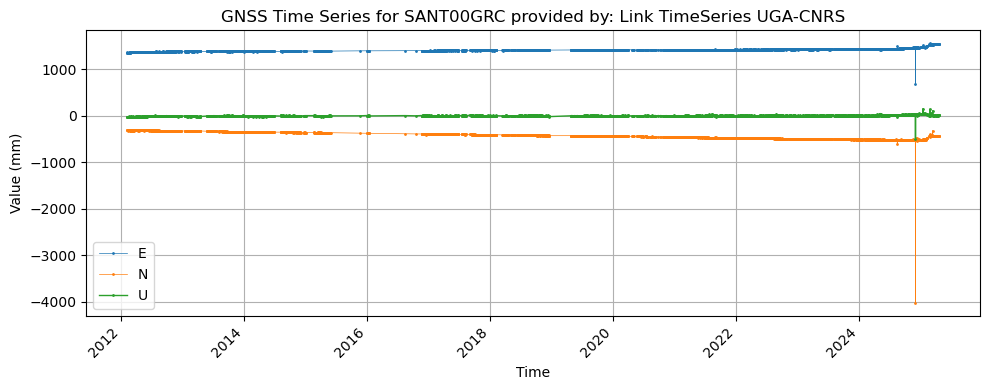

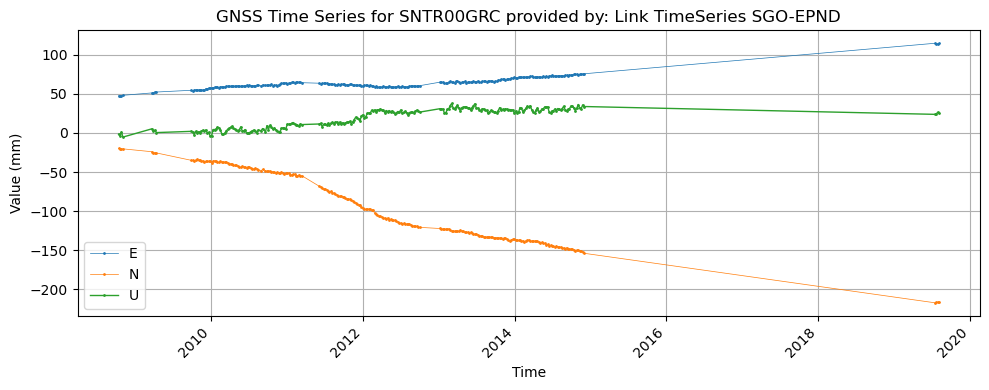

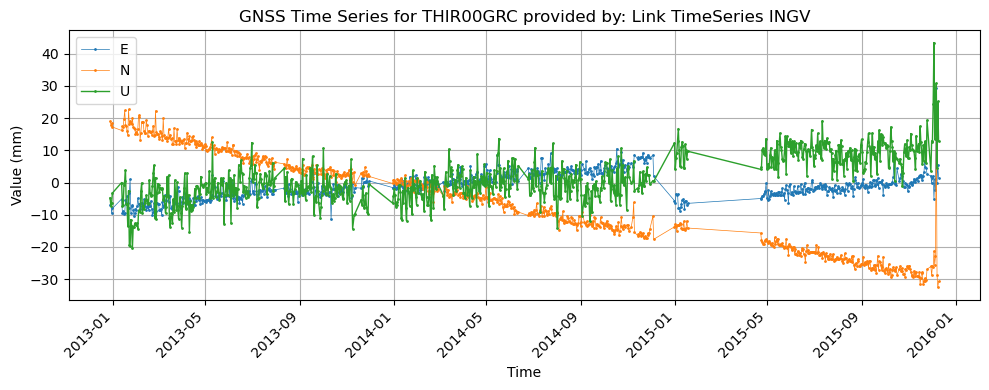

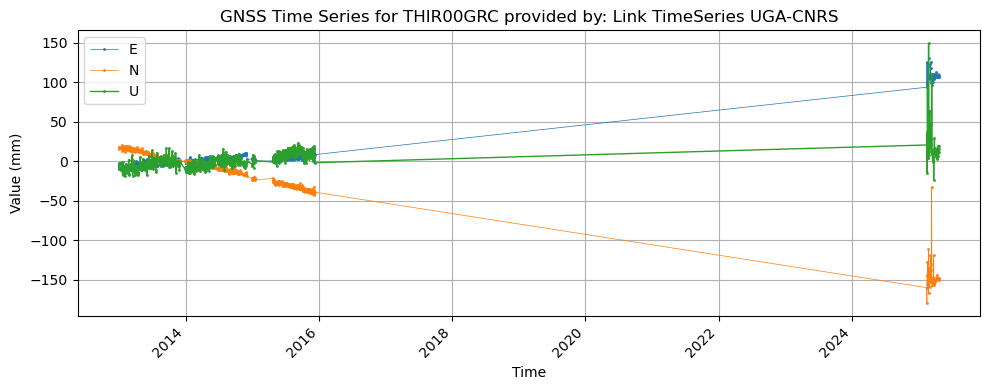

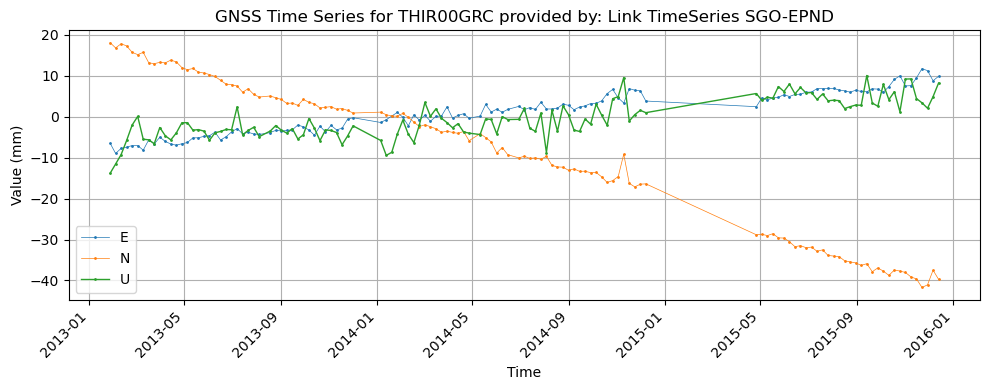

In [92]:
# Plot GNSS timeseries
for item in stations:
    if 'data_links' in item:
        for link_name, link_url in item['data_links'].items():
            link_url_enz = link_url.replace("/xyz/", "/enu/") # requesting East, North, Up data instead of XYZ; units in mm
            content = requests.get(link_url_enz)
            payload = json.loads(content.text)
            
            time_values = [datetime.fromisoformat(t.replace('Z', '+00:00')) for t in payload['domain']['axes']['t']['values']]
            x_values = payload['ranges']['E']['values']
            y_values = payload['ranges']['N']['values']
            z_values = payload['ranges']['U']['values']
            
            plt.figure(figsize=(10, 4))
            plt.plot(time_values, x_values, label='E', marker='.', markersize=2, linewidth=0.7)
            plt.plot(time_values, y_values, label='N', marker='.', markersize=2, linewidth=0.7)
            plt.plot(time_values, z_values, label='U', marker='.', markersize=2, linewidth=0.7)
            plt.xlabel('Time')
            plt.ylabel('Value (mm)')
            plt.title('GNSS Time Series for ' + item['title'] + ' provided by: ' + link_name)
            plt.grid(True)
            plt.legend()
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

 # Analyze moment tensors in time

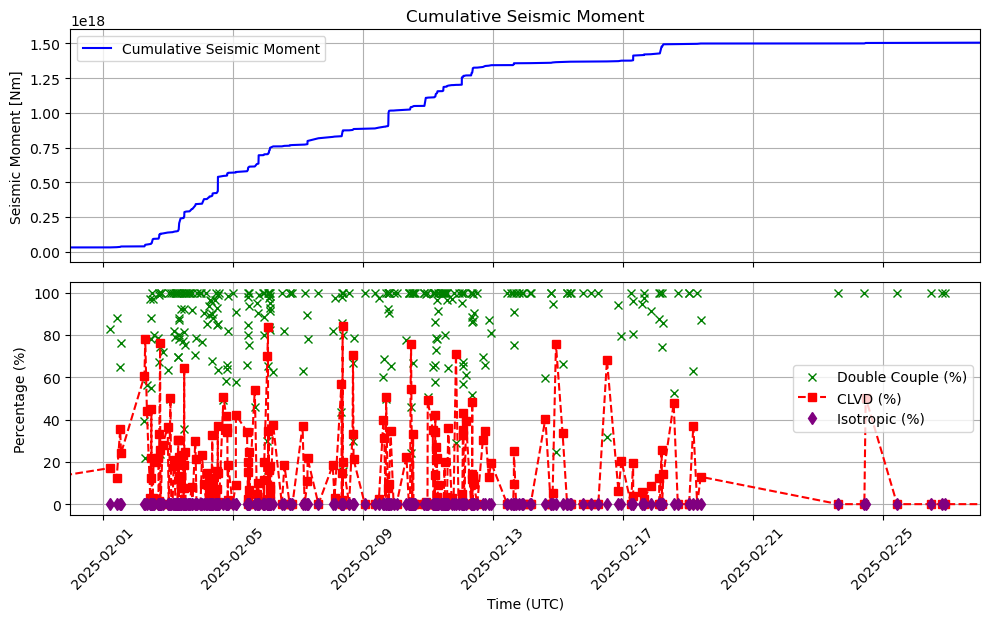

In [69]:
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame(EQ)

# Print the DataFrame
#print(df)

# Set the zoom window for February 2025
start_date = pd.to_datetime('2025-01-31')
end_date = pd.to_datetime('2025-02-28')

# Convert 'mt_centroid_time' to datetime objects
# Handle potential errors due to the incomplete timestamp in the last entry
df['time'] = pd.to_datetime(df['ev_event_time'], errors='coerce')

# Sort the DataFrame by time
df = df.sort_values(by='time')
df = df.dropna(subset=['time']) # Remove rows with invalid time

# Calculate the actual seismic moment using mt_m0 and mt_m0_exp
df['seismic_moment'] = df['mt_m0'] * (10 ** df['mt_m0_exp'])

# Create the cumulative seismic moment vector
df['cumulative_seismic_moment'] = df['seismic_moment'].cumsum()

# Create the figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot event magnitude on the first subplot
axs[0].plot(df['time'], df['cumulative_seismic_moment'], marker='', linestyle='-', label='Cumulative Seismic Moment', color='blue')
axs[0].set_ylabel('Seismic Moment [Nm]')
axs[0].set_title('Cumulative Seismic Moment')
axs[0].grid(True)
axs[0].legend()

# Plot DC, CLVD, and ISO on the second subplot
axs[1].plot(df['time'], df['mt_per_dc'], marker='x', linestyle='', label='Double Couple (%)', color='green')
axs[1].plot(df['time'], df['mt_per_clvd'], marker='s', linestyle='--', label='CLVD (%)', color='red')
axs[1].plot(df['time'], df['mt_per_iso'], marker='d', linestyle='', label='Isotropic (%)', color='purple')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_xlabel('Time (UTC)')
axs[1].grid(True)
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.xlim(start_date, end_date)
plt.show()